<a href="https://colab.research.google.com/github/annkvth/kompleteNetze/blob/main/03b_international_robustness_with_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install traffic

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx
from functools import partialmethod
from google.colab import drive
import os
import glob
from traffic.data import airports
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox


define lists of airports with more than 50k passengers


In [3]:
# Deutschland
icaolistD=["EDDB", "EDVE", "EDDW", "EDLW", "EDDC", "EDDL", "EDDE", "EDDF", "EDFH", "EDNY", "EDDH", "EDDV", "EDSB", "EDVK", "EDDK", "EDDP", "EDHL", "EDJA", "EDDM", "EDDG", "EDLV", "EDDN", "EDLP", "ETNL", "EDDR", "EDDS", "EDXW"]
markerD='o-'
colorD='red'

# Italien
icaolistI=["LIRF", "LIMC", "LIME", "LIRN", "LIPZ", "LICC", "LIPE", "LIML", "LICJ", "LIBD", "LIRP", "LIEE", "LIMF", "LIRA", "LIPX", "LIEO", "LIBR", "LIRQ", "LIPH", "LICA", "LIEA", "LICT", "LIMJ", "LIPQ", "LIBP", "LIRZ", "LIPY", "LICD", "LICB", "LICR", "LIPR", "LIBC", "LIPK", "LIMP", "LIMZ", "LICG"]
markerI='v-'
colorI='firebrick'

# Spanien - die, die nicht mit LE anfangen, sind abseits des Festlands, vor allem Canaren
icaolistS=["LEZL", "LEZG", "LEXJ", "LEVX", "LEVT", "LEVD", "LEVC", "LEST", "LESO", "LERS", "LEPP", "LEPA", "LEMI", "LEMH", "LEMG", "LEMD", "LELN", "LEJR", "LEIB", "LEGR", "LEGE", "LECO", "LEBZ", "LEBL", "LEBB", "LEAS", "LEAM", "LEAL", "GEML", "GCXO", "GCTS", "GCRR", "GCLP", "GCLA", "GCHI", "GCGM", "GCFV"]
markerS='d-'
colorS='peru'

# Frankreich - alles was nicht LF ist ist Übersee
icaolistF=["LFBD", "LFBE", "LFBH", "LFBL", "LFBO", "LFBP", "LFBT", "LFBZ", "LFGJ", "LFJL", "LFKB", "LFKC", "LFKF", "LFKJ", "LFLB", "LFLC", "LFLL", "LFLS", "LFMK", "LFML", "LFMN", "LFMP", "LFMT", "LFMU", "LFOB", "LFOT", "LFPB", "LFPG", "LFPO", "LFQQ", "LFRB", "LFRK", "LFRN", "LFRS", "LFSB", "LFST", "LFTH", "LFTW", "NTAA", "NTTB", "NTTG", "NTTH", "NTTR", "NWWL", "NWWM", "NWWW", "SOCA", "TFFF", "TFFG", "TFFJ", "TFRR", "FMCZ", "FMEE"]
markerF='^-'
colorF='darkorange'


pick which country to analyse in this runtime

In [4]:
option = 4 # 1=Deutschland, 2=Italien, 3=Spanien, 4=Frankreich
if option == 1:
  icaolist = icaolistD
  countryname = "deutschland"
  markerToUse = markerD
  colorToUse = colorD
elif option == 2:
  icaolist = icaolistI
  countryname = "italien"
  markerToUse = markerI
  colorToUse = colorI
elif option == 3:
  icaolist = icaolistS
  countryname = "spanien"
  markerToUse = markerS
  colorToUse = colorS
elif option  == 4:
  icaolist = icaolistF
  countryname = "frankreich"
  markerToUse = markerF
  colorToUse = colorF


where to read and save the data (and making sure that the directory exist)

In [5]:
drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')
csv_files = sorted(glob.glob(os.path.join(folder_path, f"*{countryname}.csv")))
print(csv_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/My Drive/2024KomplexeNetze/Daten/2018-01-01_2018-04-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-04-01_2018-07-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-07-01_2018-10-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-10-01_2019-01-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-01-01_2019-04-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-04-01_2019-07-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-07-01_2019-10-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-10-01_2020-01-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-01-01_2023-04-01_frankreich.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-04-01_2023-07-01_frankre

In [6]:
# always useful
pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine="python")

let's define some functions we will use later. First:

Function to calculate international efficiency using the graph

In [7]:
def analyze_graph_IE(graph):
    total_reciprocal_shortest_paths = {}

    for icao in icaolist:
        if icao in graph: # Check if icao is in the graph
            total_reciprocal_shortest_path_for_icao = 0
            shortest_paths = nx.single_source_shortest_path_length(graph, source=icao)
            for arrival_airport in international_list:
                if arrival_airport in shortest_paths:
                    total_reciprocal_shortest_path_for_icao += 1/shortest_paths[arrival_airport]
                    total_reciprocal_shortest_paths[icao] = total_reciprocal_shortest_path_for_icao

    sum_of_reciprocals = sum(total_reciprocal_shortest_paths.values())
    IE = sum_of_reciprocals * 1/(len(international_list) * len(icaolist))
    #print(f"The international effiency of the given graph is: {IE}")

    return IE


Function to processes the input graph by creating subgraphs, reducing edge weights, and removing edges until no more destination nodes remain in the inputgraph that are not part of icaolist.
  

In [8]:
def process_graph(inputgraph, icaolist):
  subgraph_list = []

  while True:
      # Check if there are any destination nodes left that are not in icaolist
      destination_nodes_outside_icaolist = False
      for u, v, data in inputgraph.edges(data=True):
        if v not in icaolist:
            destination_nodes_outside_icaolist = True
            break

      if not destination_nodes_outside_icaolist or inputgraph.number_of_edges() == 0:
        break

      subgraph = nx.DiGraph()
      for u, v, data in inputgraph.edges(data=True):
          subgraph.add_edge(u, v, weight=1)

      subgraph_list.append(subgraph)

      edges_to_remove = []
      for u, v, data in inputgraph.edges(data=True):
          new_weight = data.get('weight', 1) - 1
          if new_weight <= 0:
              edges_to_remove.append((u, v))
          else:
              inputgraph[u][v]['weight'] = new_weight

      inputgraph.remove_edges_from(edges_to_remove)

  #print("Subgraph history length:", len(subgraph_list))
  return subgraph_list


And finally:
Function for the Weighted International Efficiency

*To clarify: what is the "number of connections between i and j" - per day, month, year, average?

Using per month I get WIE=3, using the average per week I get WIE=1.14 for 2024-01-01_2024-04-01.csv

In the Zhou 2021 paper they have 1.5 for Germany, but don't specify which "number of connections" they use.
... or maybe it doesn't matter, as long as we keep the same timeframe as base for comparisons. *


In [9]:
def analyze_graph_WIE(graph):
    decomposed_subgraphs = process_graph(graph, icaolist)

    total_ie = 0
    for subnet in decomposed_subgraphs:
      ie = analyze_graph_IE(subnet)
      total_ie += ie
    return total_ie


Another function that is needied as step 1 for international robustness:
remove the airport with the highest number of international connections


In [10]:
def remove_highest_degree_node(graph, icaolist):
    # check if domestic airports remain: create a subgraph containing only nodes from the icaolist
    subgraph = graph.subgraph(icaolist)
    if not subgraph.nodes():
      return graph

    # Find the node with the highest outgoing degree in the graph
    degreelist=list(graph.out_degree(weight="weight"))
    # Filter degreelist to keep only nodes present in icaolist
    degreelist = [(node, degree) for node, degree in degreelist if node in icaolist]
    # [('EDDF', 15044), ('EDDM', 12554), ...]
    max_grade = max(degreelist, key=lambda x: x[1])[1]
    max_grade_nodes_list = [node[0] for node in graph.out_degree(weight='weight') if node[1] == max_grade]
    highest_degree_node = max_grade_nodes_list[0]
    #print(degreelist[:3])

    # Create a copy of the graph to avoid modifying the original
    modified_graph = graph.copy()

    # Remove the node and its connected edges from the modified graph
    removed_name = f"{highest_degree_node}"
    modified_graph.remove_node(highest_degree_node)


    return modified_graph, removed_name


--------------------------------------------

## Main Part

--------------------------------------------

now loop over the csv files, processing them one by one:
 - create directed graph
 - call my functions to determine WIE for each of them


/content/drive/My Drive/2024KomplexeNetze/Daten/2018-01-01_2018-04-01_frankreich.csv
Number of nodes (airports): 432
Number of edges (flight routes): 1719, sum of weights (flights) 25939.0
Found 603 international airports to check against
WIE_post has become zero.
International robustness for 2018-01: 0.28623185826883896


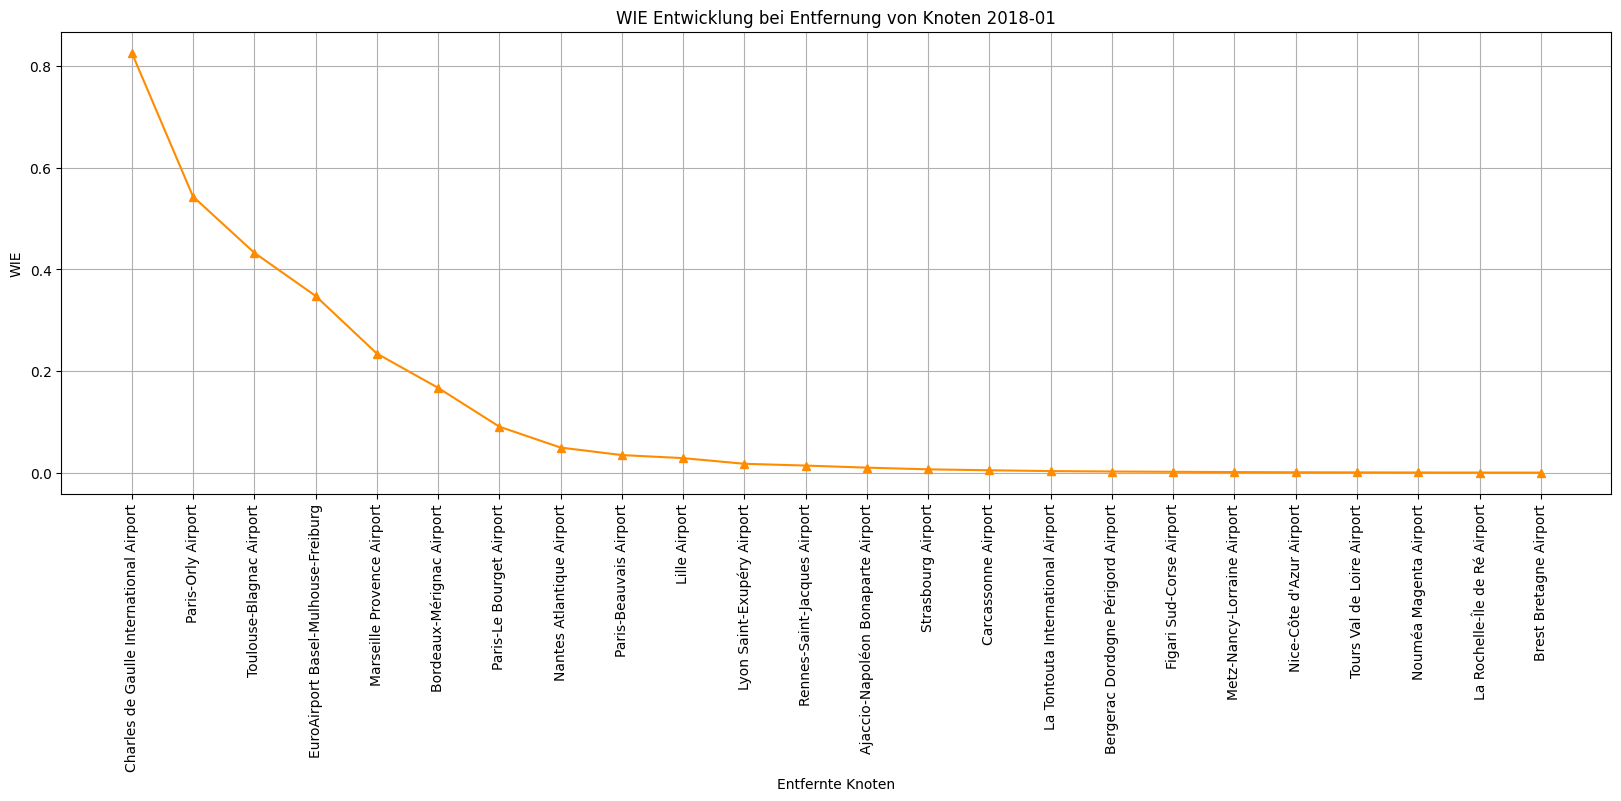

Number of nodes (airports): 444
Number of edges (flight routes): 1755, sum of weights (flights) 25744.0
Found 603 international airports to check against
WIE_post has become zero.
International robustness for 2018-02: 0.316677763916649


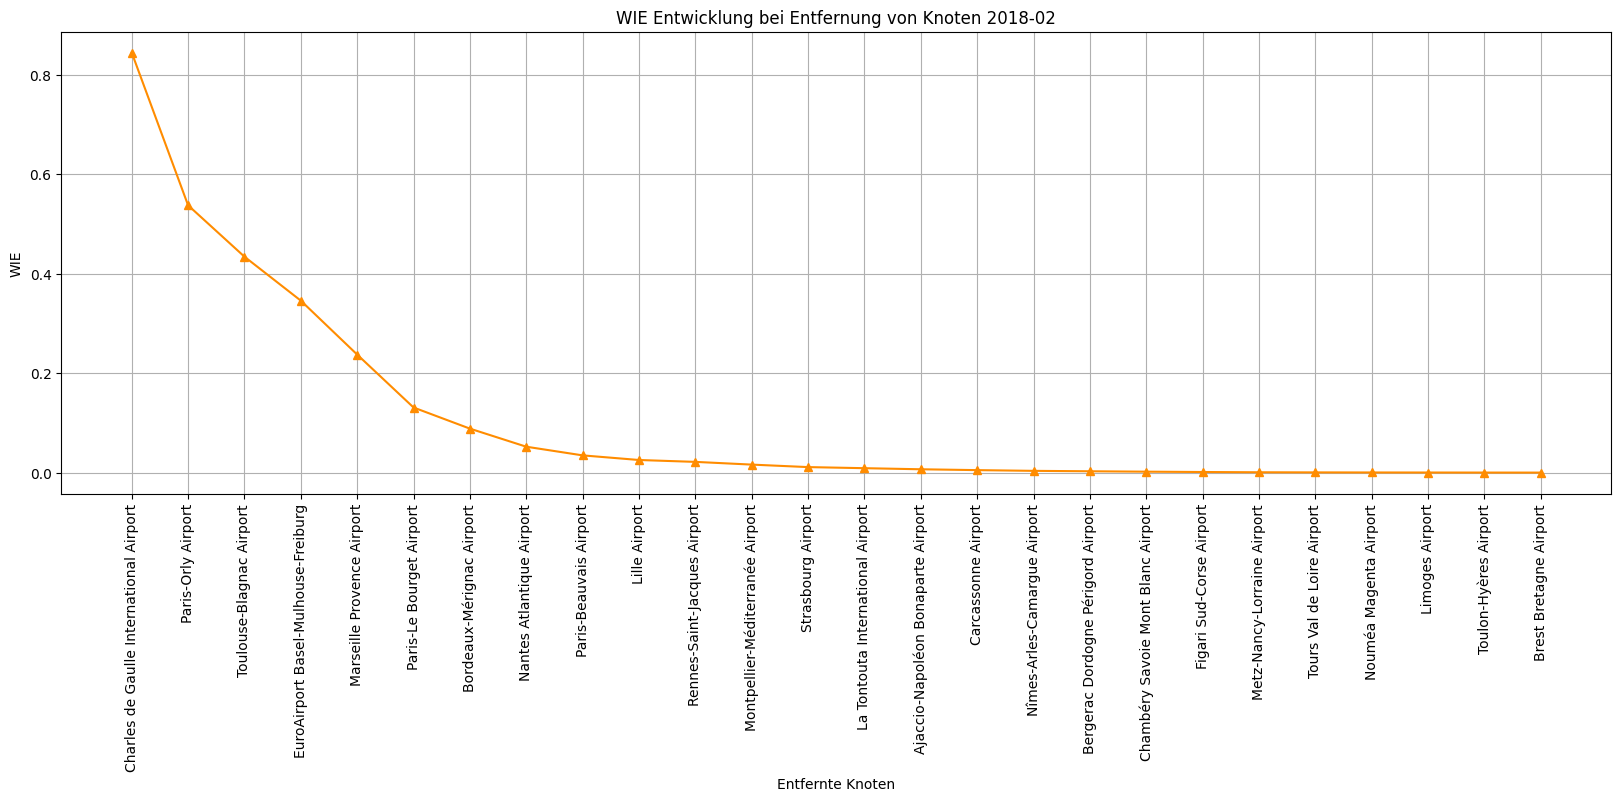

Number of nodes (airports): 496
Number of edges (flight routes): 1991, sum of weights (flights) 27023.0
Found 603 international airports to check against
WIE_post has become zero.
International robustness for 2018-03: 0.38188936324639067


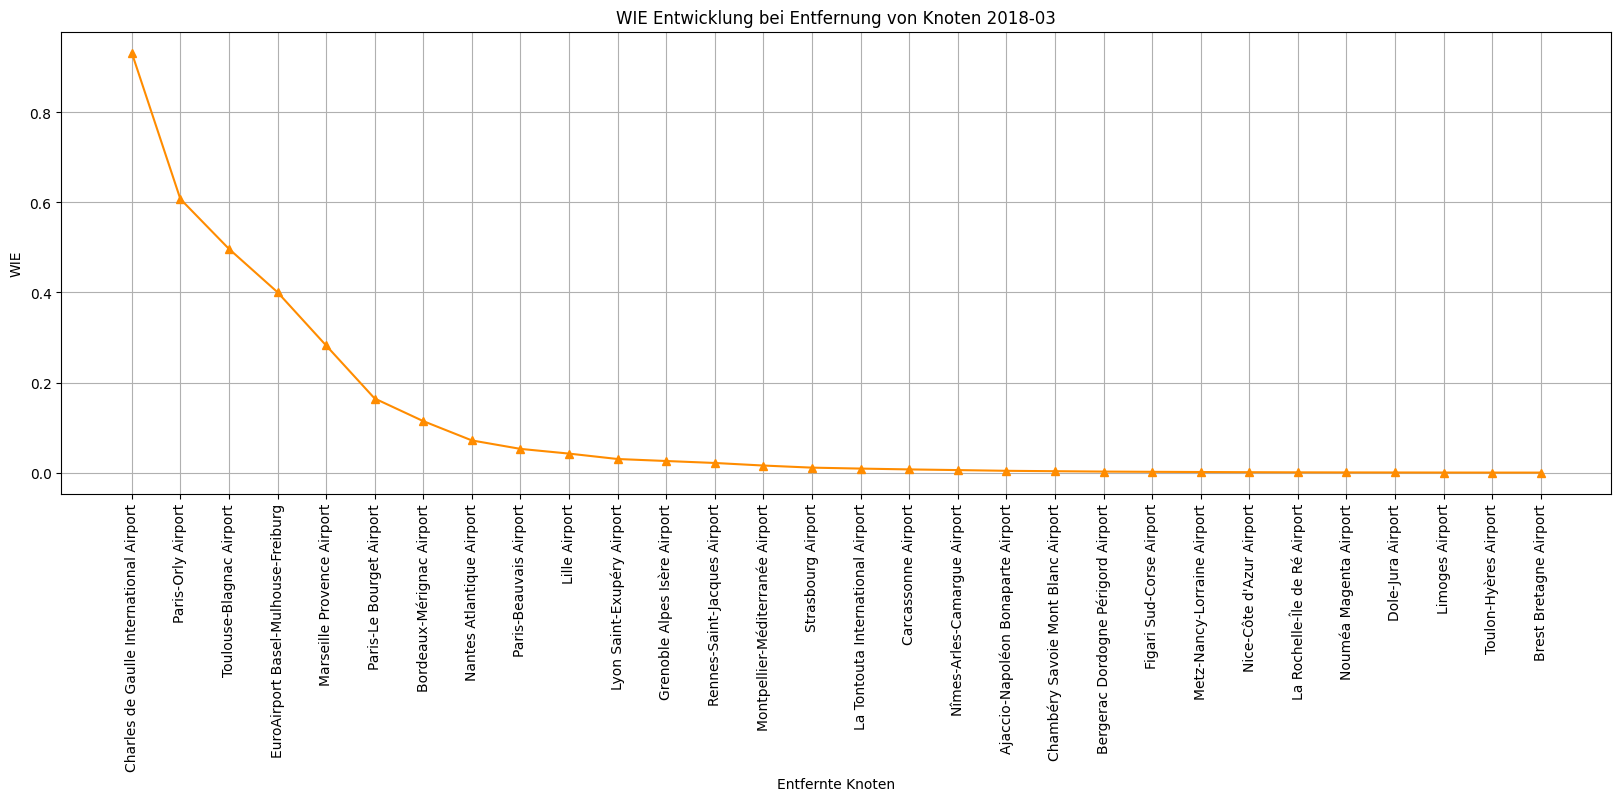

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-04-01_2018-07-01_frankreich.csv
Number of nodes (airports): 551
Number of edges (flight routes): 2707, sum of weights (flights) 30952.0
Found 952 international airports to check against
WIE_post has become zero.
International robustness for 2018-04: 0.4471583091509987


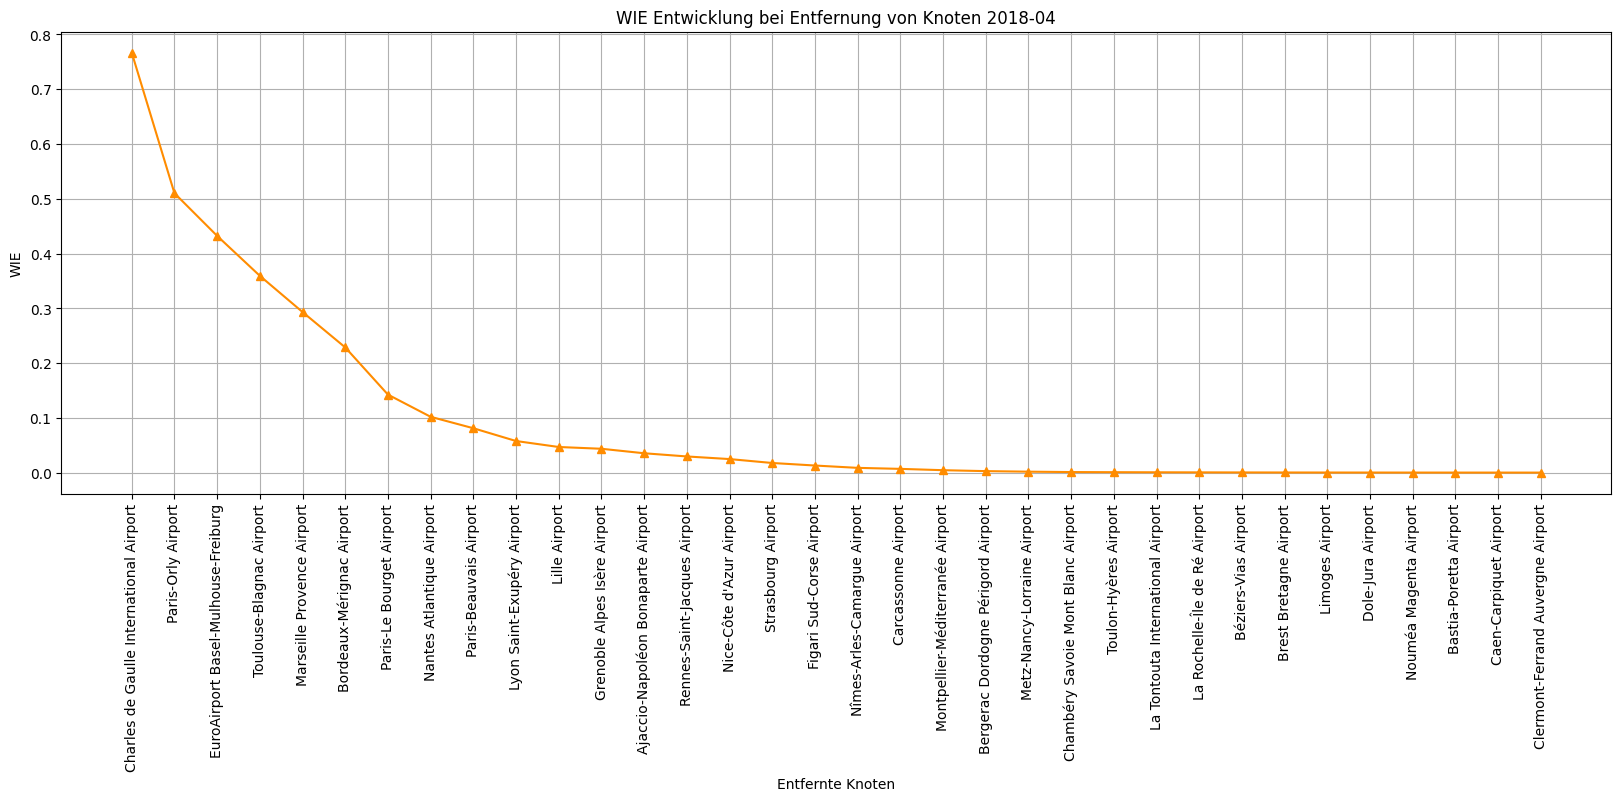

Number of nodes (airports): 640
Number of edges (flight routes): 2971, sum of weights (flights) 33483.0
Found 952 international airports to check against
WIE_post has become zero.
International robustness for 2018-05: 0.3926969433936053


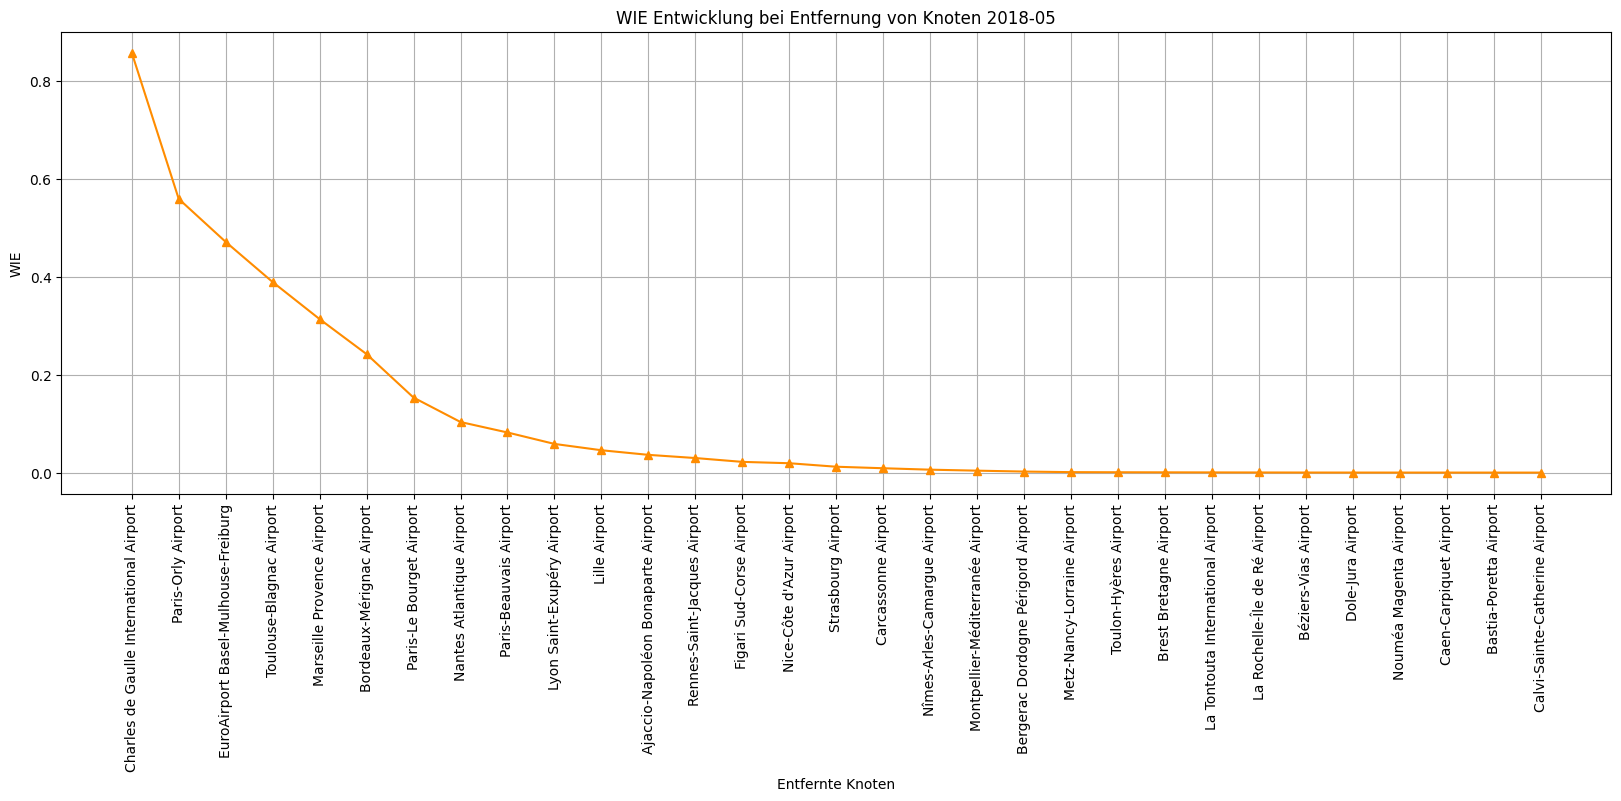

Number of nodes (airports): 740
Number of edges (flight routes): 3152, sum of weights (flights) 33775.0
Found 952 international airports to check against
WIE_post has become zero.
International robustness for 2018-06: 0.44581559033964563


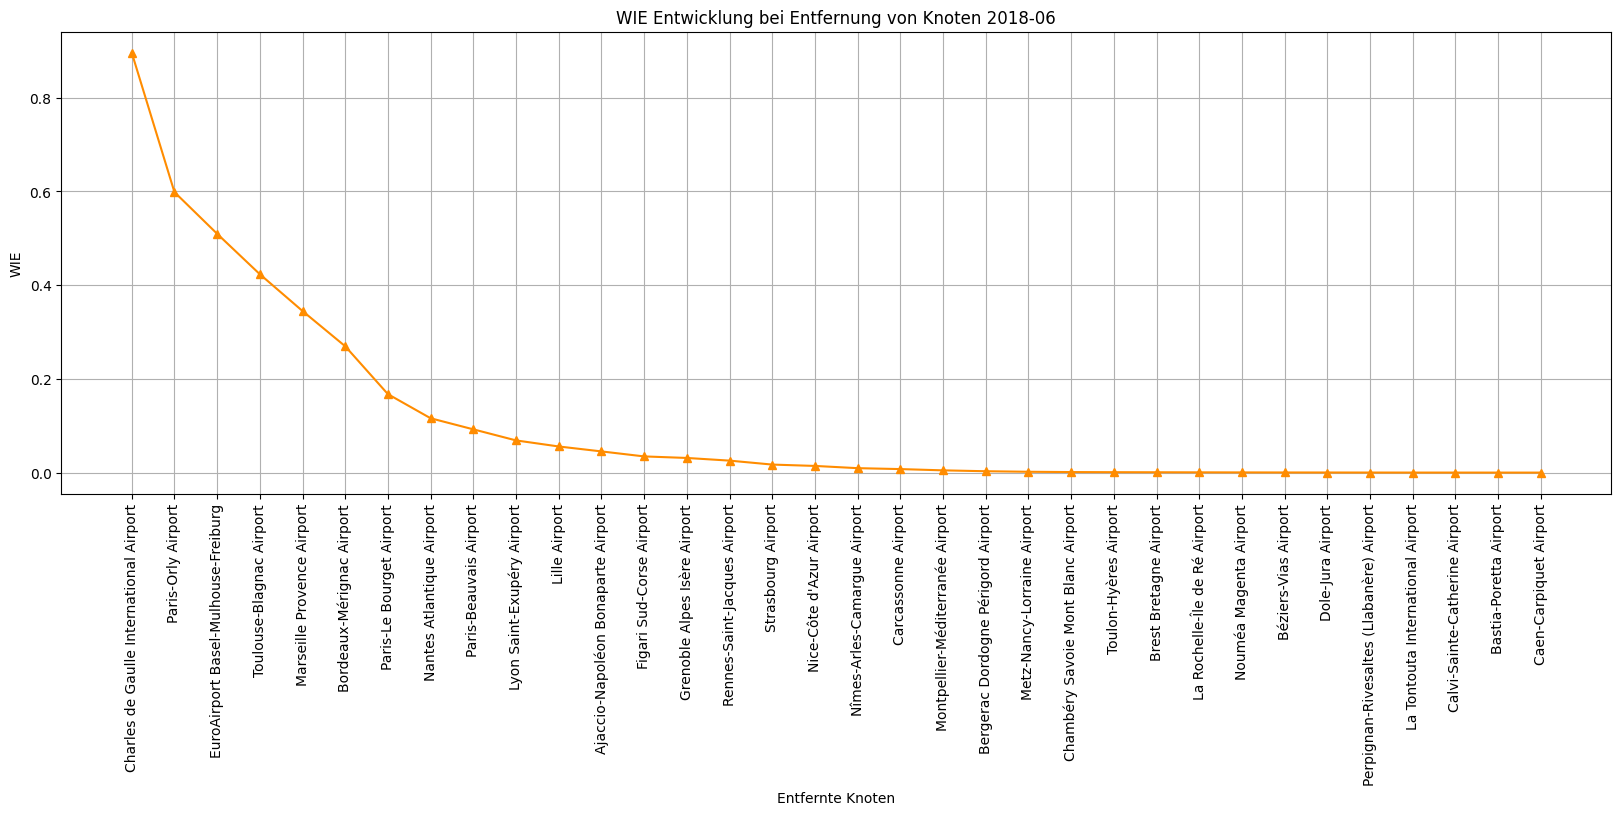

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-07-01_2018-10-01_frankreich.csv
Number of nodes (airports): 779
Number of edges (flight routes): 3344, sum of weights (flights) 29785.0
Found 1040 international airports to check against
WIE_post has become zero.
International robustness for 2018-07: 0.4988994002934173


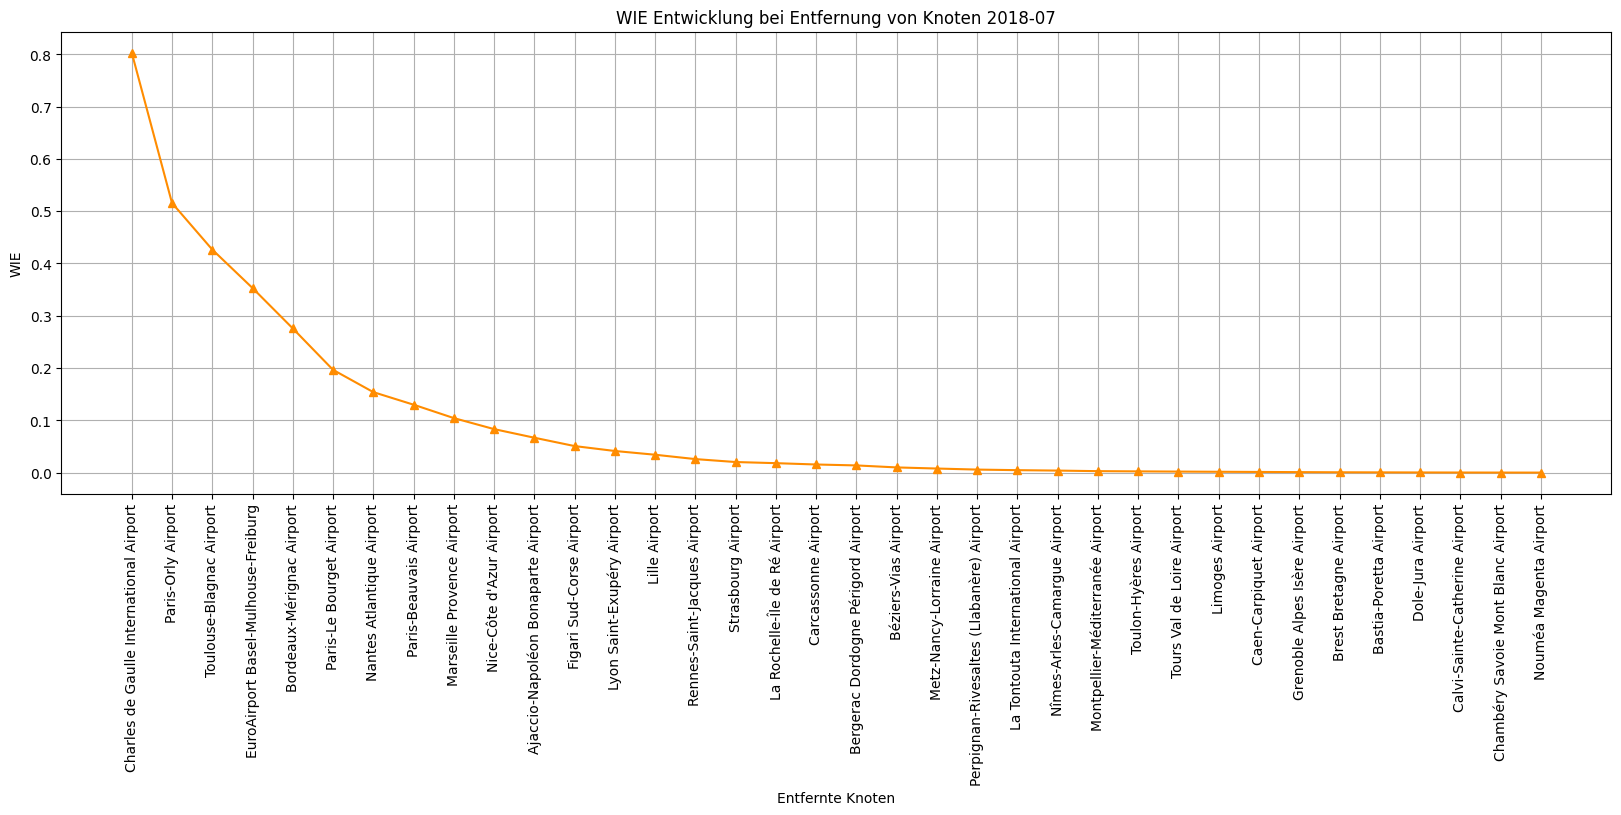

Number of nodes (airports): 715
Number of edges (flight routes): 3273, sum of weights (flights) 30303.0
Found 1040 international airports to check against
WIE_post has become zero.
International robustness for 2018-08: 0.5222356324142174


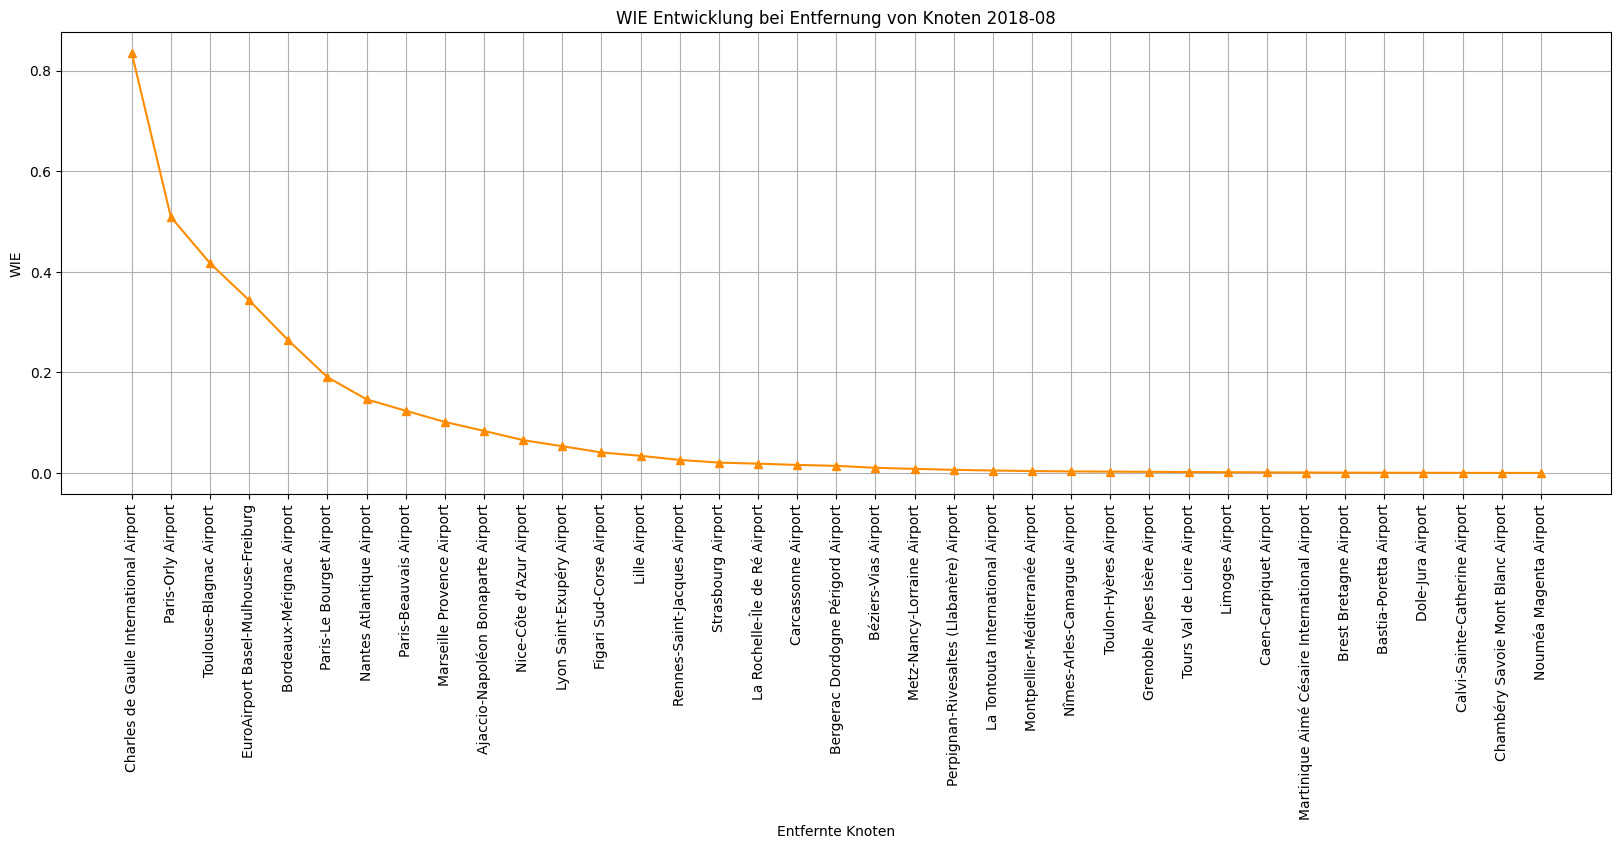

Number of nodes (airports): 716
Number of edges (flight routes): 3066, sum of weights (flights) 28890.0
Found 1040 international airports to check against
WIE_post has become zero.
International robustness for 2018-09: 0.47349818694744067


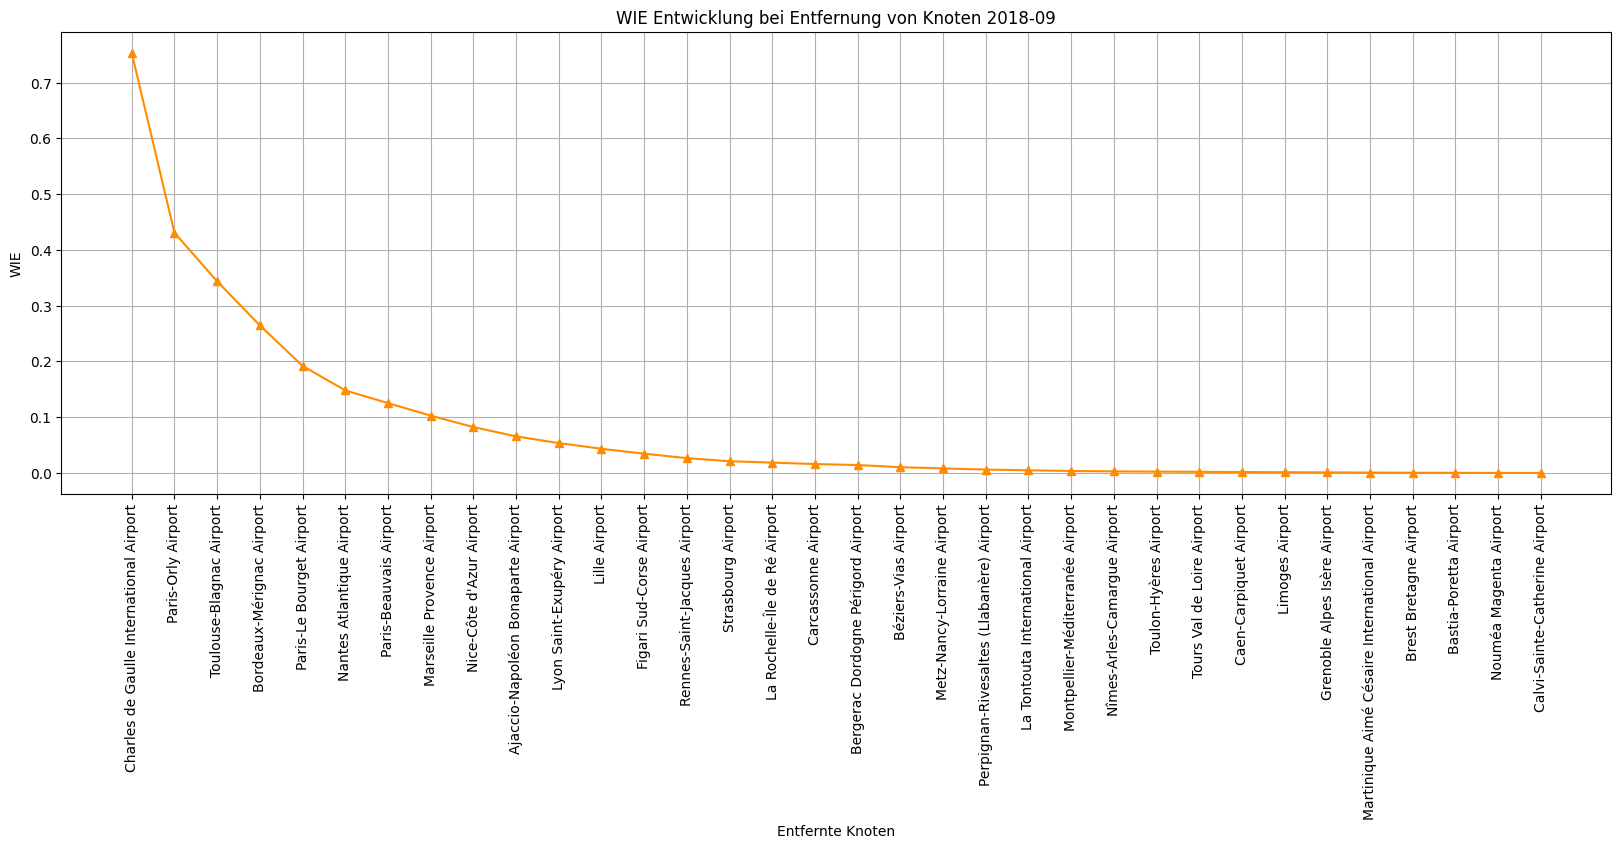

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-10-01_2019-01-01_frankreich.csv
Number of nodes (airports): 737
Number of edges (flight routes): 3069, sum of weights (flights) 30602.0
Found 957 international airports to check against
WIE_post has become zero.
International robustness for 2018-10: 0.4828535328699647


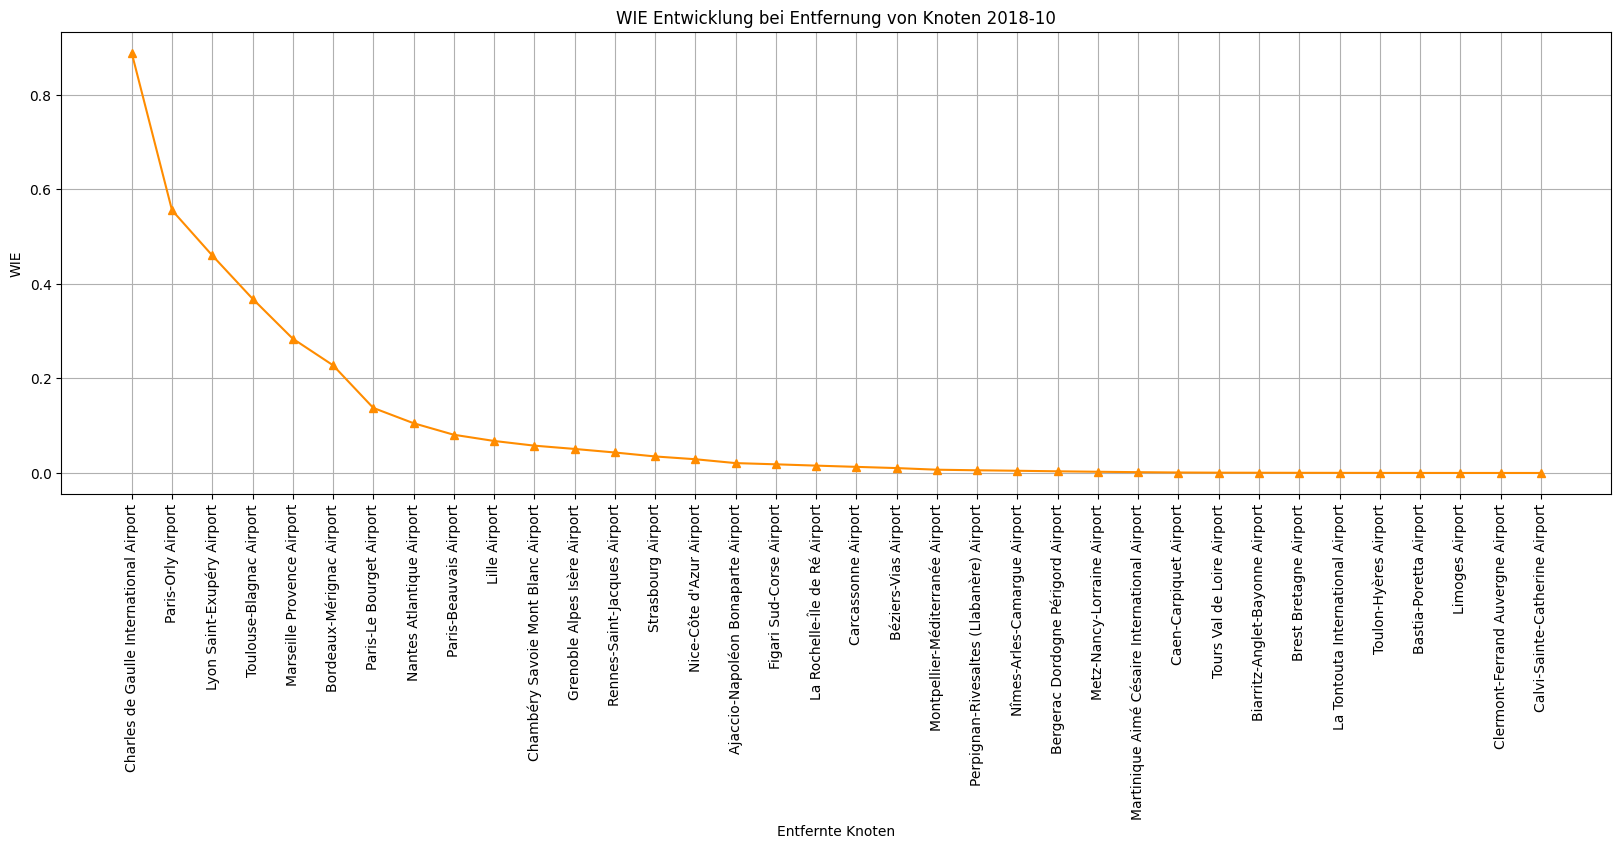

Number of nodes (airports): 636
Number of edges (flight routes): 2866, sum of weights (flights) 30085.0
Found 957 international airports to check against
WIE_post has become zero.
International robustness for 2018-11: 0.4332428920626357


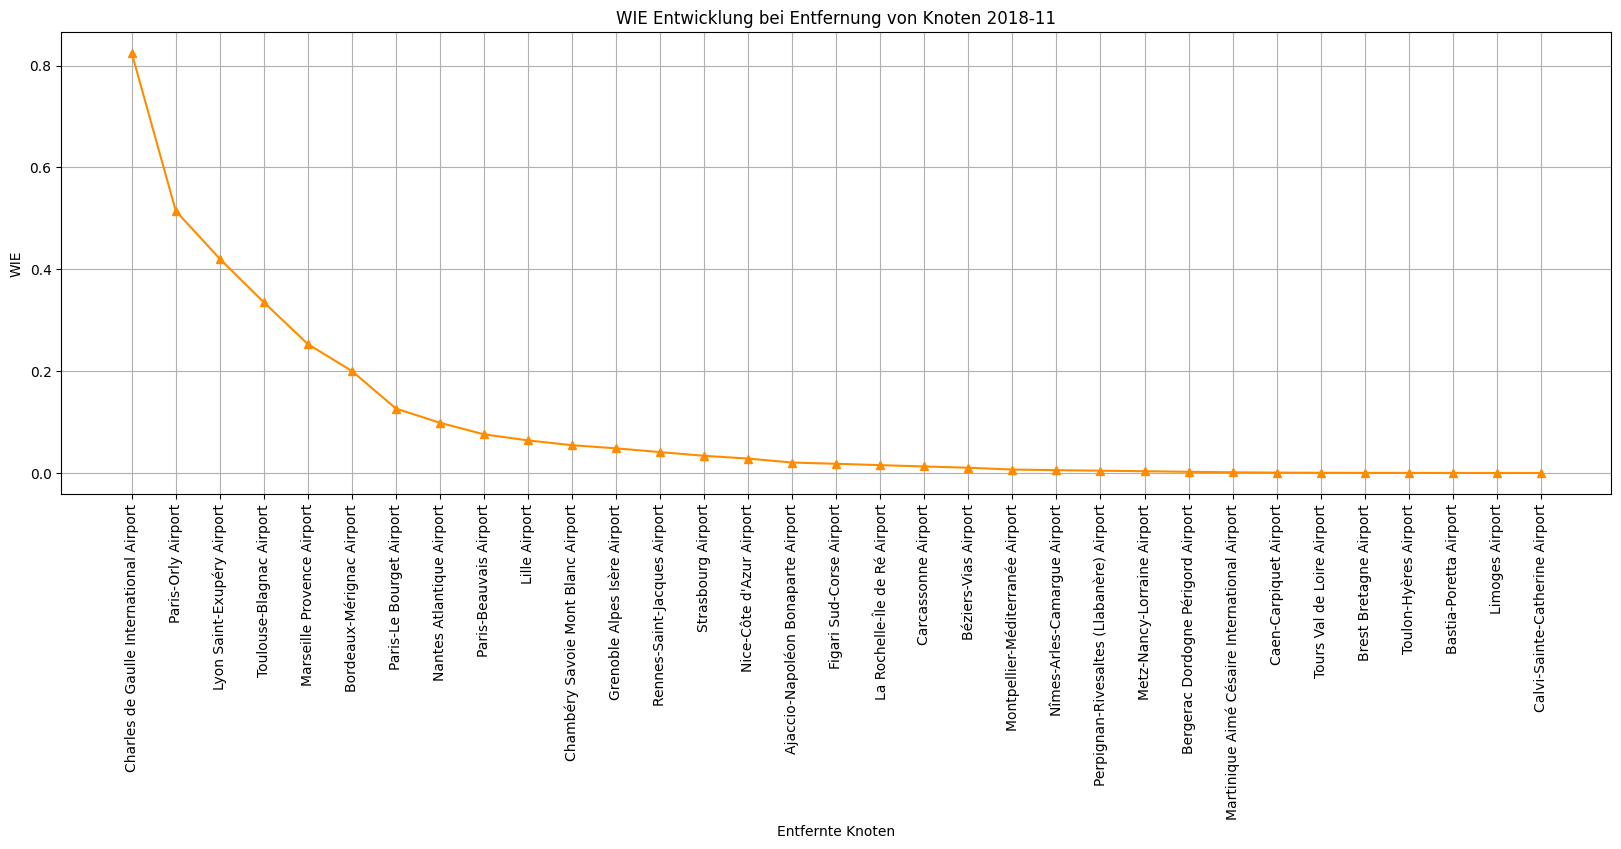

Number of nodes (airports): 626
Number of edges (flight routes): 2872, sum of weights (flights) 30139.0
Found 957 international airports to check against
WIE_post has become zero.
International robustness for 2018-12: 0.46706222288598126


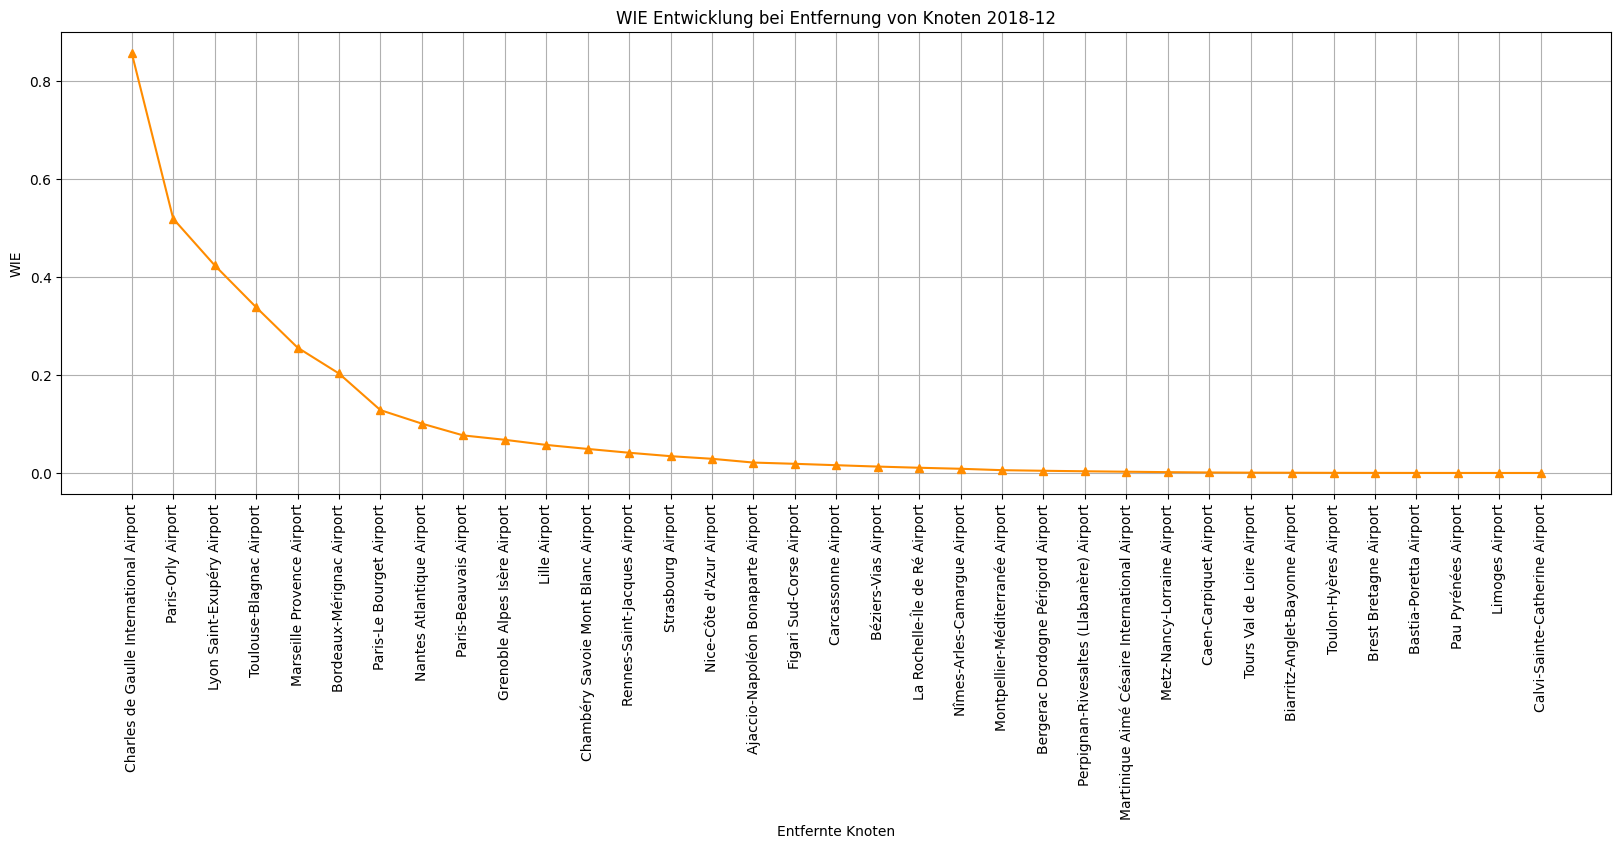

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-01-01_2019-04-01_frankreich.csv
Number of nodes (airports): 661
Number of edges (flight routes): 2697, sum of weights (flights) 31851.0
Found 947 international airports to check against
WIE_post has become zero.
International robustness for 2019-01: 0.444679691511474


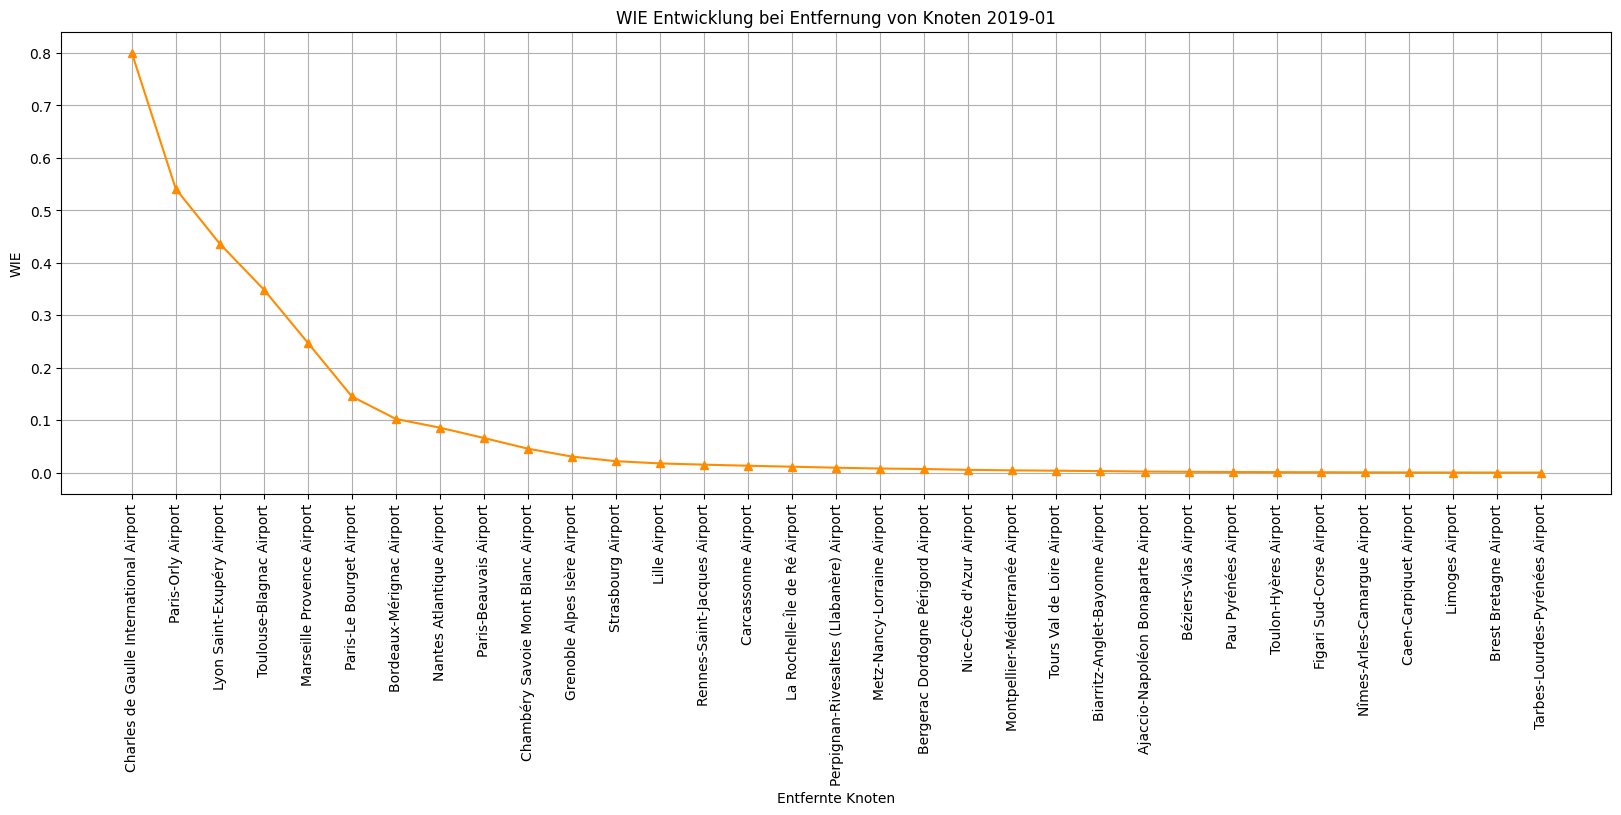

Number of nodes (airports): 655
Number of edges (flight routes): 2691, sum of weights (flights) 31923.0
Found 947 international airports to check against
WIE_post has become zero.
International robustness for 2019-02: 0.43374143492967676


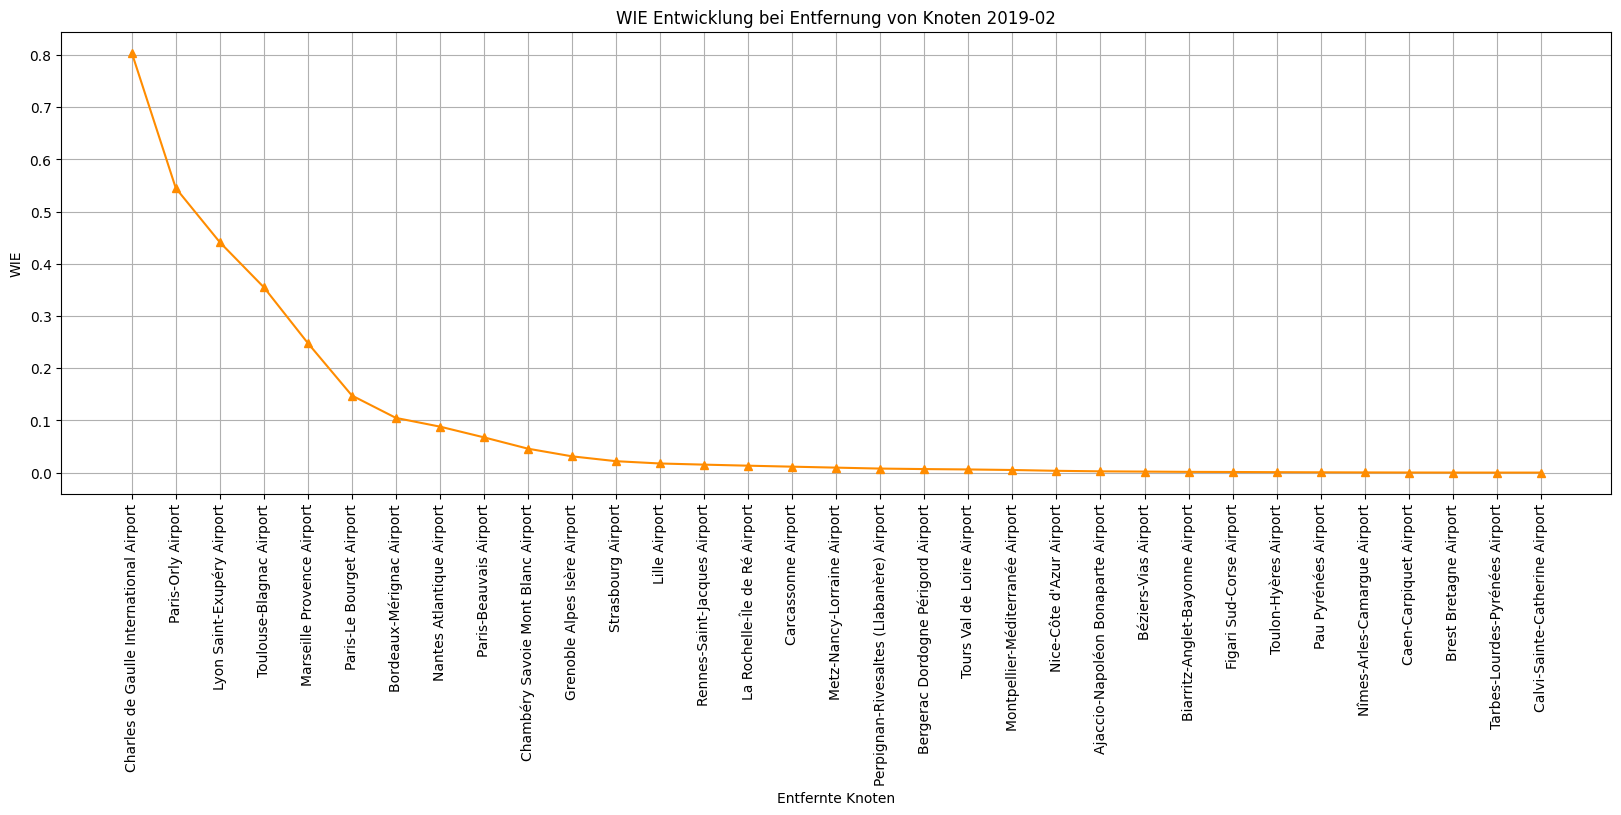

Number of nodes (airports): 686
Number of edges (flight routes): 2755, sum of weights (flights) 32200.0
Found 947 international airports to check against
WIE_post has become zero.
International robustness for 2019-03: 0.4524491693377123


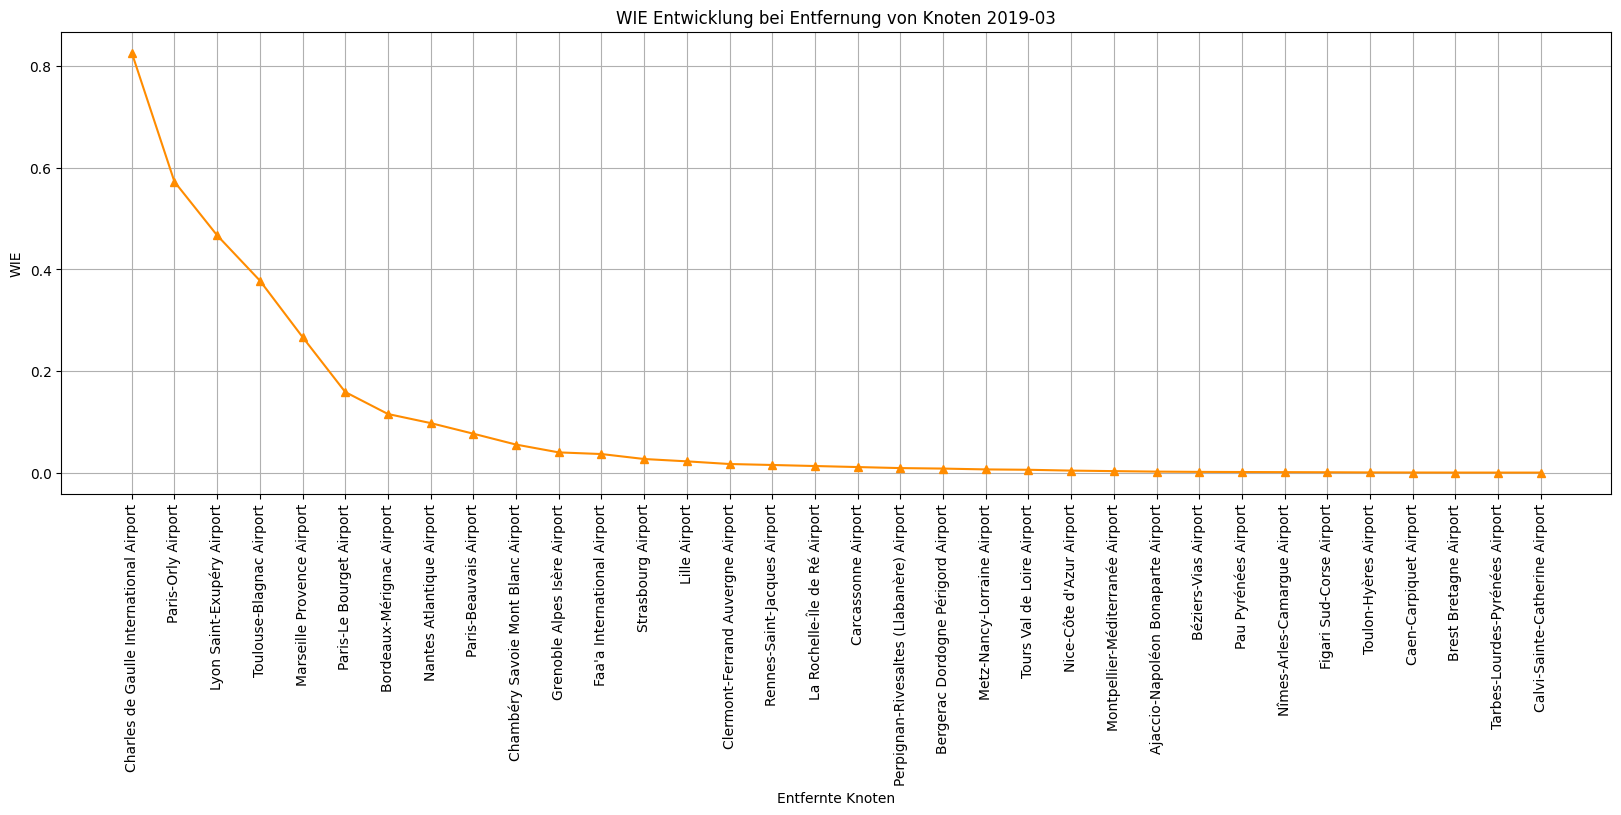

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-04-01_2019-07-01_frankreich.csv
Number of nodes (airports): 726
Number of edges (flight routes): 3371, sum of weights (flights) 36160.0
Found 1082 international airports to check against
WIE_post has become zero.
International robustness for 2019-04: 0.44678400668020657


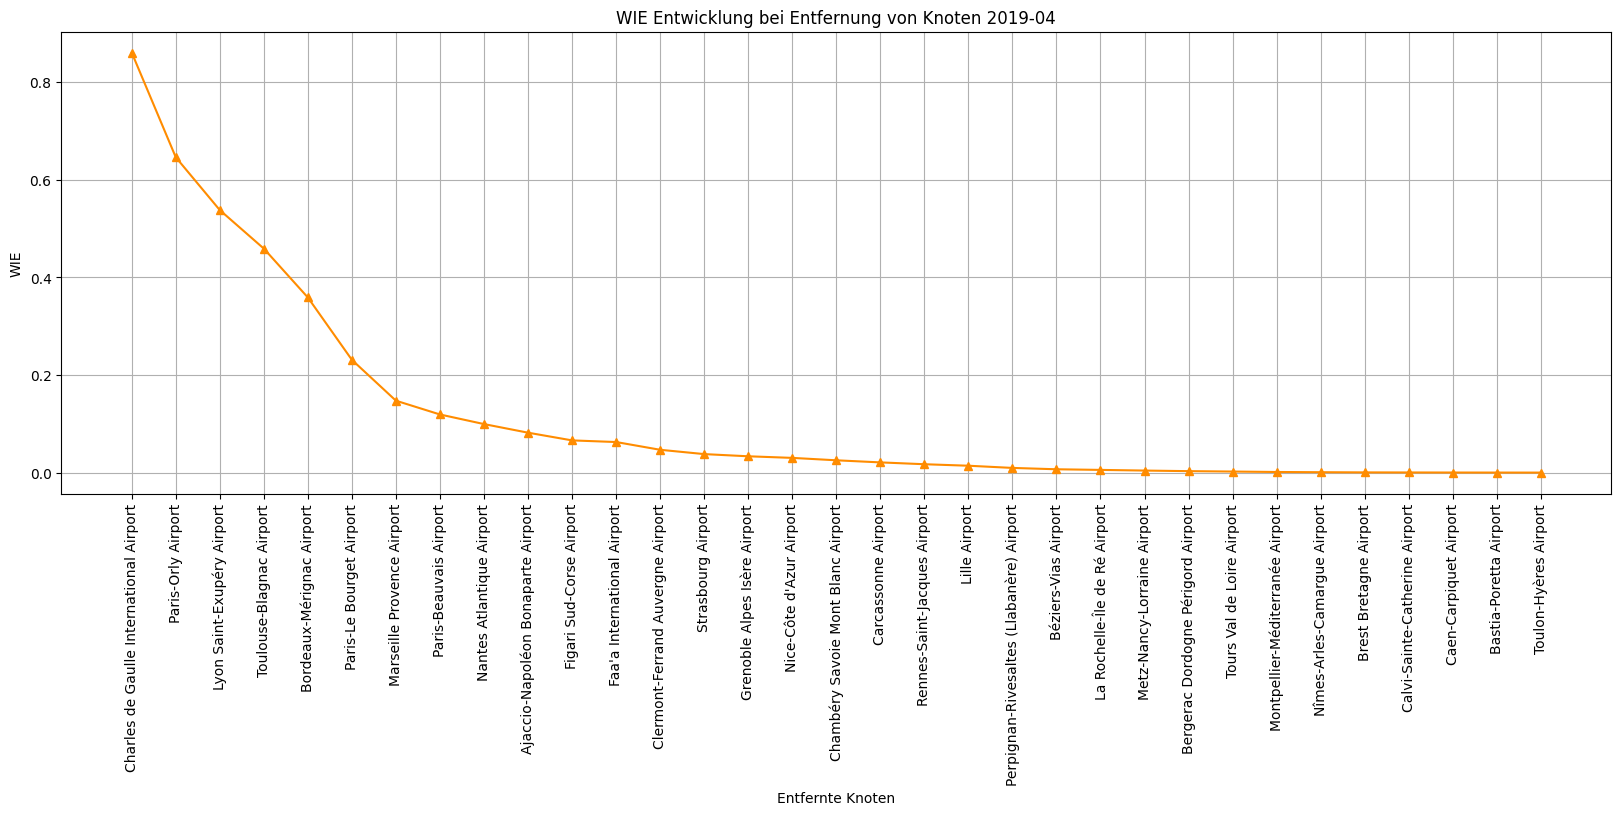

Number of nodes (airports): 740
Number of edges (flight routes): 3376, sum of weights (flights) 36317.0
Found 1082 international airports to check against
WIE_post has become zero.
International robustness for 2019-05: 0.4291099539695806


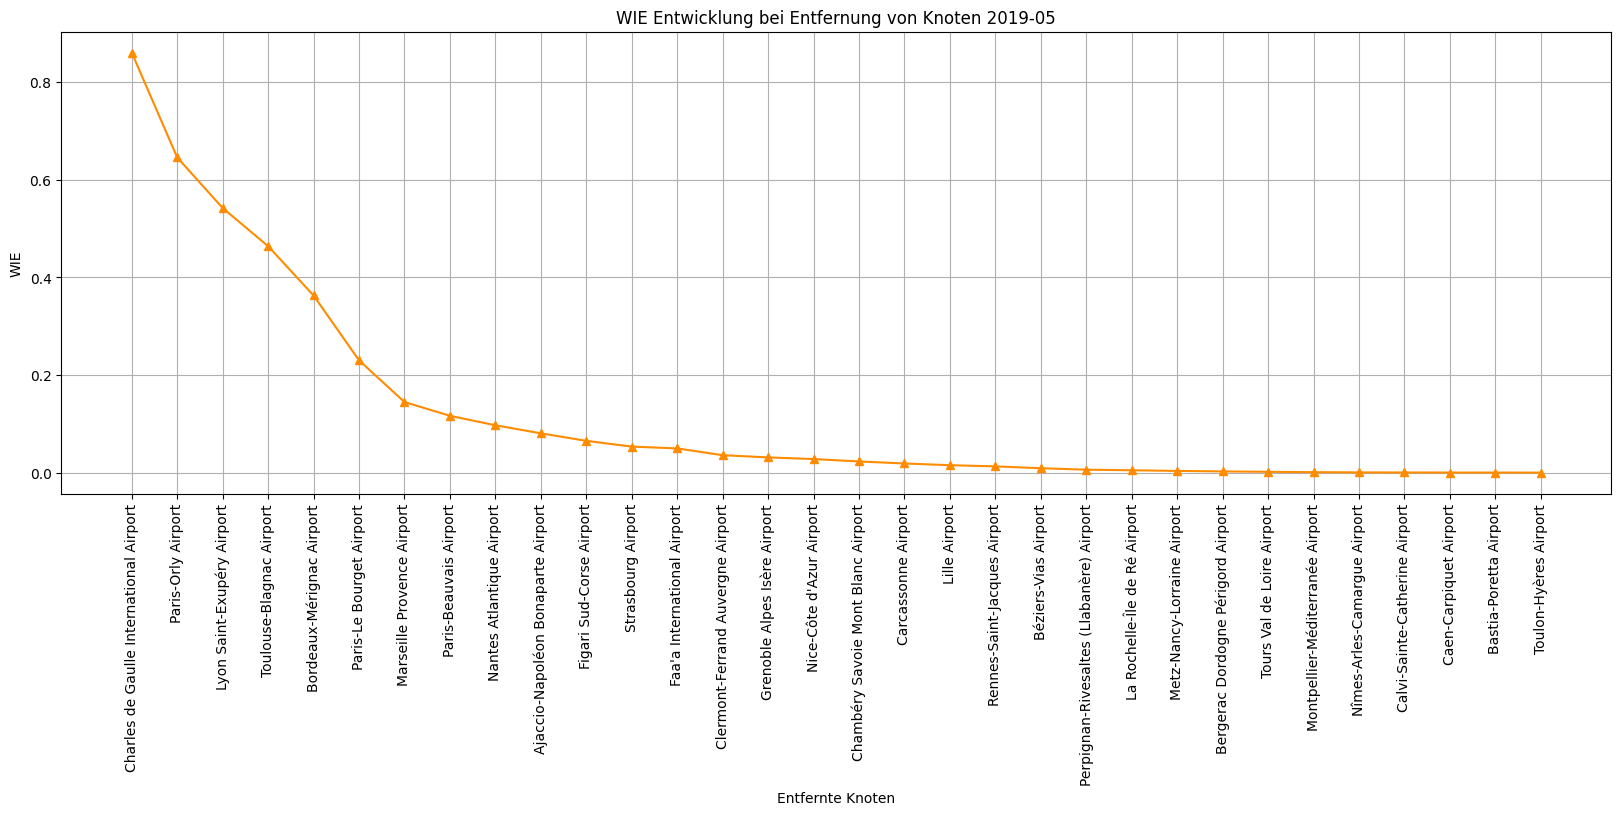

Number of nodes (airports): 840
Number of edges (flight routes): 3525, sum of weights (flights) 36545.0
Found 1082 international airports to check against
WIE_post has become zero.
International robustness for 2019-06: 0.4467256803868955


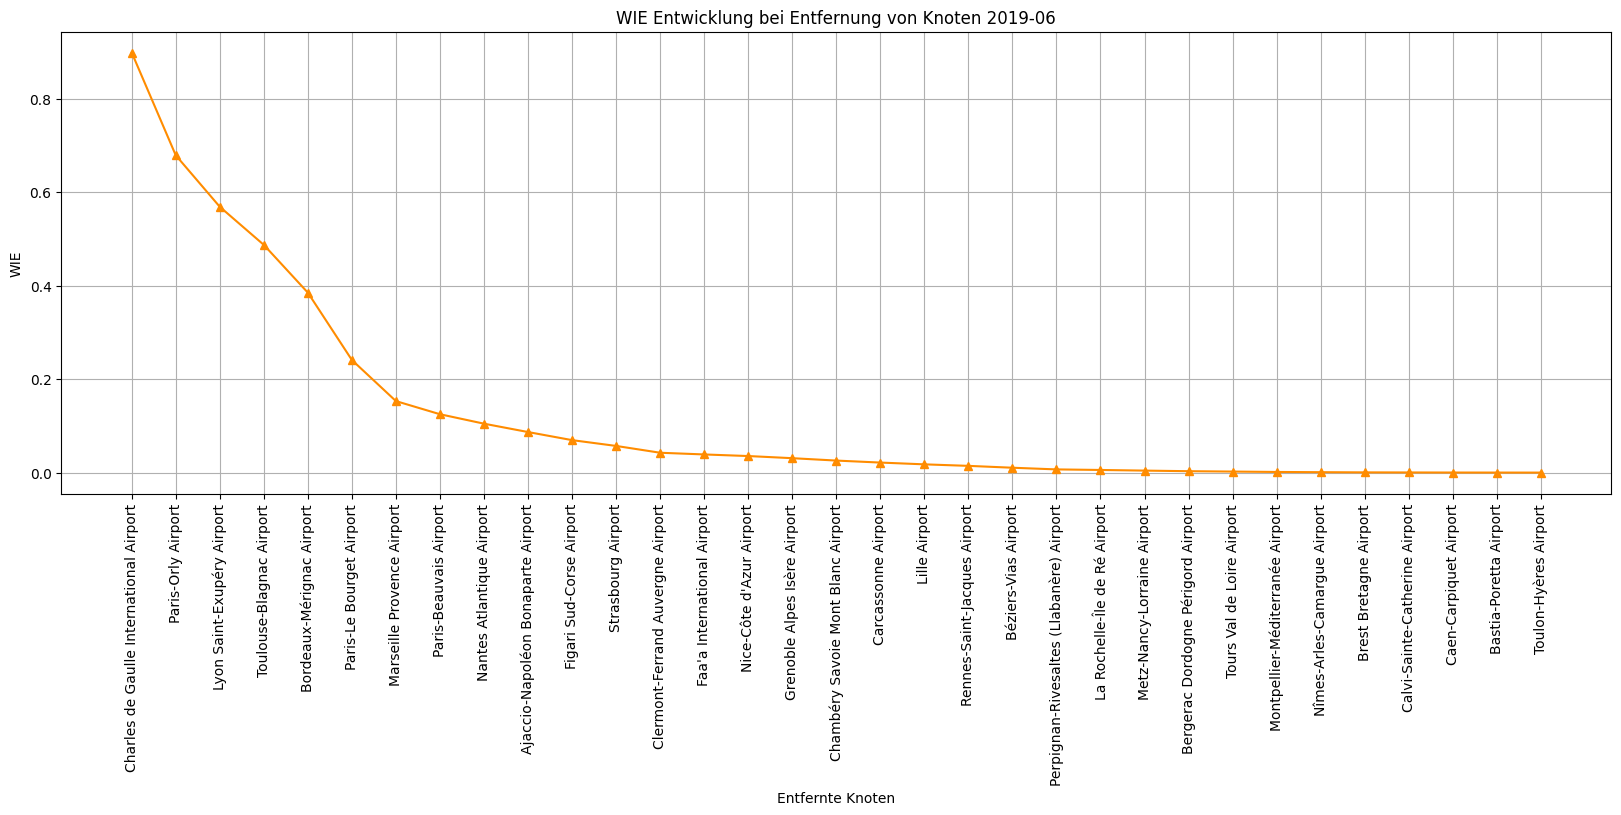

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-07-01_2019-10-01_frankreich.csv
Number of nodes (airports): 767
Number of edges (flight routes): 3664, sum of weights (flights) 37008.0
Found 1029 international airports to check against
WIE_post has become zero.
International robustness for 2019-07: 0.4509619205616717


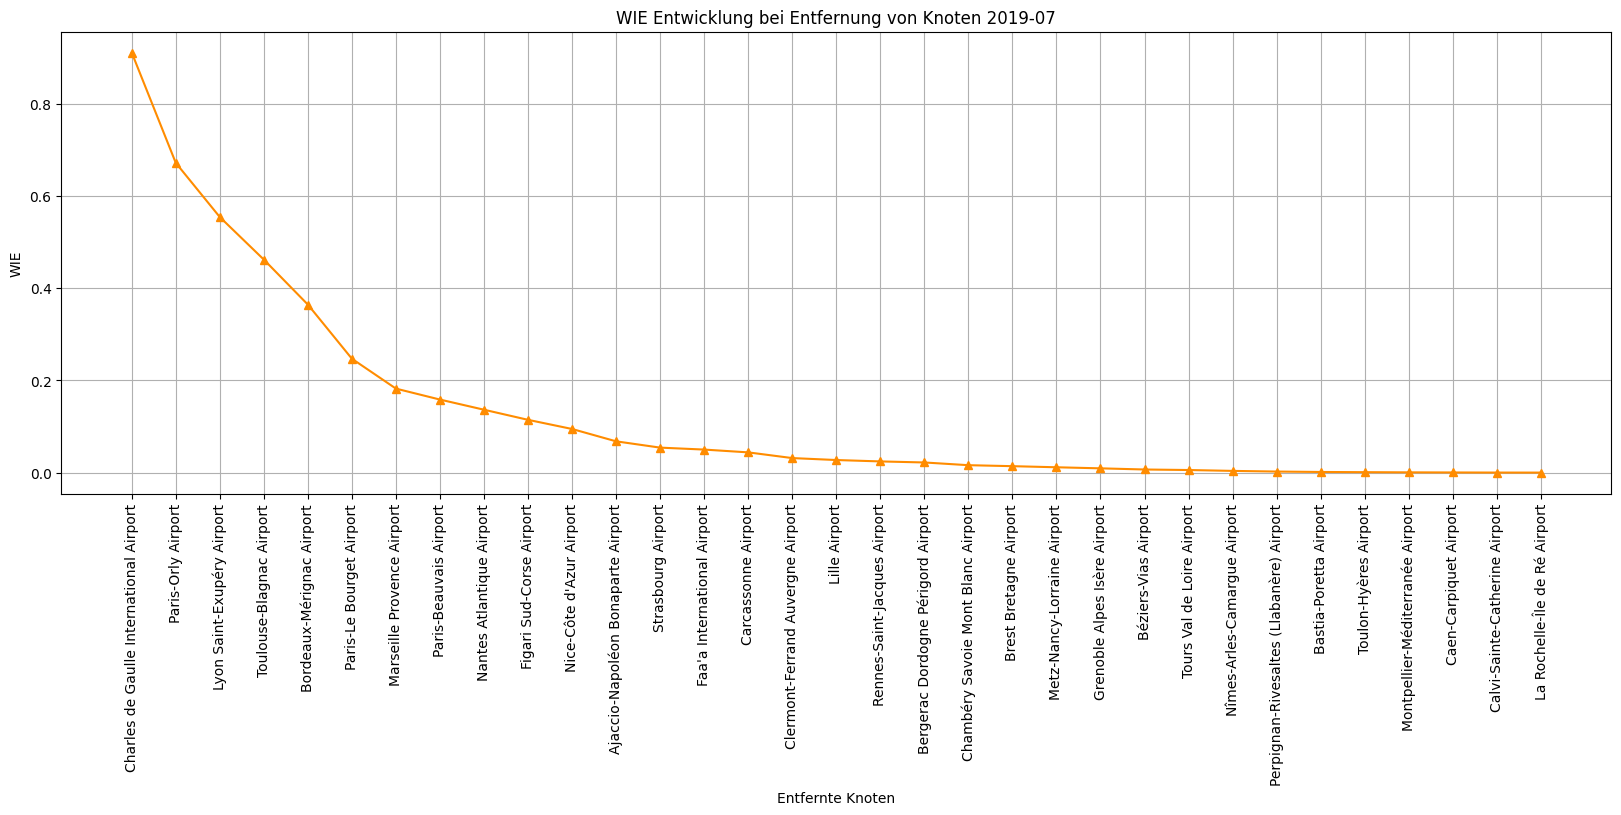

Number of nodes (airports): 719
Number of edges (flight routes): 3566, sum of weights (flights) 36836.0
Found 1029 international airports to check against
WIE_post has become zero.
International robustness for 2019-08: 0.45070197324644246


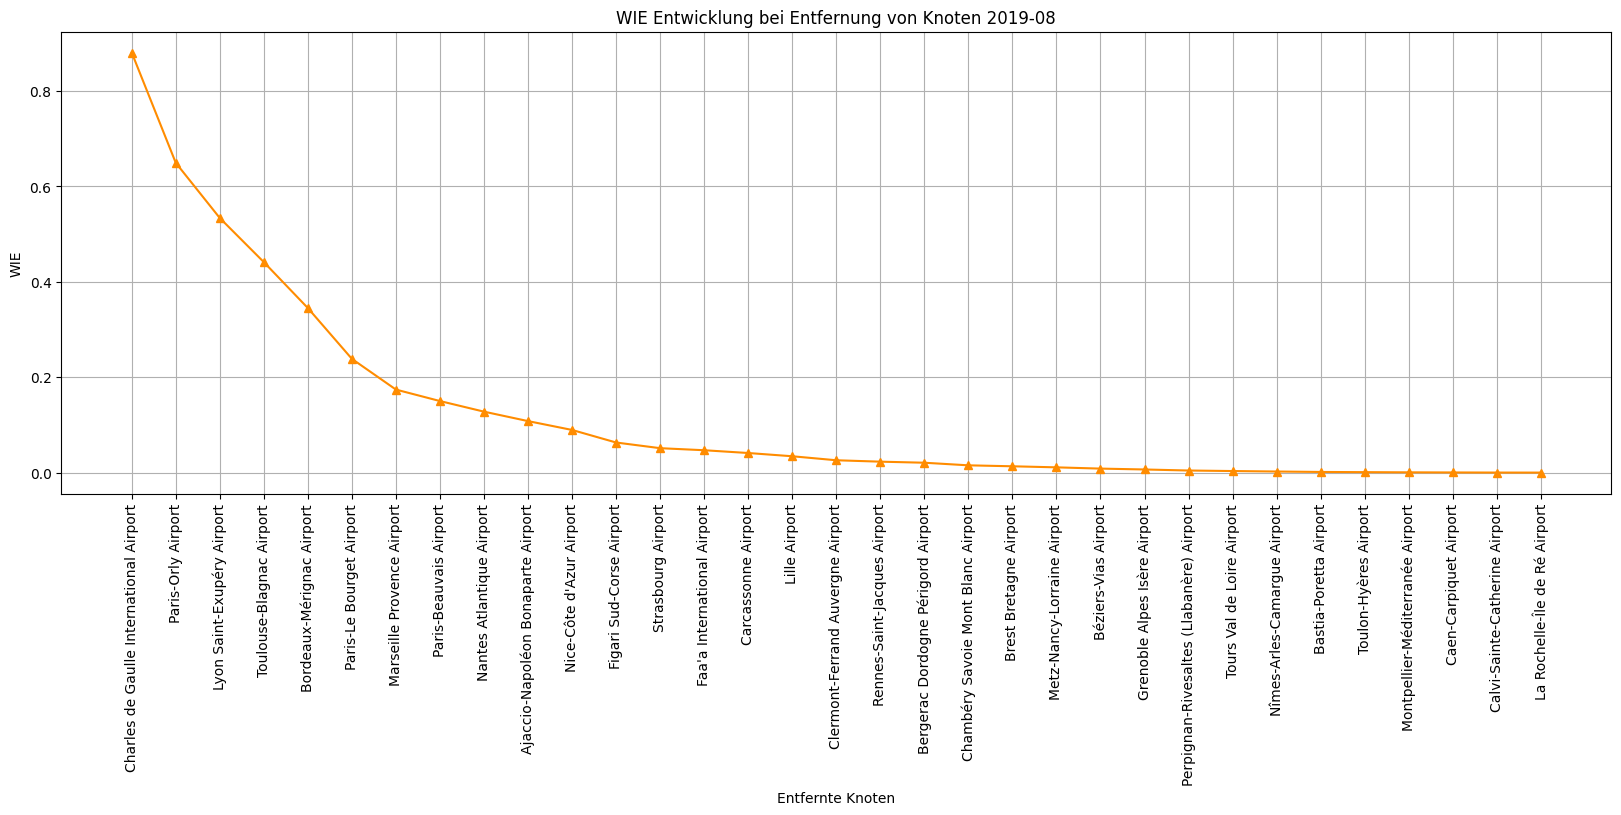

Number of nodes (airports): 782
Number of edges (flight routes): 3665, sum of weights (flights) 36898.0
Found 1029 international airports to check against
WIE_post has become zero.
International robustness for 2019-09: 0.46556288632896353


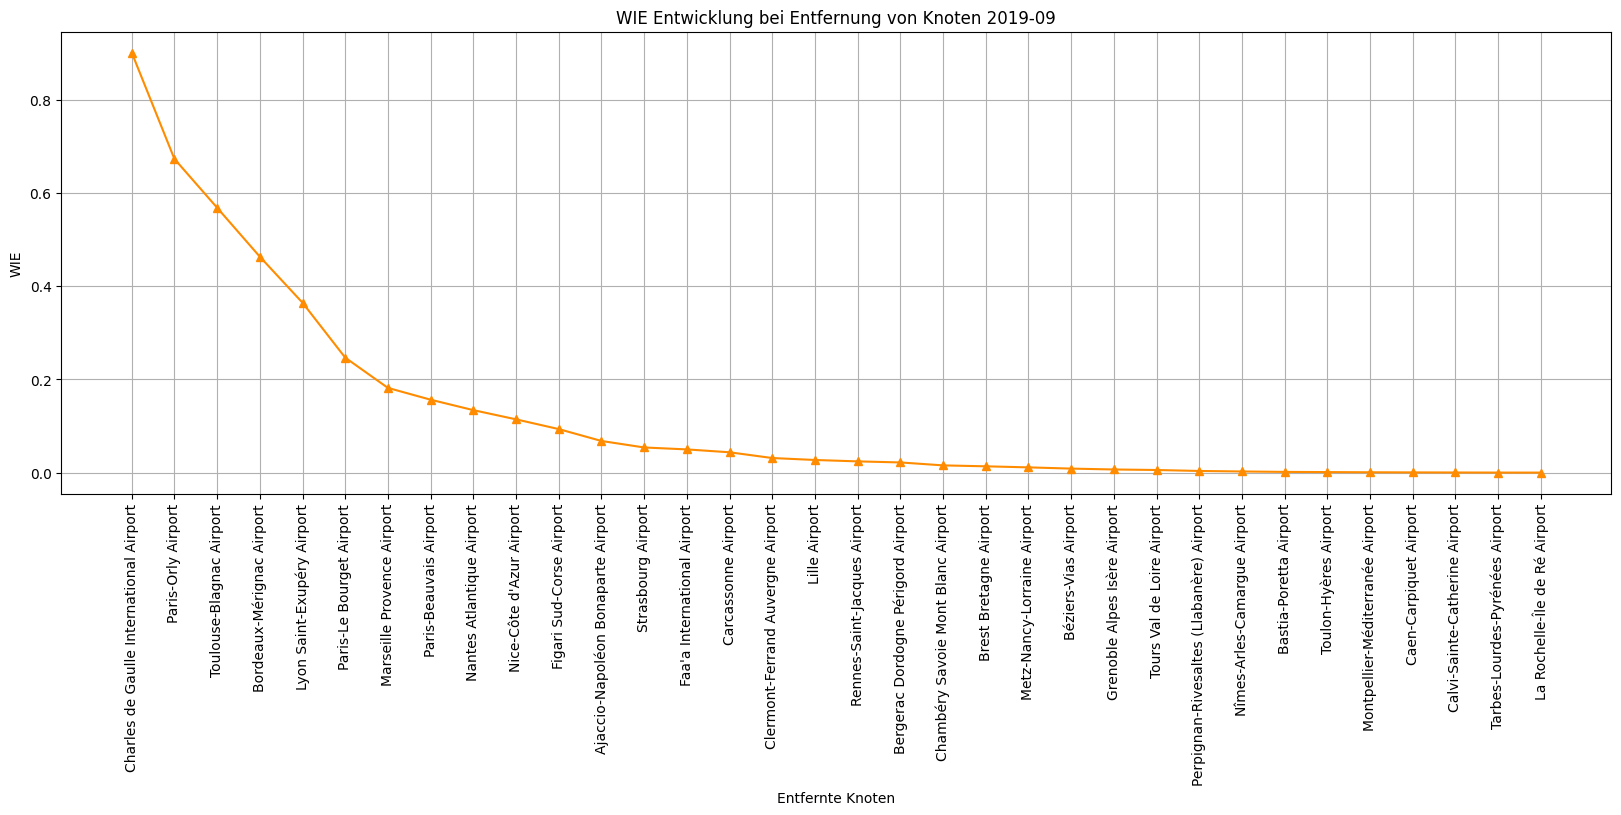

/content/drive/My Drive/2024KomplexeNetze/Daten/2019-10-01_2020-01-01_frankreich.csv
Number of nodes (airports): 756
Number of edges (flight routes): 3161, sum of weights (flights) 32591.0
Found 955 international airports to check against
WIE_post has become zero.
International robustness for 2019-10: 0.41296909915379976


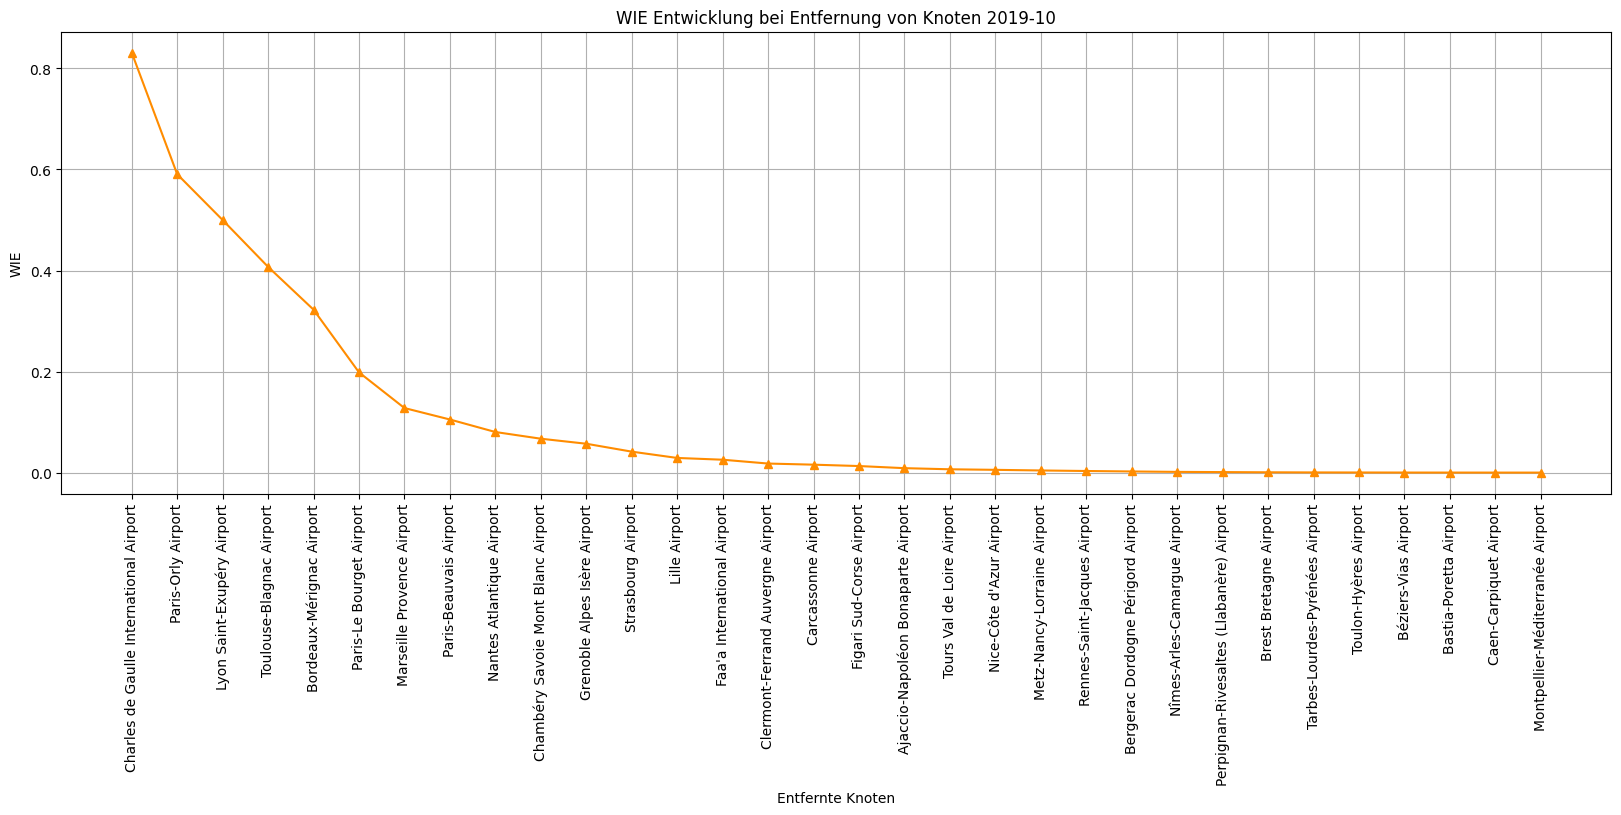

Number of nodes (airports): 648
Number of edges (flight routes): 2999, sum of weights (flights) 32340.0
Found 955 international airports to check against
WIE_post has become zero.
International robustness for 2019-11: 0.40328103344526595


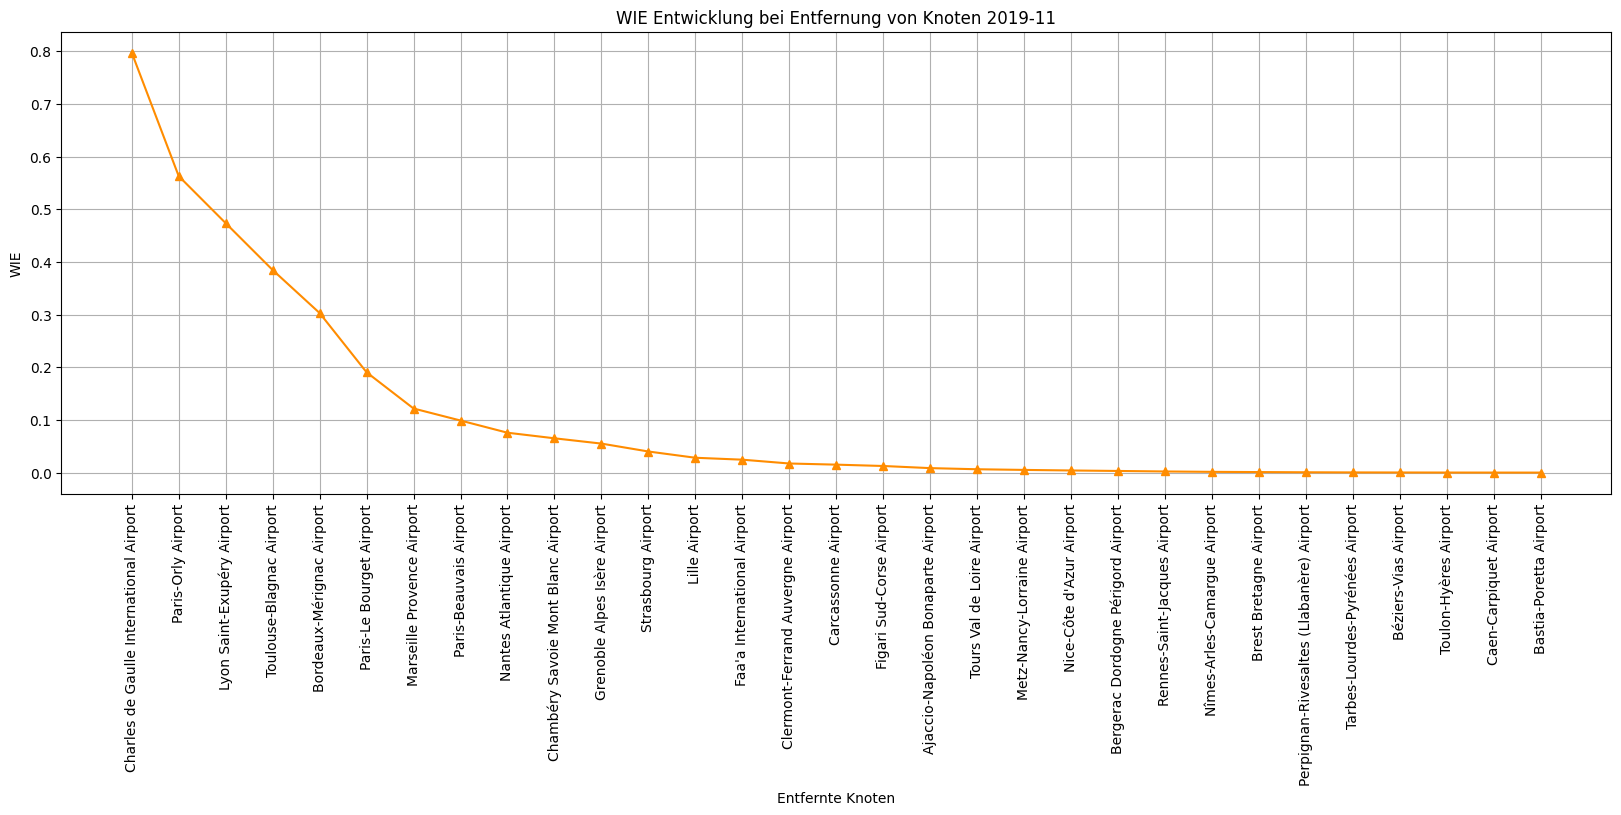

Number of nodes (airports): 658
Number of edges (flight routes): 2804, sum of weights (flights) 31799.0
Found 955 international airports to check against
WIE_post has become zero.
International robustness for 2019-12: 0.3755064911712116


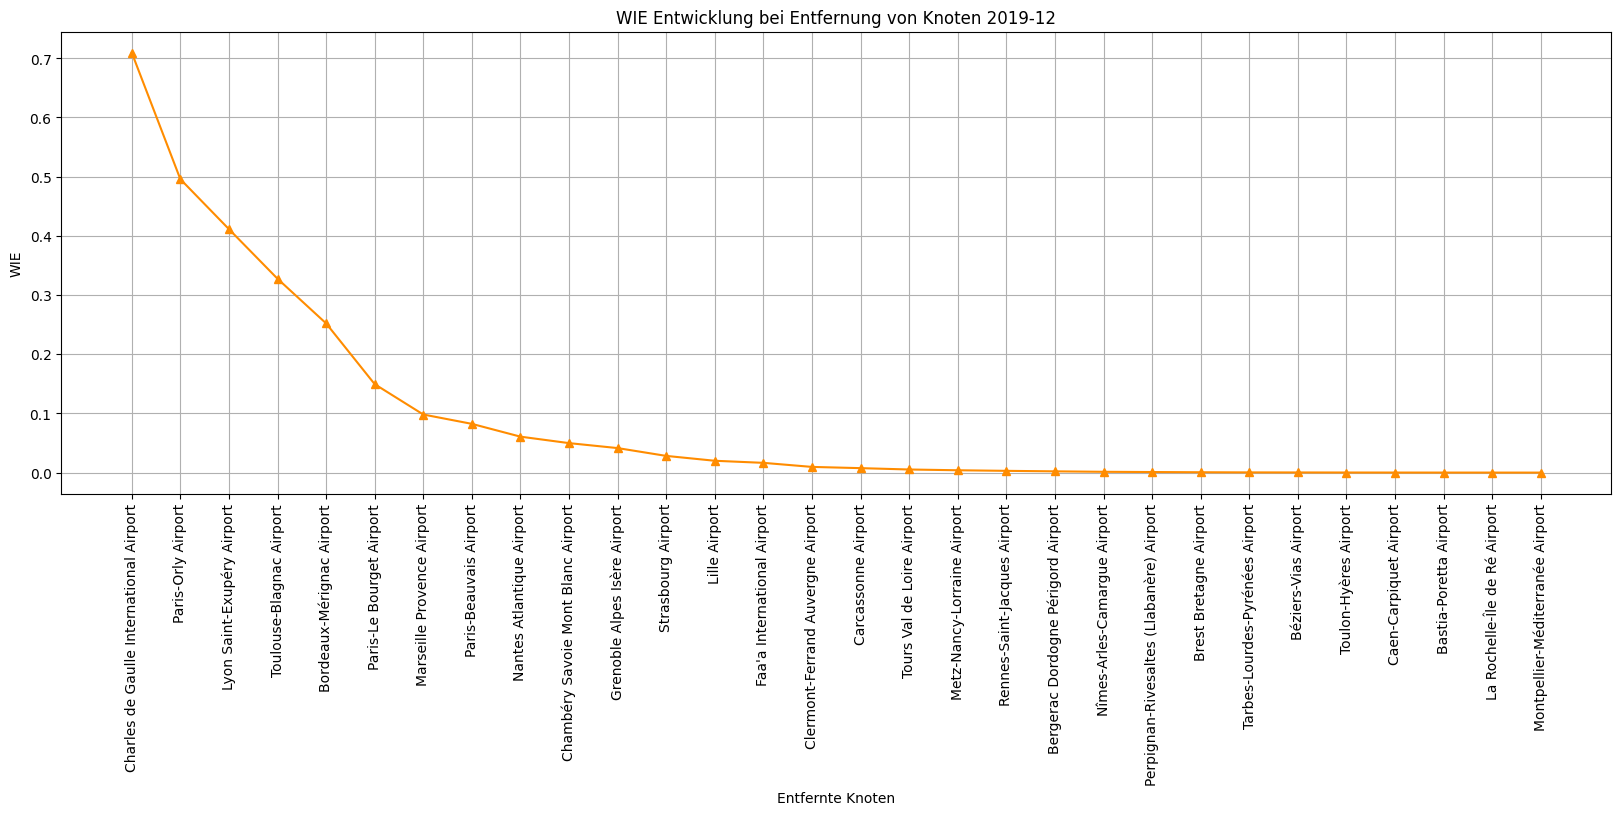

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-01-01_2023-04-01_frankreich.csv
Number of nodes (airports): 740
Number of edges (flight routes): 4045, sum of weights (flights) 38251.0
Found 1015 international airports to check against
WIE_post has become zero.
International robustness for 2023-01: 0.4801066305835852


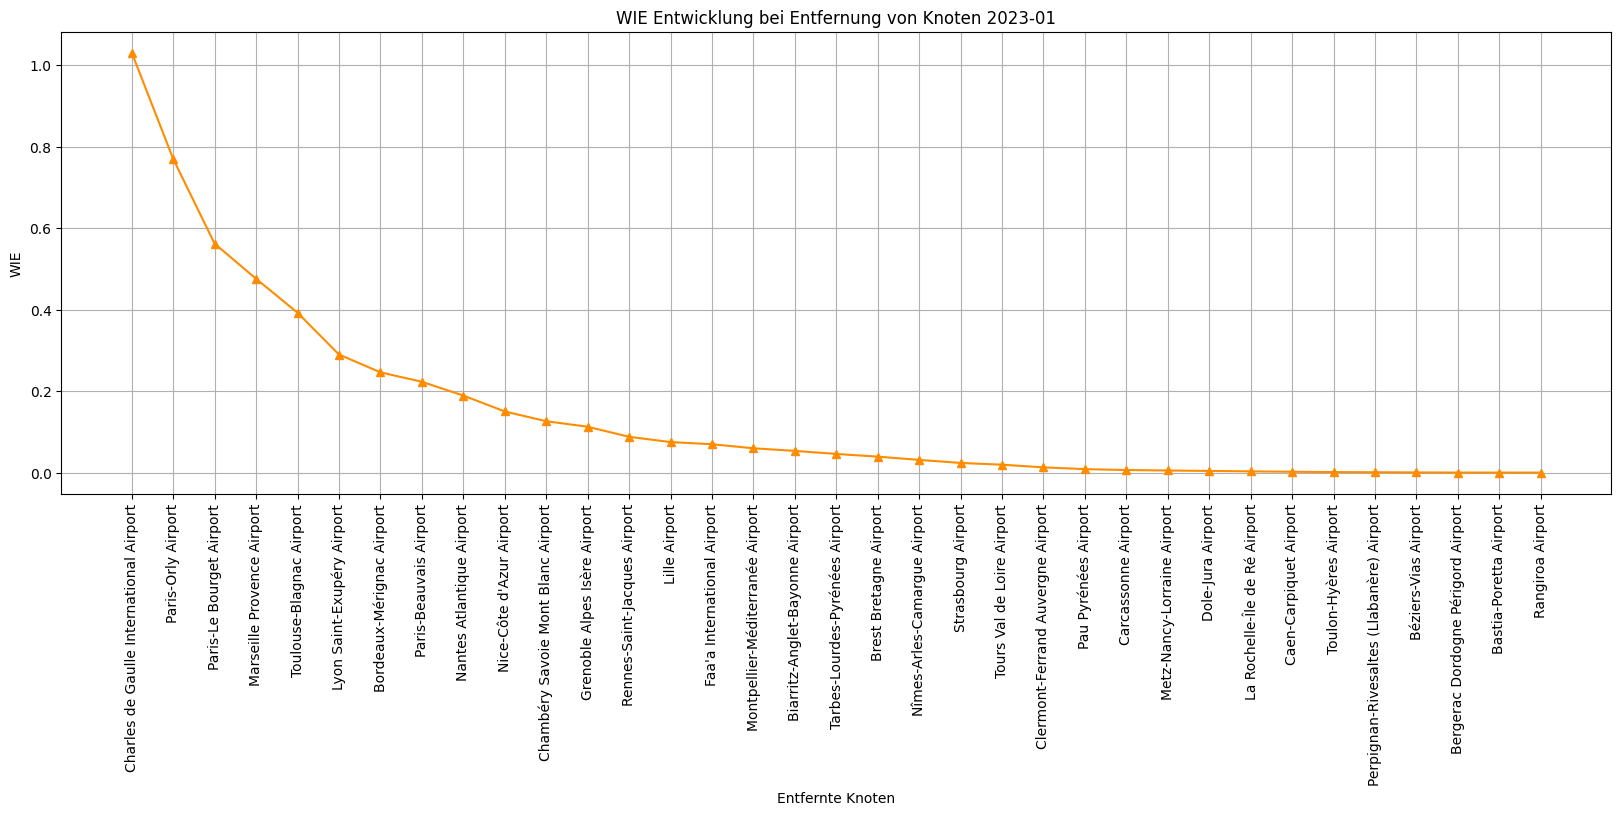

Number of nodes (airports): 756
Number of edges (flight routes): 4078, sum of weights (flights) 38308.0
Found 1015 international airports to check against
WIE_post has become zero.
International robustness for 2023-02: 0.4758813192104096


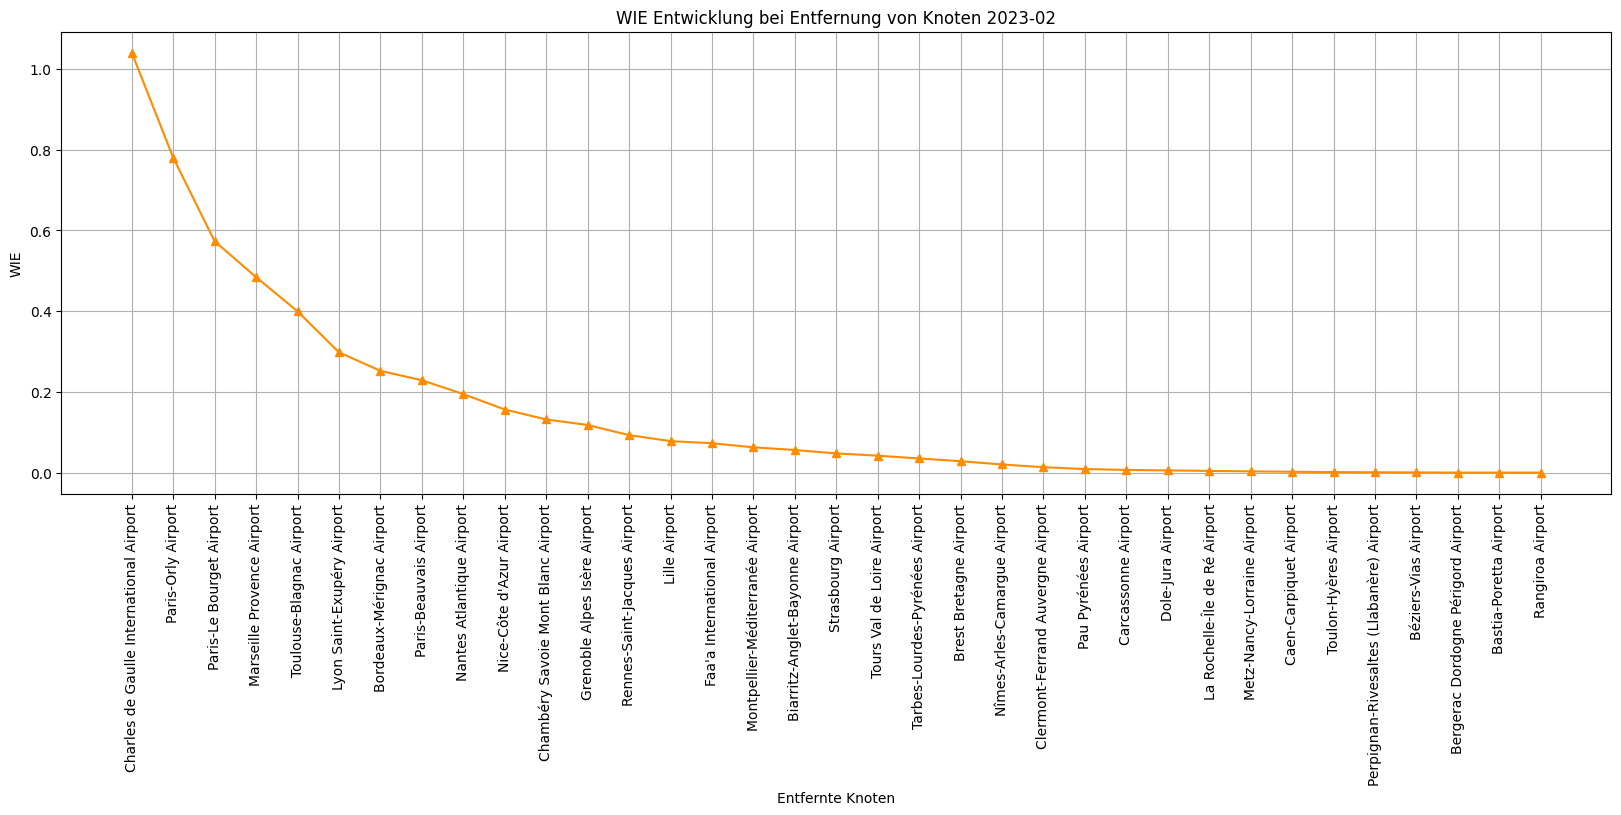

Number of nodes (airports): 783
Number of edges (flight routes): 4133, sum of weights (flights) 38354.0
Found 1015 international airports to check against
WIE_post has become zero.
International robustness for 2023-03: 0.4801444100827687


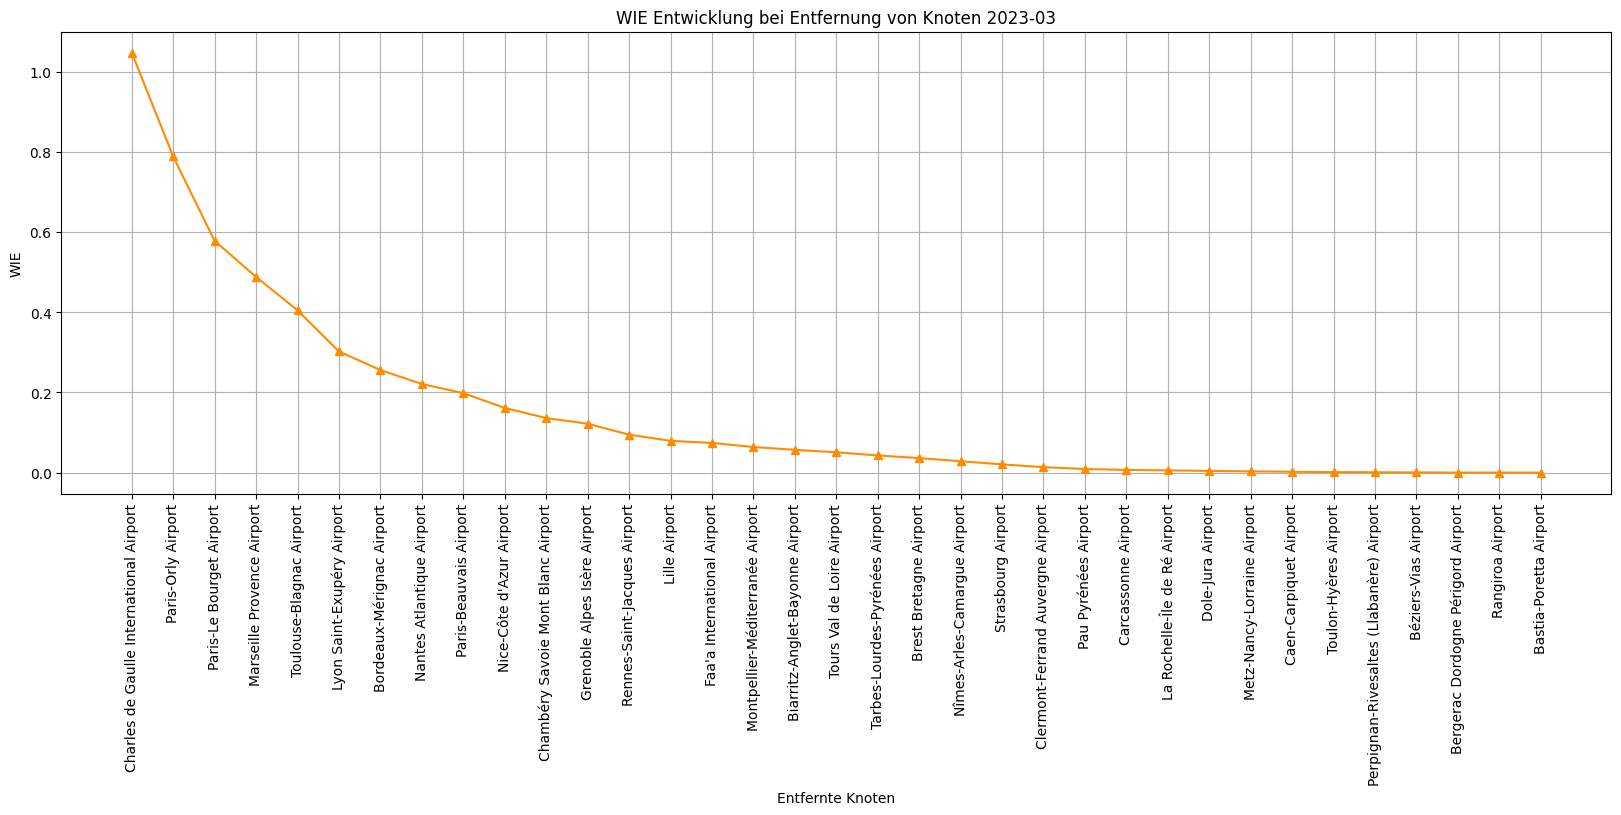

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-04-01_2023-07-01_frankreich.csv
Number of nodes (airports): 802
Number of edges (flight routes): 4900, sum of weights (flights) 44839.0
Found 1130 international airports to check against
WIE_post has become zero.
International robustness for 2023-04: 0.526979997920212


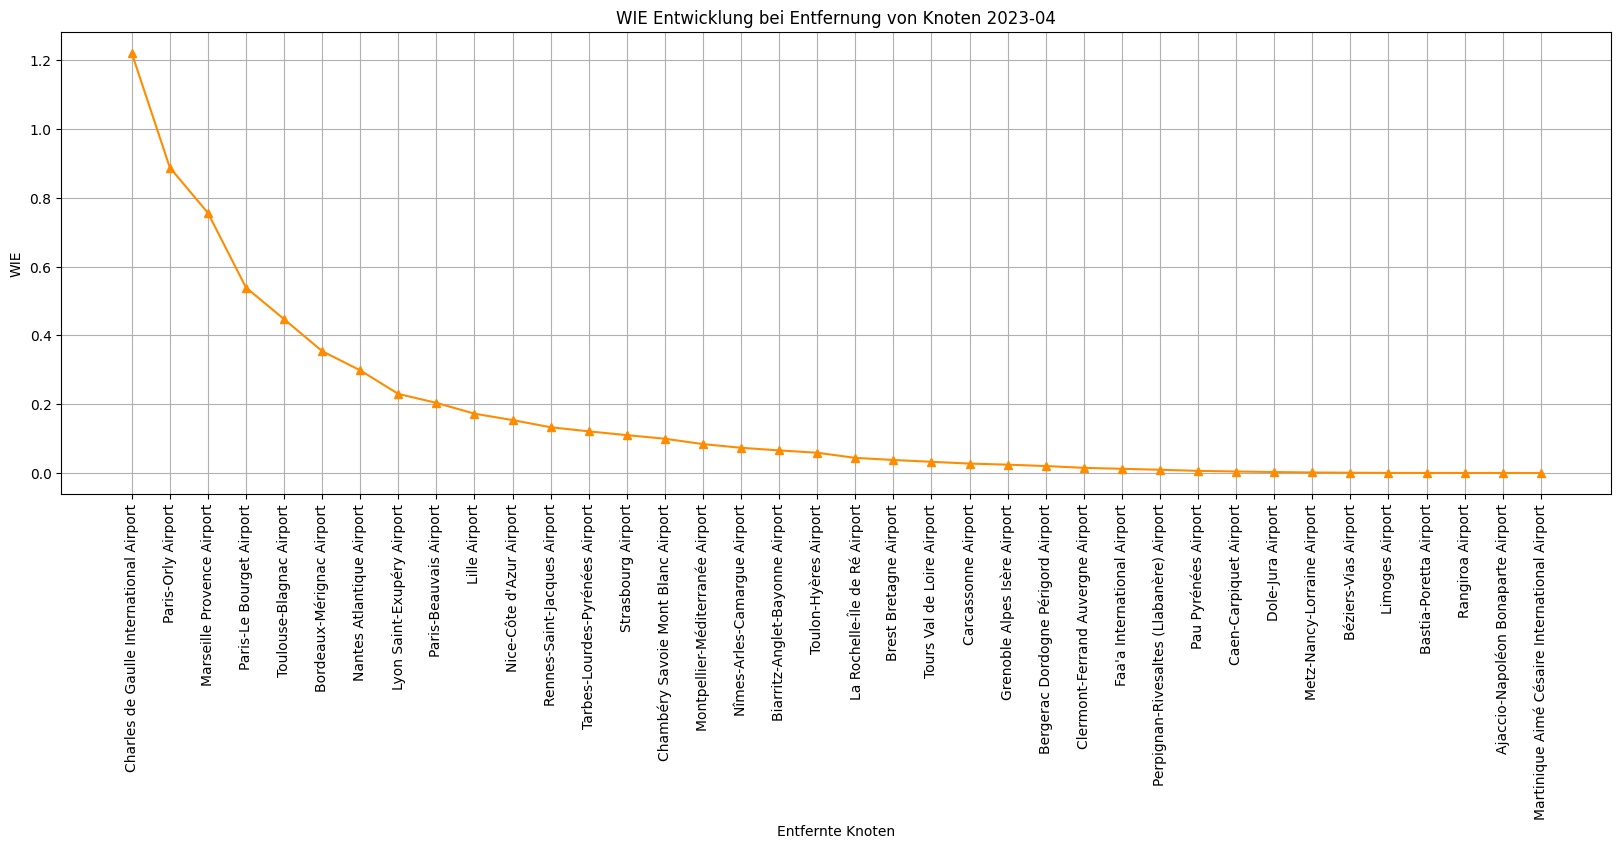

Number of nodes (airports): 858
Number of edges (flight routes): 5009, sum of weights (flights) 44957.0
Found 1130 international airports to check against
WIE_post has become zero.
International robustness for 2023-05: 0.49983693775348303


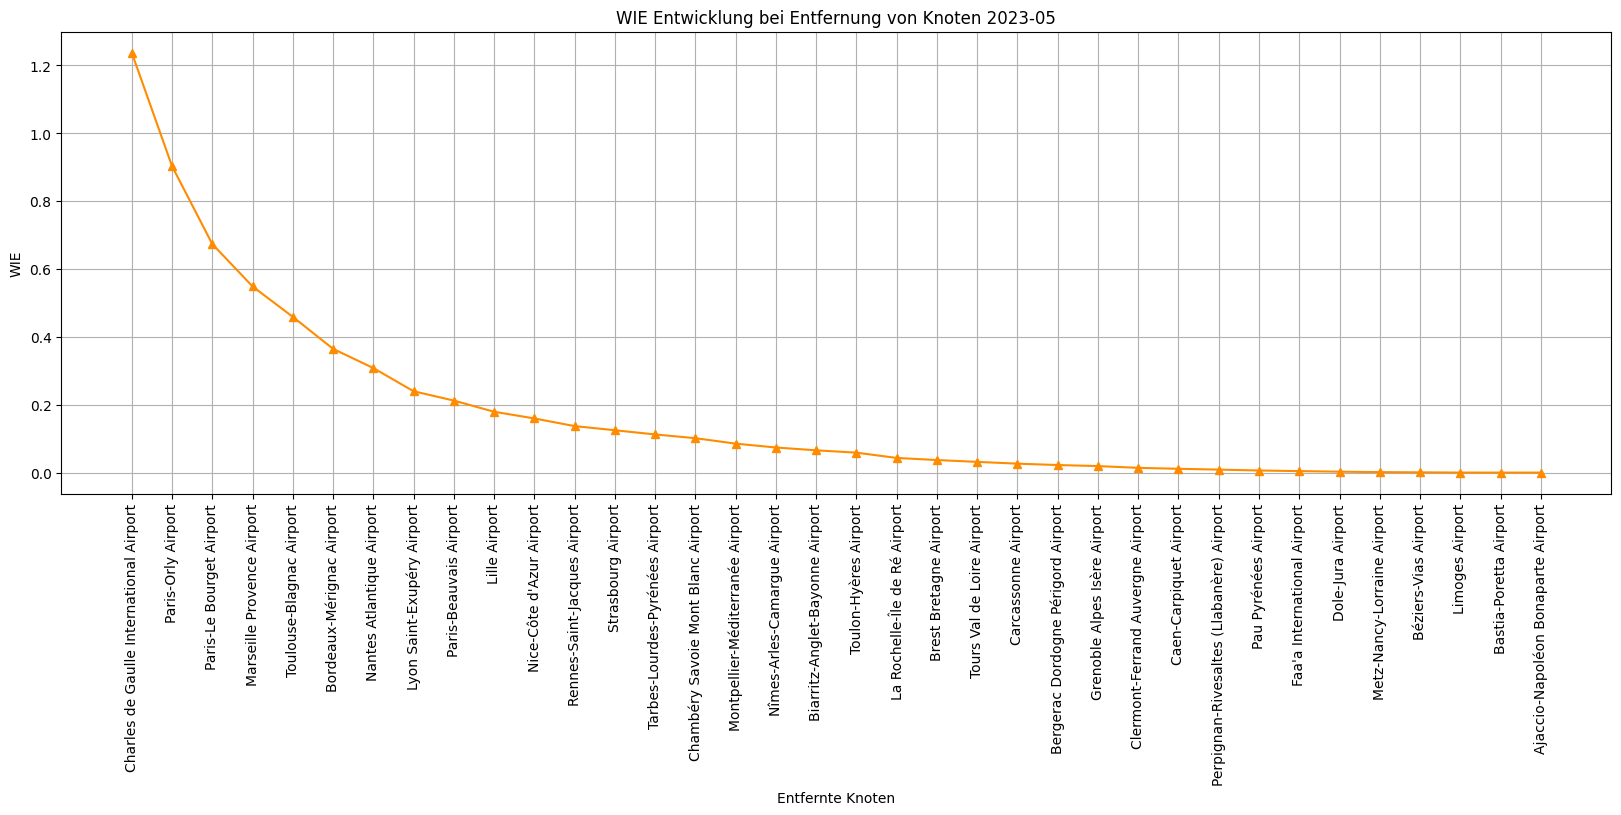

Number of nodes (airports): 898
Number of edges (flight routes): 5038, sum of weights (flights) 45055.0
Found 1130 international airports to check against
WIE_post has become zero.
International robustness for 2023-06: 0.5279630435420808


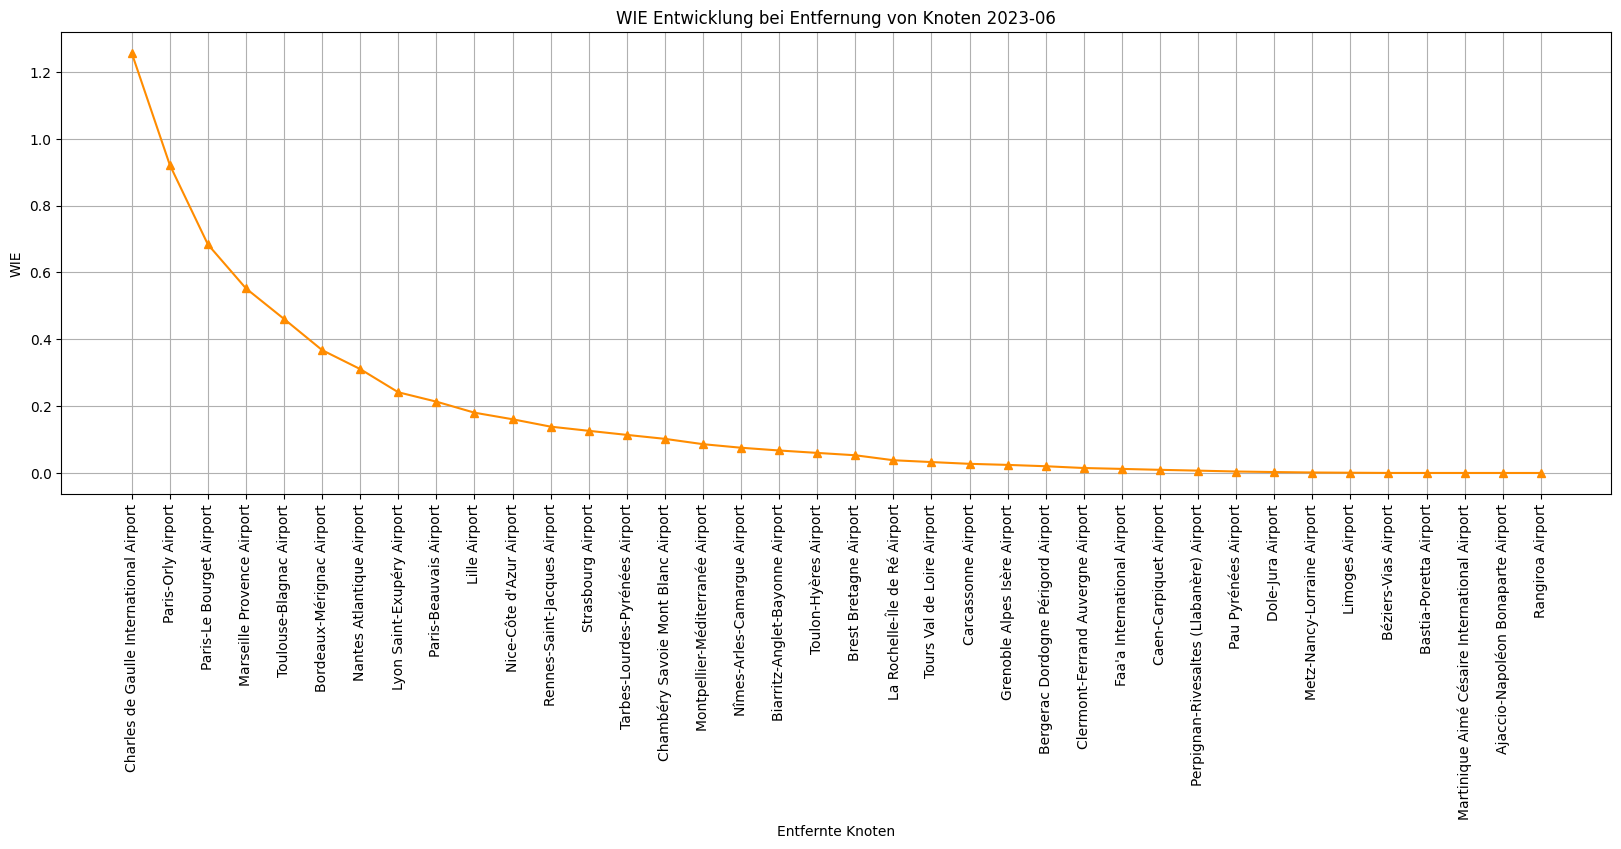

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-07-01_2023-10-01_frankreich.csv
Number of nodes (airports): 911
Number of edges (flight routes): 6074, sum of weights (flights) 56137.0
Found 1251 international airports to check against
WIE_post has become zero.
International robustness for 2023-07: 0.5628299293989283


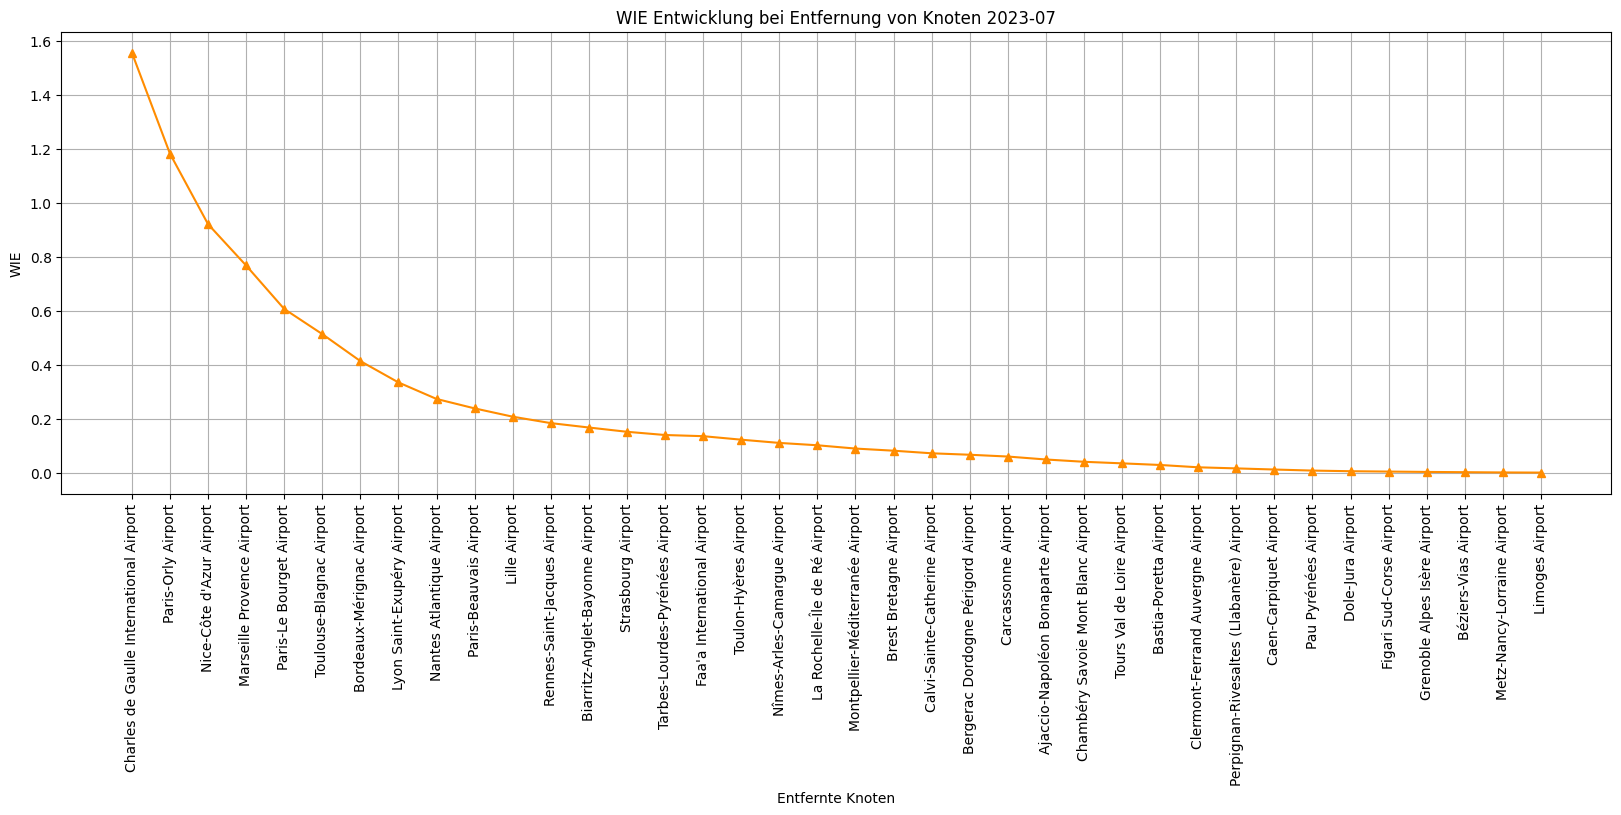

Number of nodes (airports): 949
Number of edges (flight routes): 6141, sum of weights (flights) 56415.0
Found 1251 international airports to check against
WIE_post has become zero.
International robustness for 2023-08: 0.56231972488314


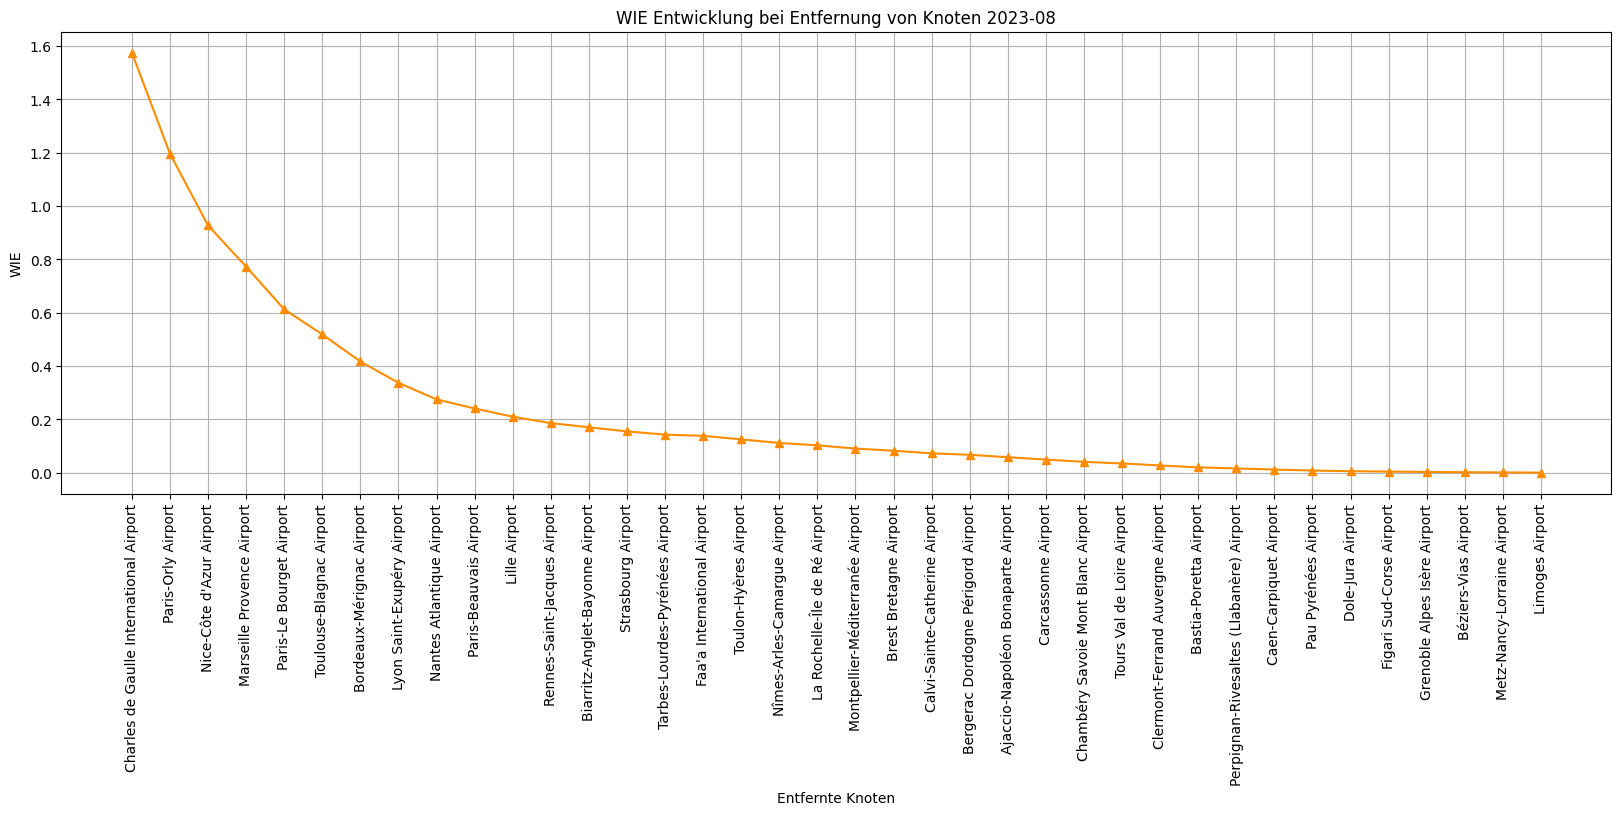

Number of nodes (airports): 967
Number of edges (flight routes): 6153, sum of weights (flights) 56444.0
Found 1251 international airports to check against
WIE_post has become zero.
International robustness for 2023-09: 0.5624482426881916


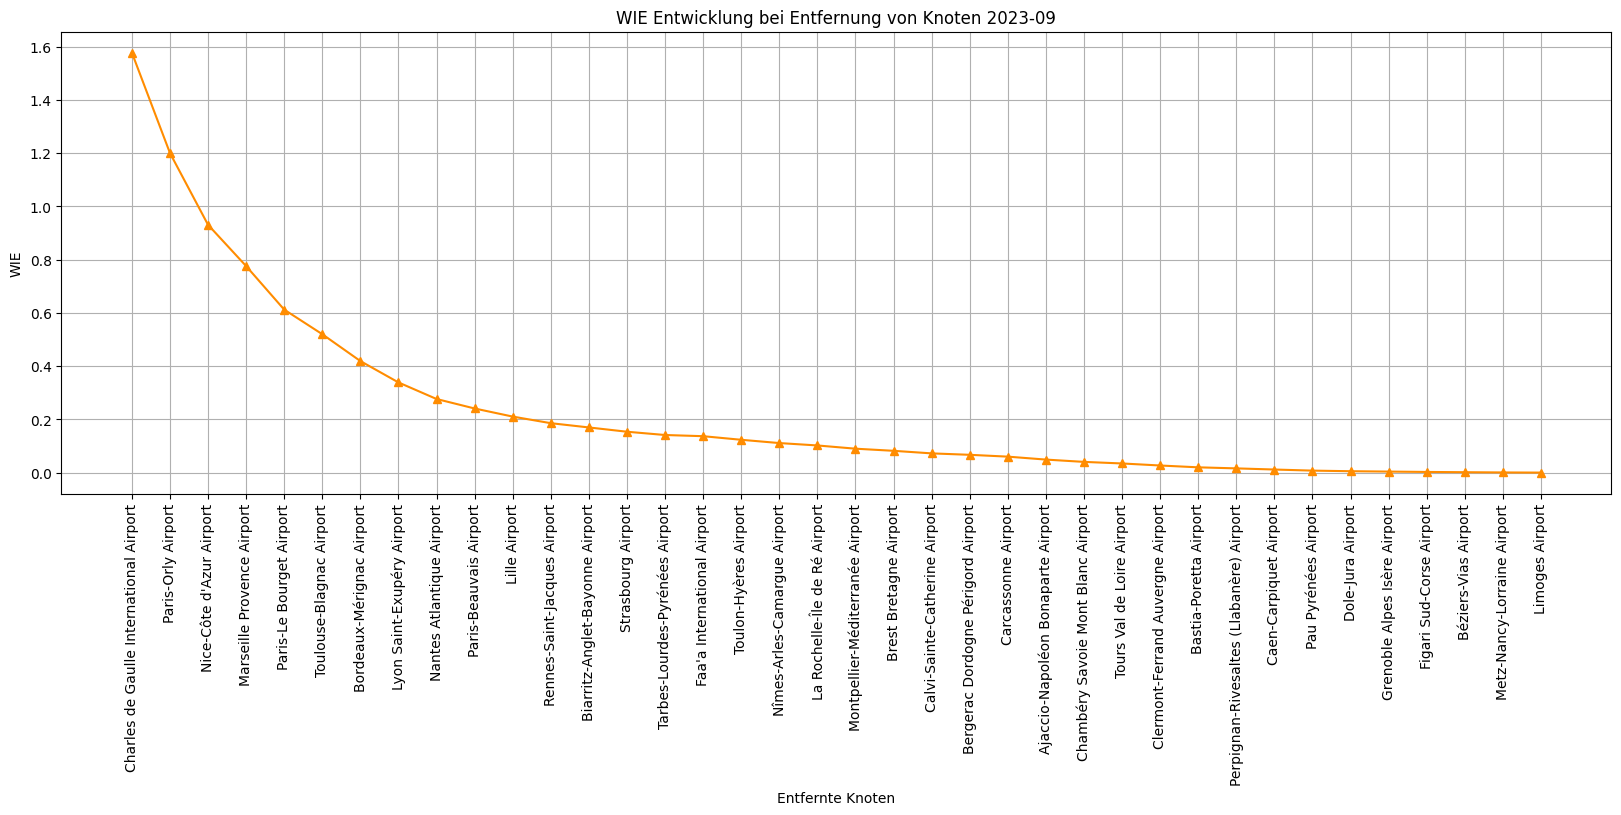

/content/drive/My Drive/2024KomplexeNetze/Daten/2023-10-01_2024-01-01_frankreich.csv
Number of nodes (airports): 931
Number of edges (flight routes): 4976, sum of weights (flights) 41641.0
Found 1115 international airports to check against
WIE_post has become zero.
International robustness for 2023-10: 0.5659874059886205


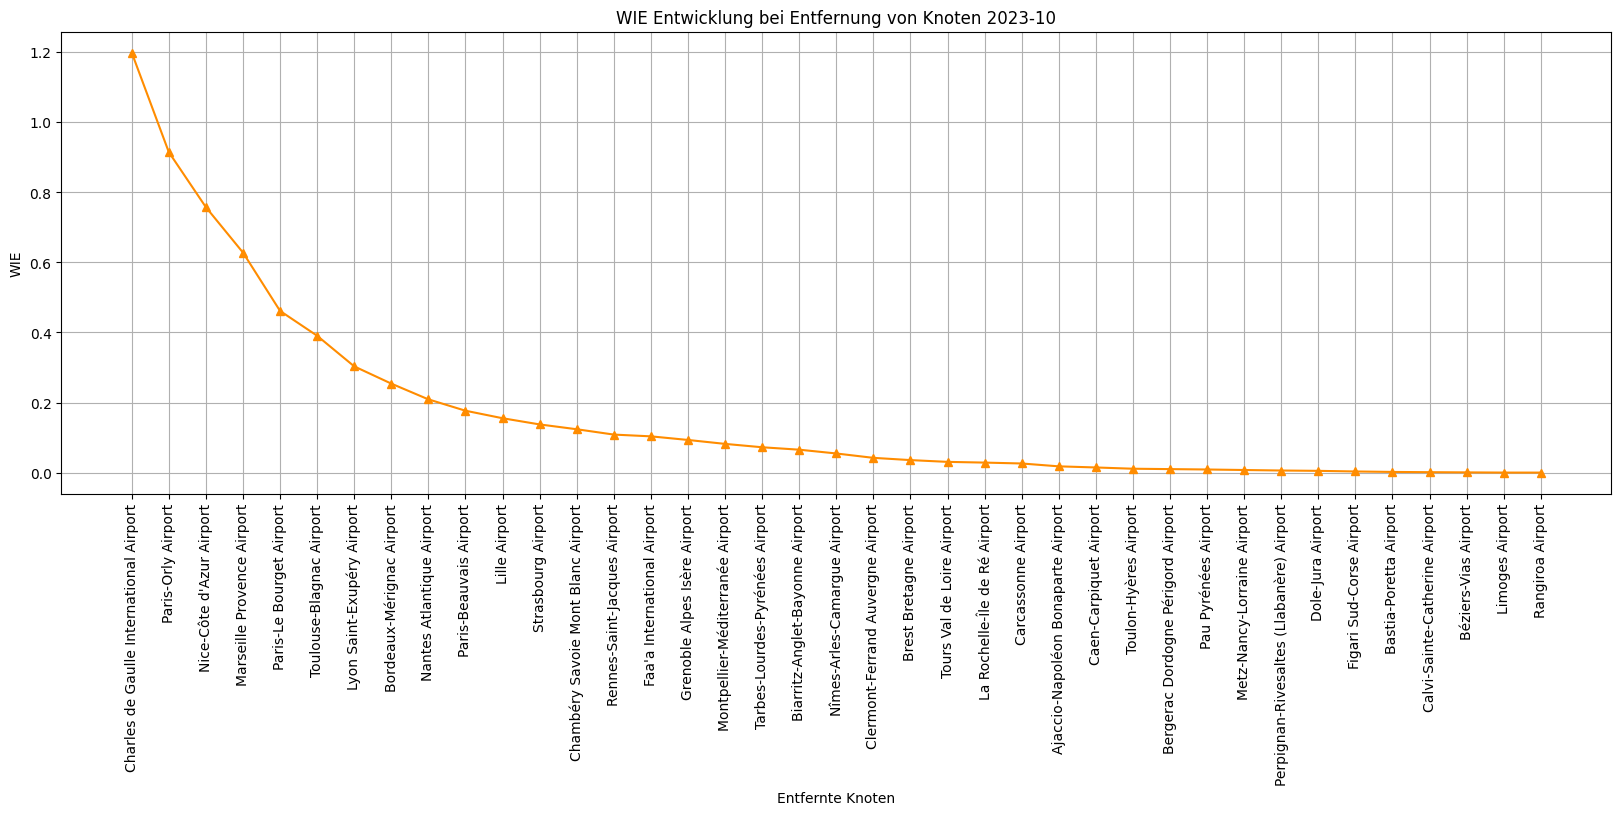

Number of nodes (airports): 759
Number of edges (flight routes): 4701, sum of weights (flights) 41033.0
Found 1115 international airports to check against
WIE_post has become zero.
International robustness for 2023-11: 0.5634842107021745


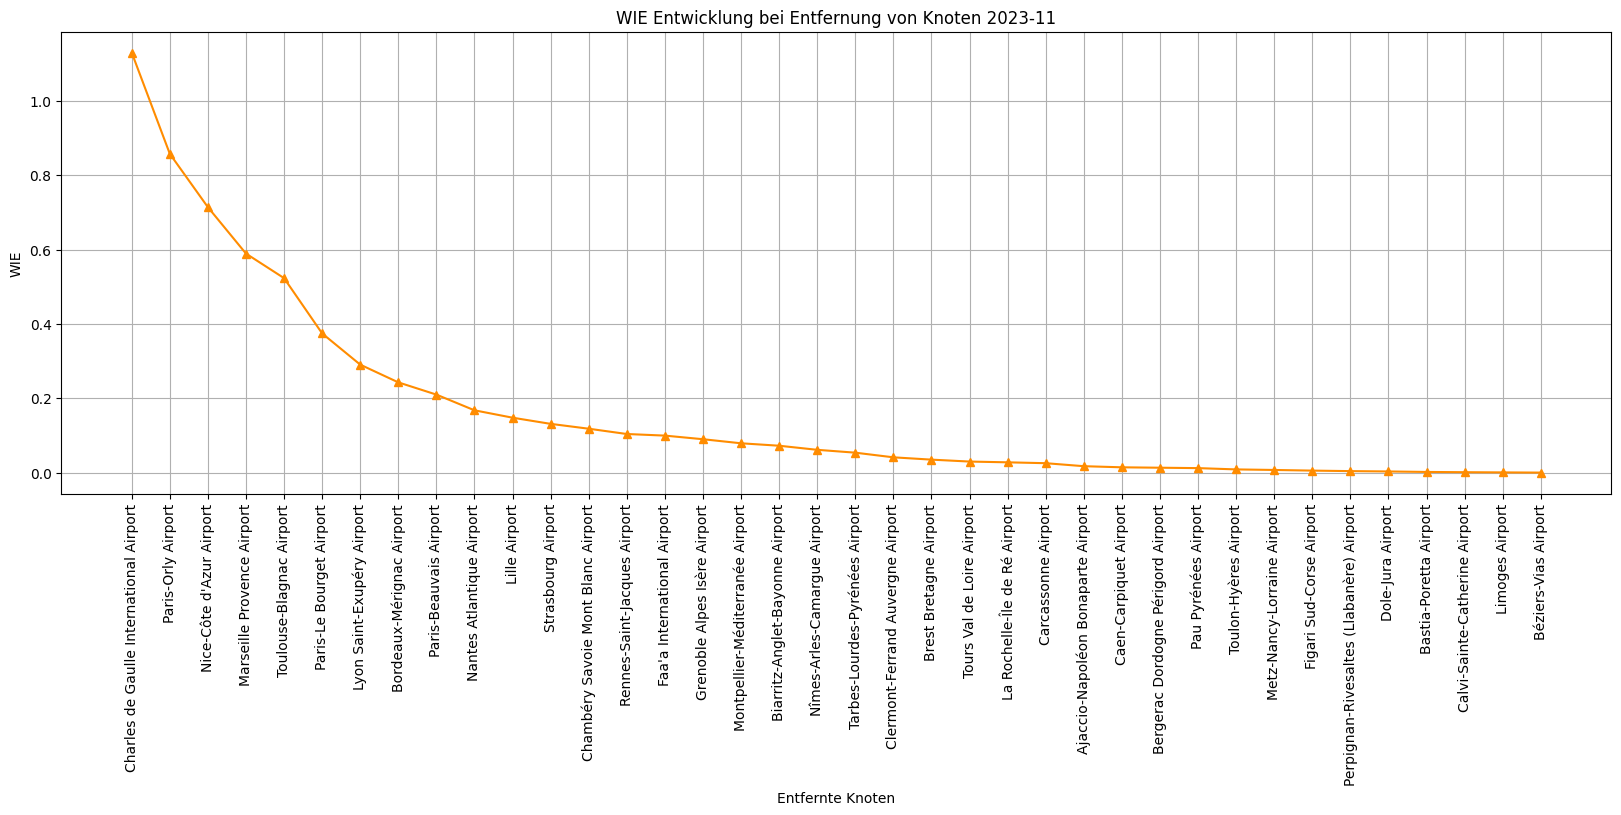

Number of nodes (airports): 739
Number of edges (flight routes): 4631, sum of weights (flights) 40982.0
Found 1115 international airports to check against
WIE_post has become zero.
International robustness for 2023-12: 0.565061723371015


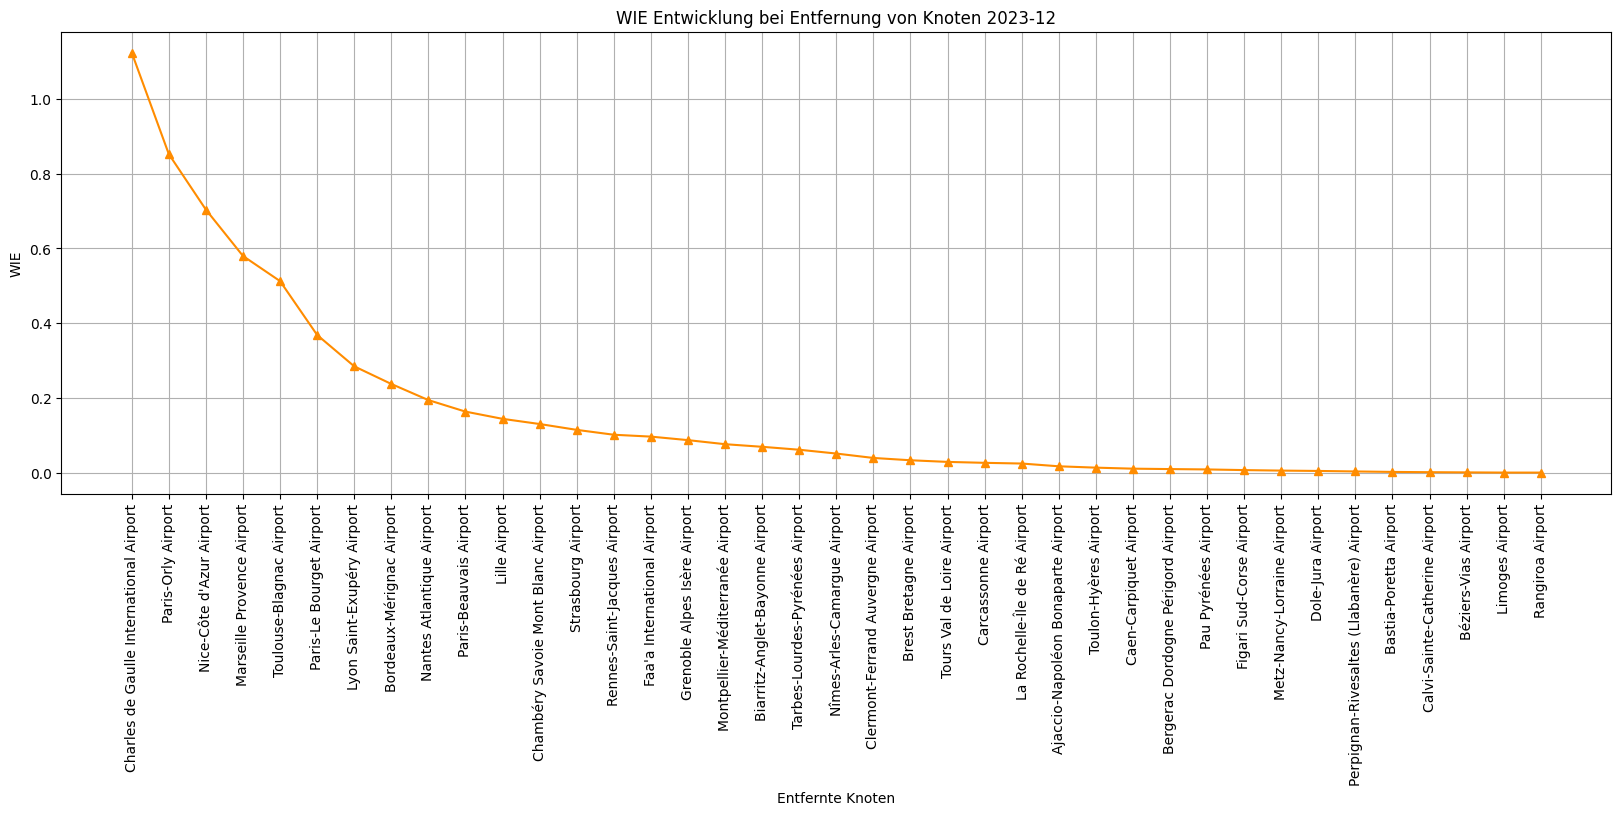

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-01-01_2024-04-01_frankreich.csv
Number of nodes (airports): 778
Number of edges (flight routes): 4438, sum of weights (flights) 43973.0
Found 1092 international airports to check against
WIE_post has become zero.
International robustness for 2024-01: 0.5486768371711386


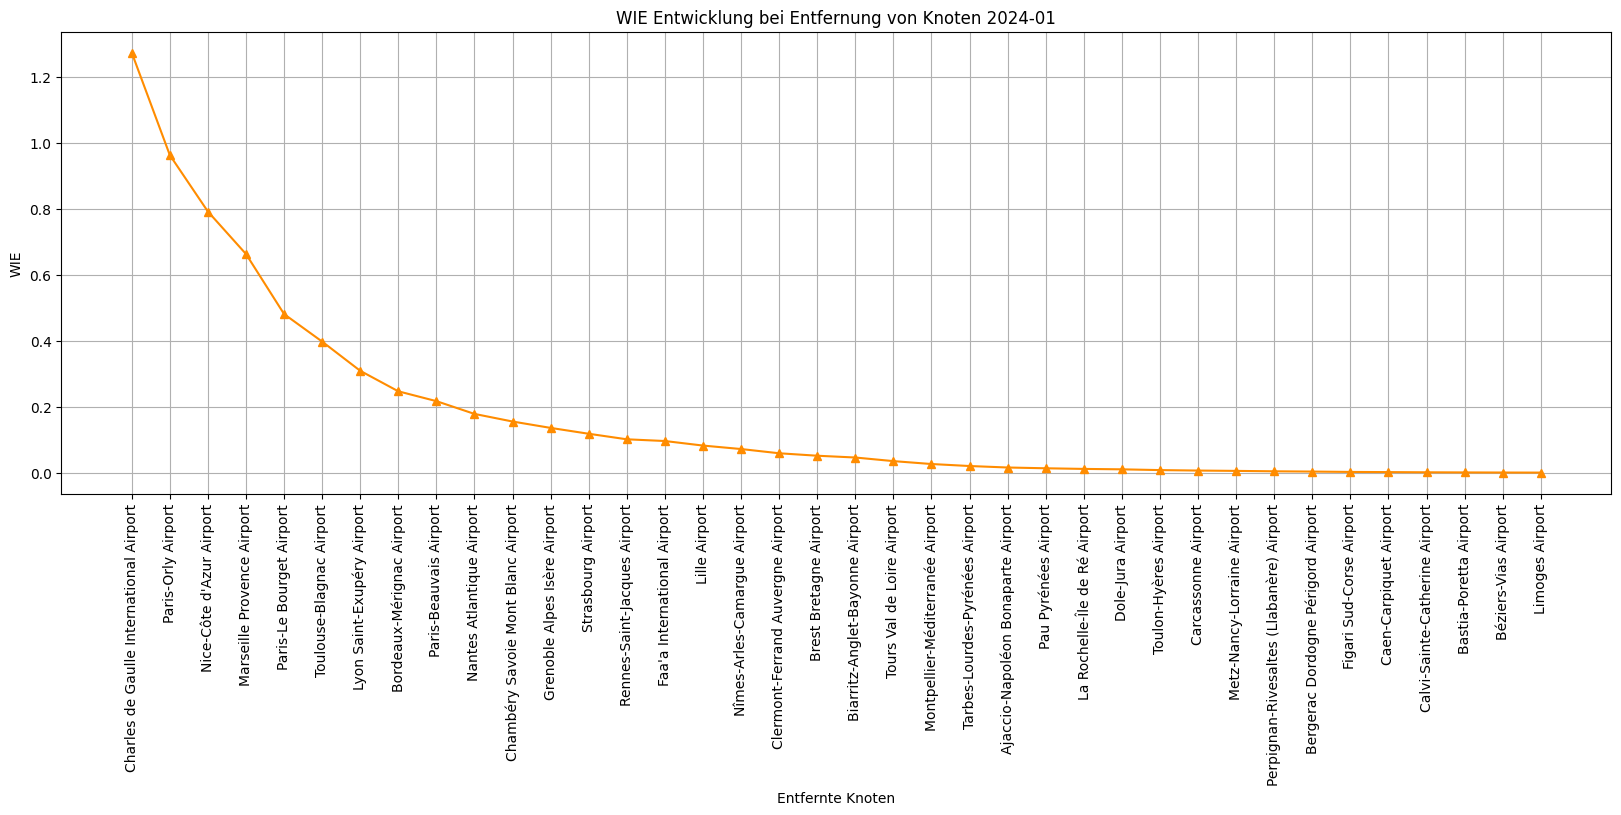

Number of nodes (airports): 781
Number of edges (flight routes): 4454, sum of weights (flights) 43997.0
Found 1092 international airports to check against
WIE_post has become zero.
International robustness for 2024-02: 0.5500862988080562


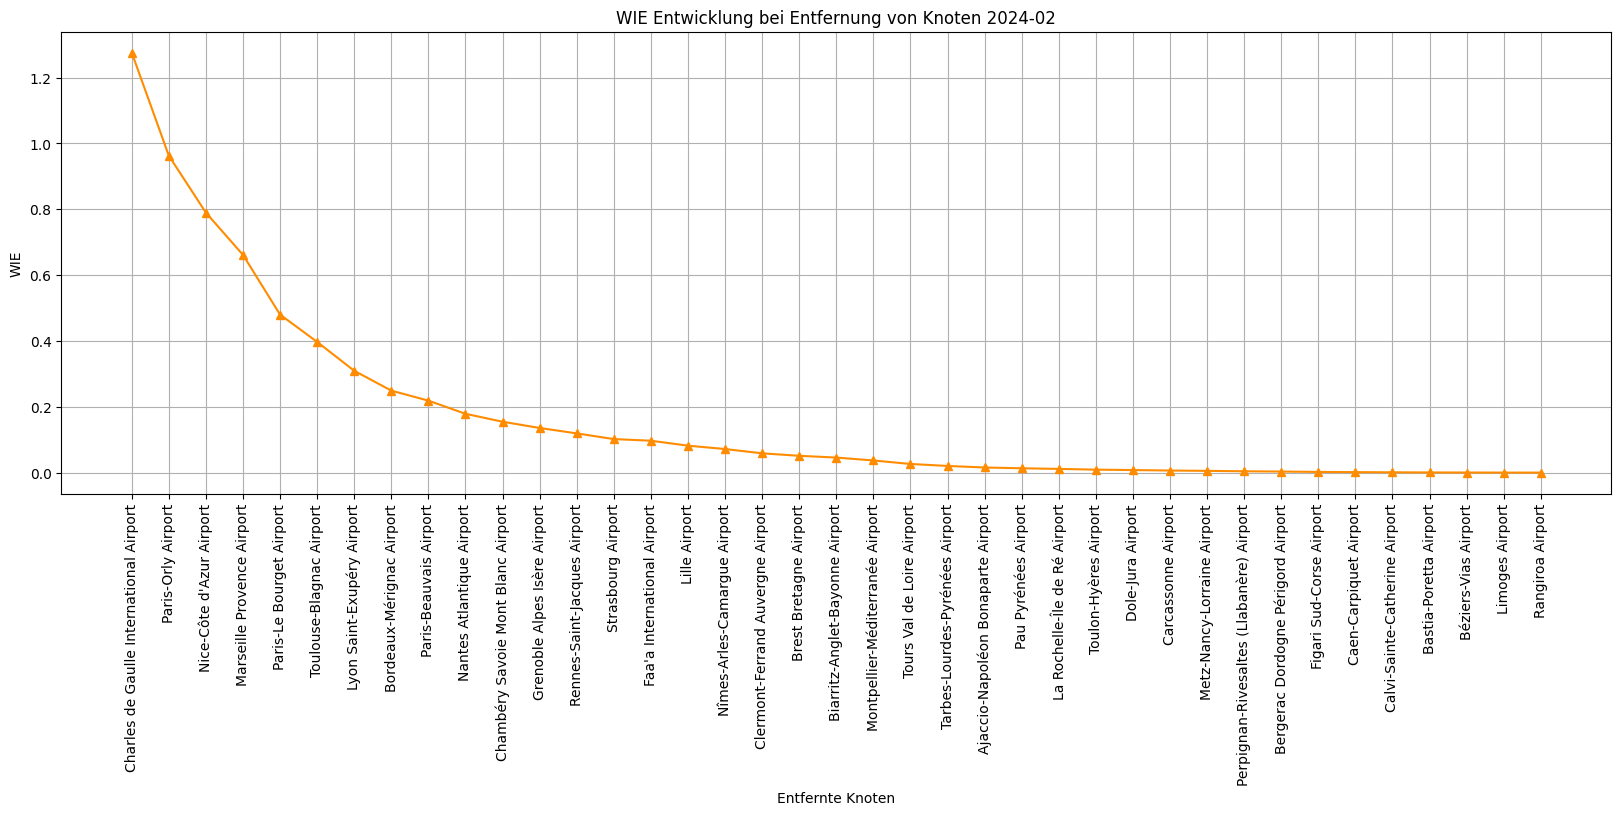

Number of nodes (airports): 872
Number of edges (flight routes): 4616, sum of weights (flights) 44247.0
Found 1092 international airports to check against
WIE_post has become zero.
International robustness for 2024-03: 0.5505214628864626


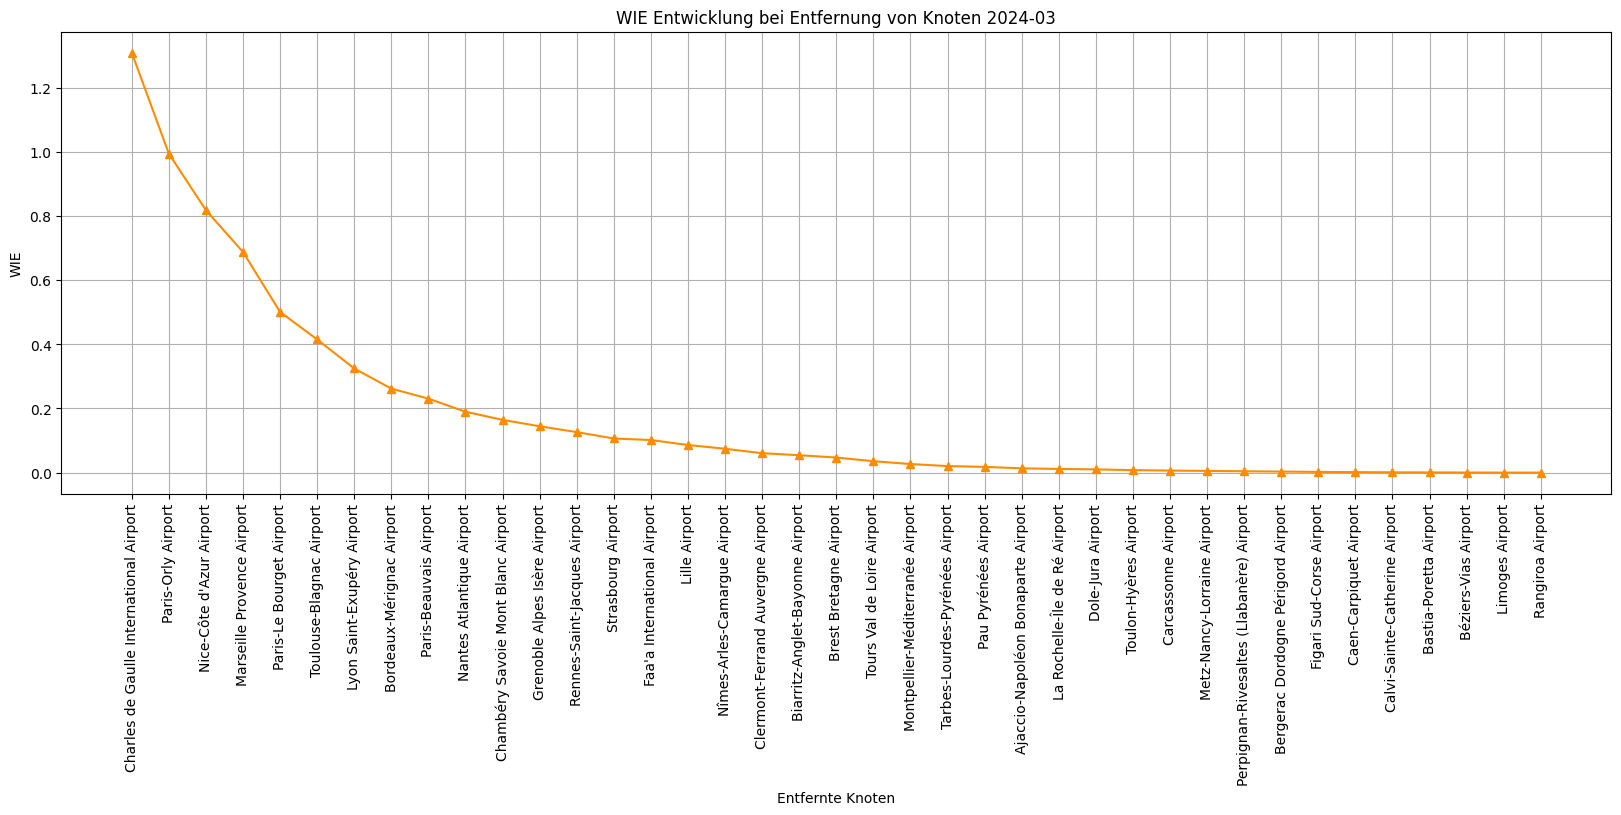

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-04-01_2024-07-01_frankreich.csv
Number of nodes (airports): 840
Number of edges (flight routes): 5596, sum of weights (flights) 52449.0
Found 1264 international airports to check against
WIE_post has become zero.
International robustness for 2024-04: 0.5600540090272954


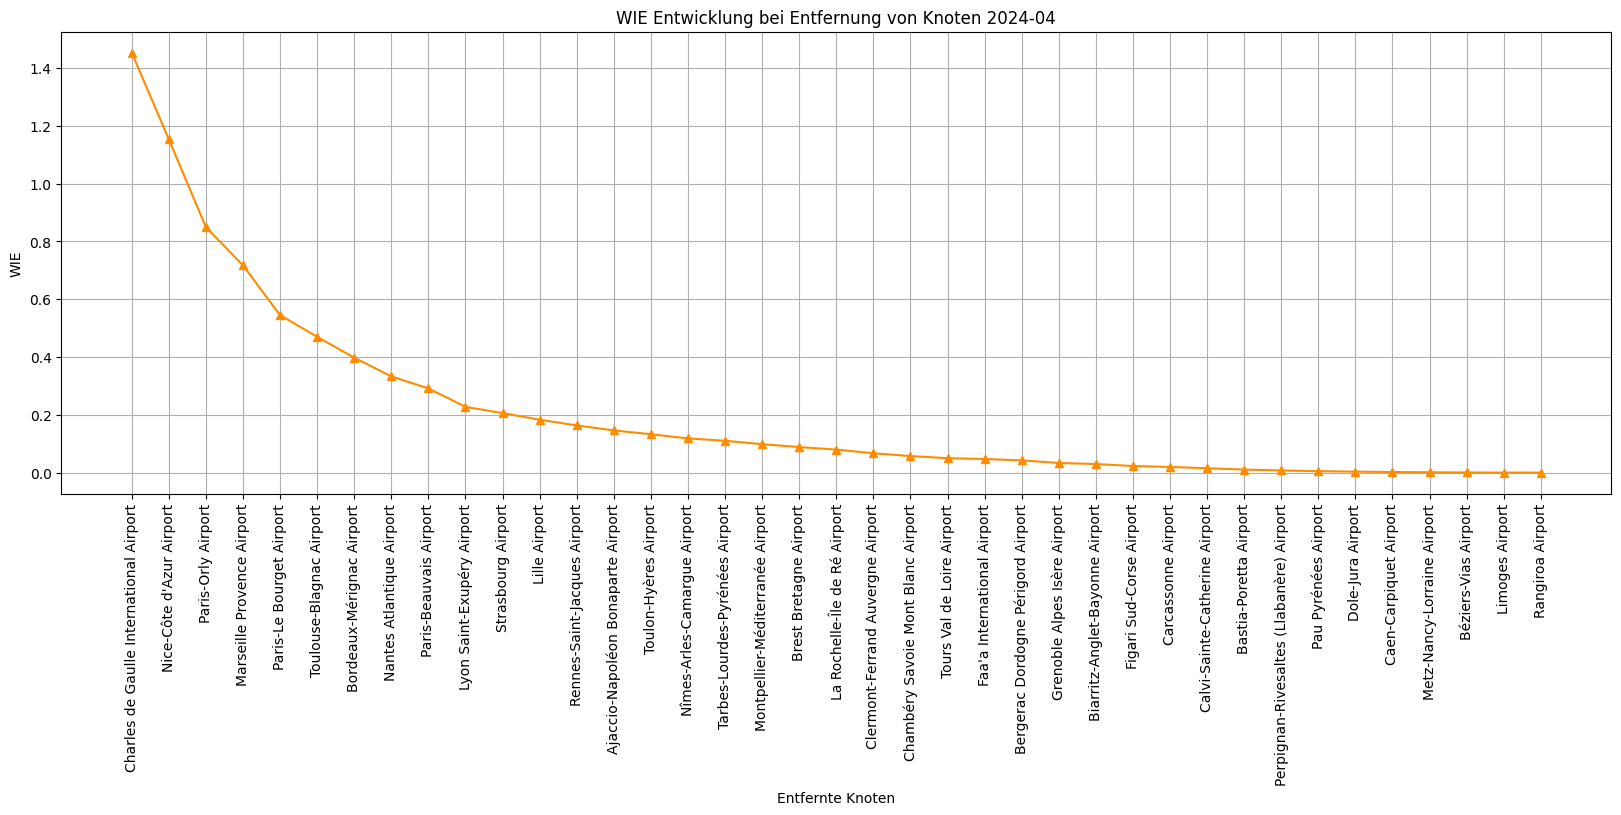

Number of nodes (airports): 902
Number of edges (flight routes): 5734, sum of weights (flights) 52722.0
Found 1264 international airports to check against
WIE_post has become zero.
International robustness for 2024-05: 0.5602382815615763


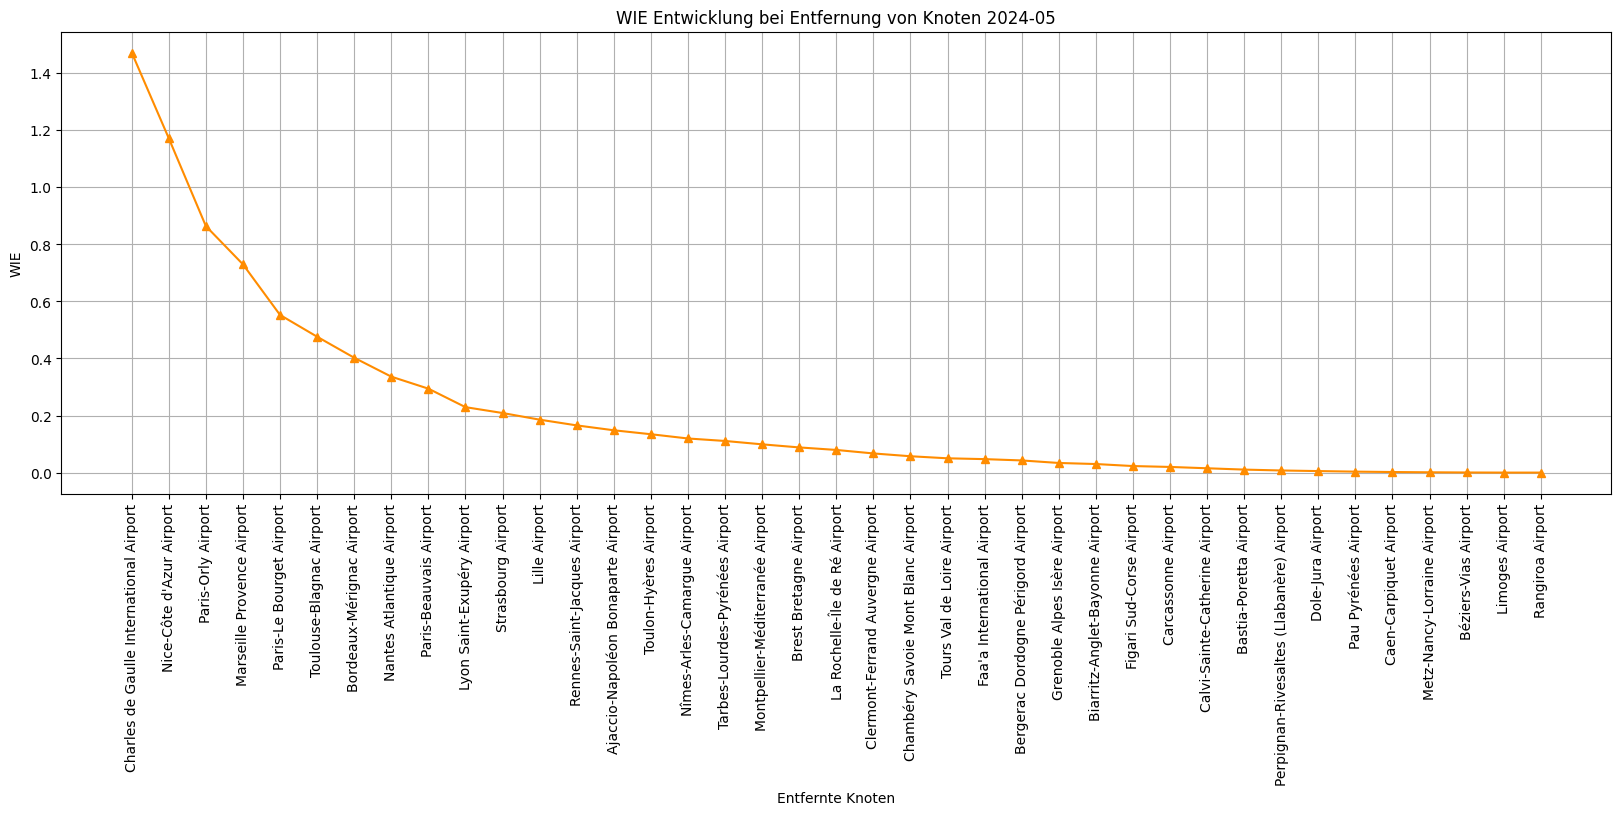

Number of nodes (airports): 1002
Number of edges (flight routes): 5891, sum of weights (flights) 52953.0
Found 1264 international airports to check against
WIE_post has become zero.
International robustness for 2024-06: 0.5589852935777434


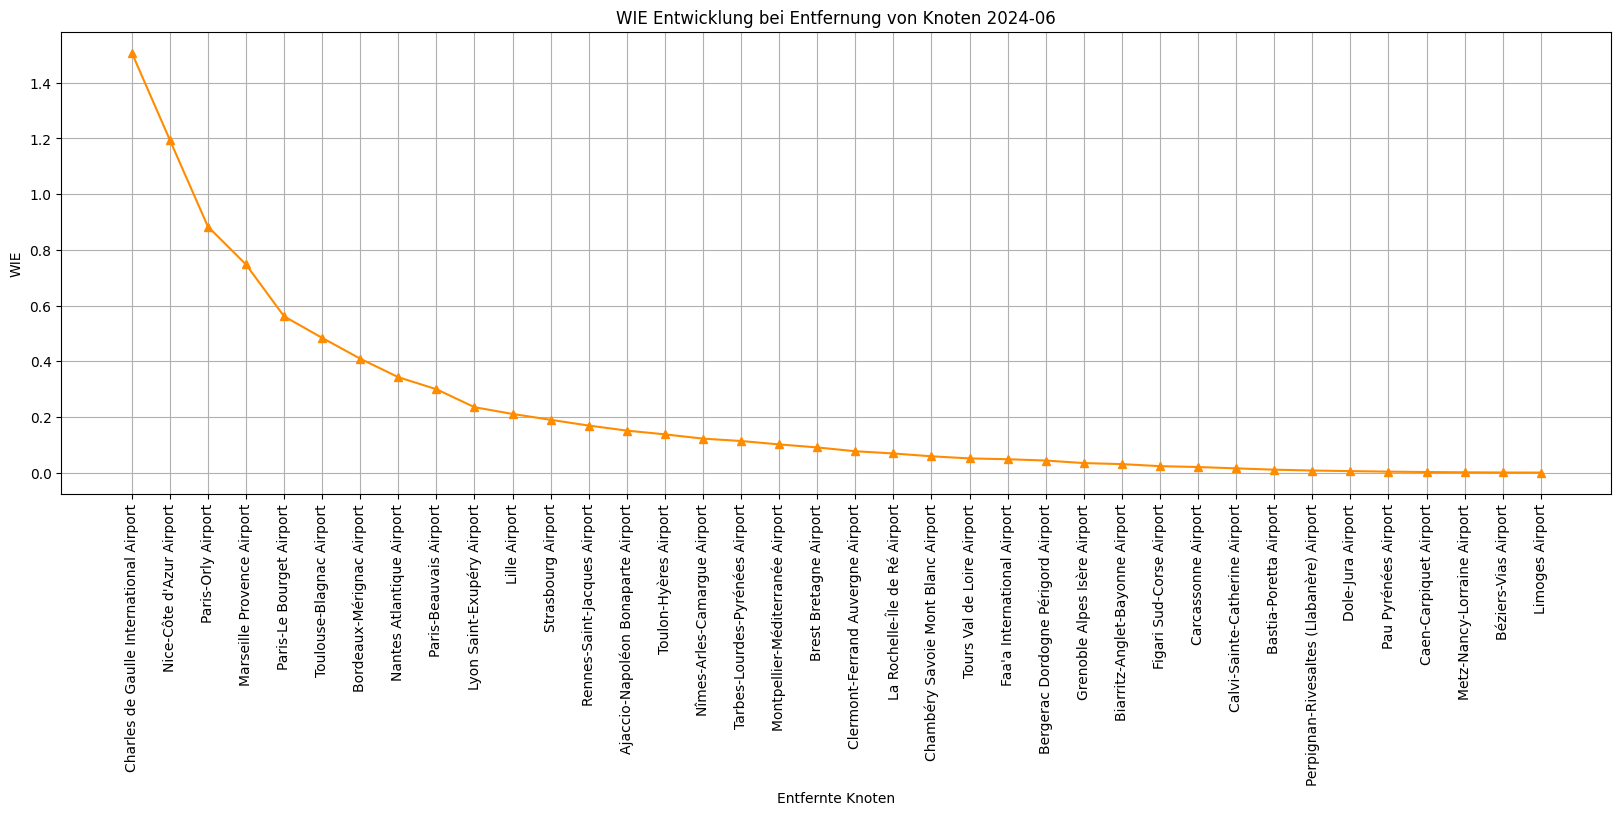

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-07-01_2024-10-01_frankreich.csv
Number of nodes (airports): 1003
Number of edges (flight routes): 6505, sum of weights (flights) 57365.0
Found 1308 international airports to check against
WIE_post has become zero.
International robustness for 2024-07: 0.5555055402150285


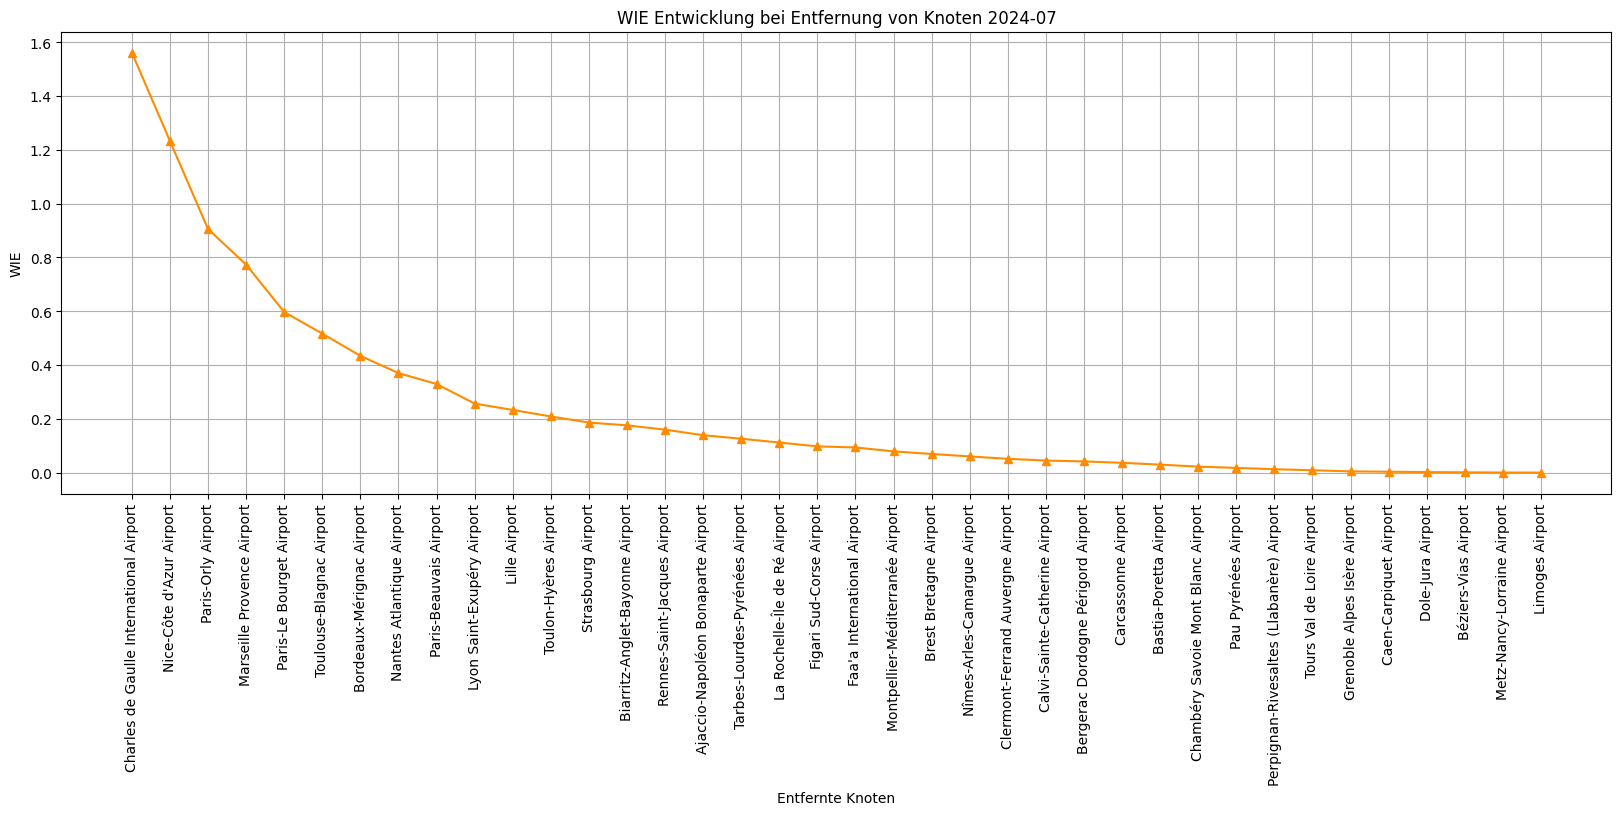

Number of nodes (airports): 1011
Number of edges (flight routes): 6504, sum of weights (flights) 57512.0
Found 1308 international airports to check against
WIE_post has become zero.
International robustness for 2024-08: 0.5571387686742711


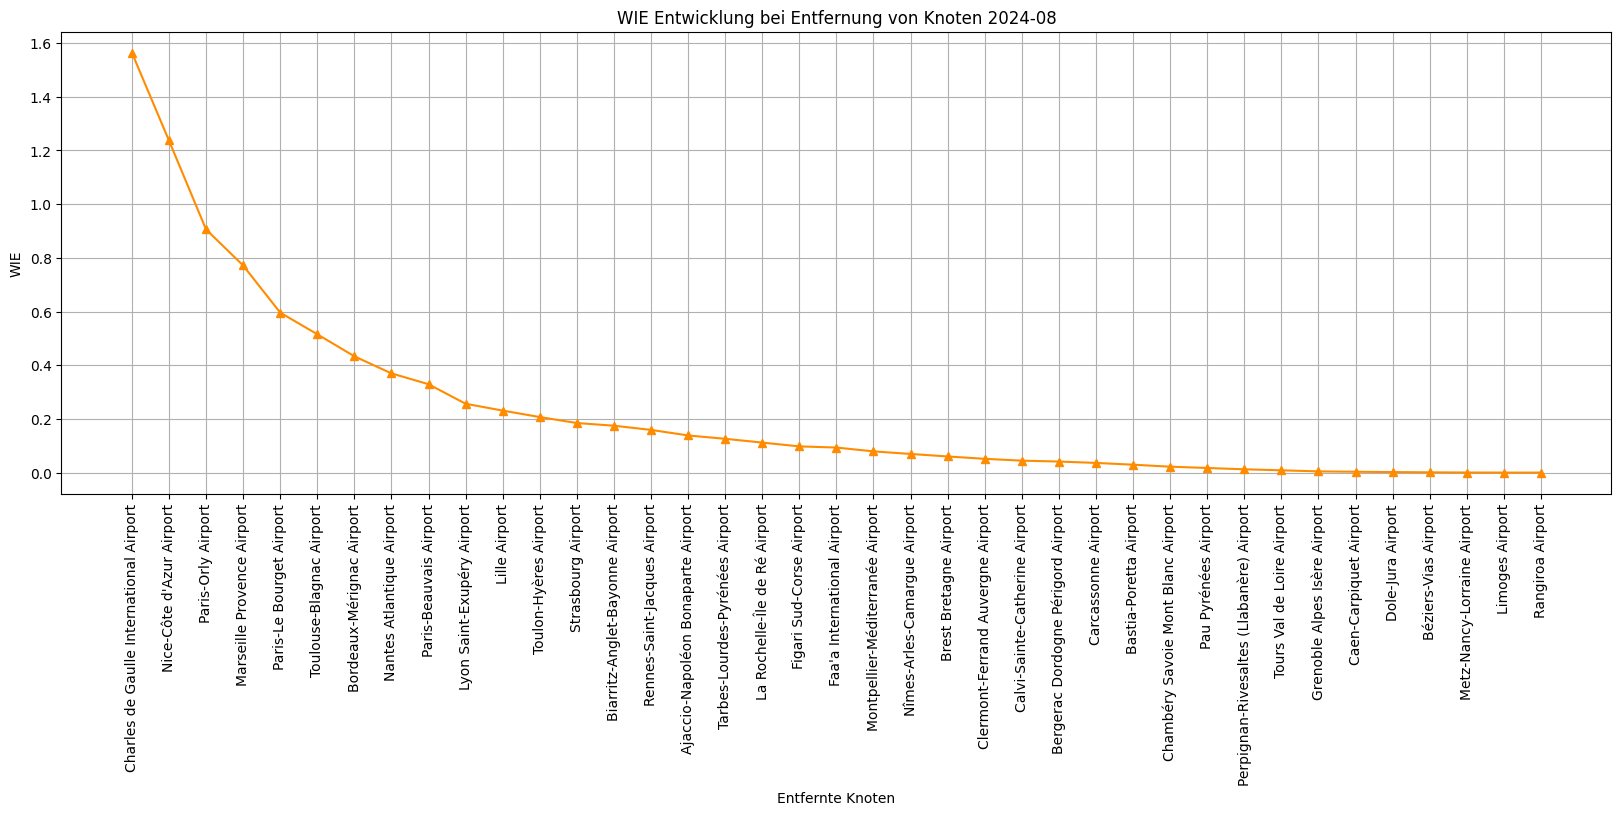

Number of nodes (airports): 933
Number of edges (flight routes): 6357, sum of weights (flights) 57343.0
Found 1308 international airports to check against
WIE_post has become zero.
International robustness for 2024-09: 0.5569028350129469


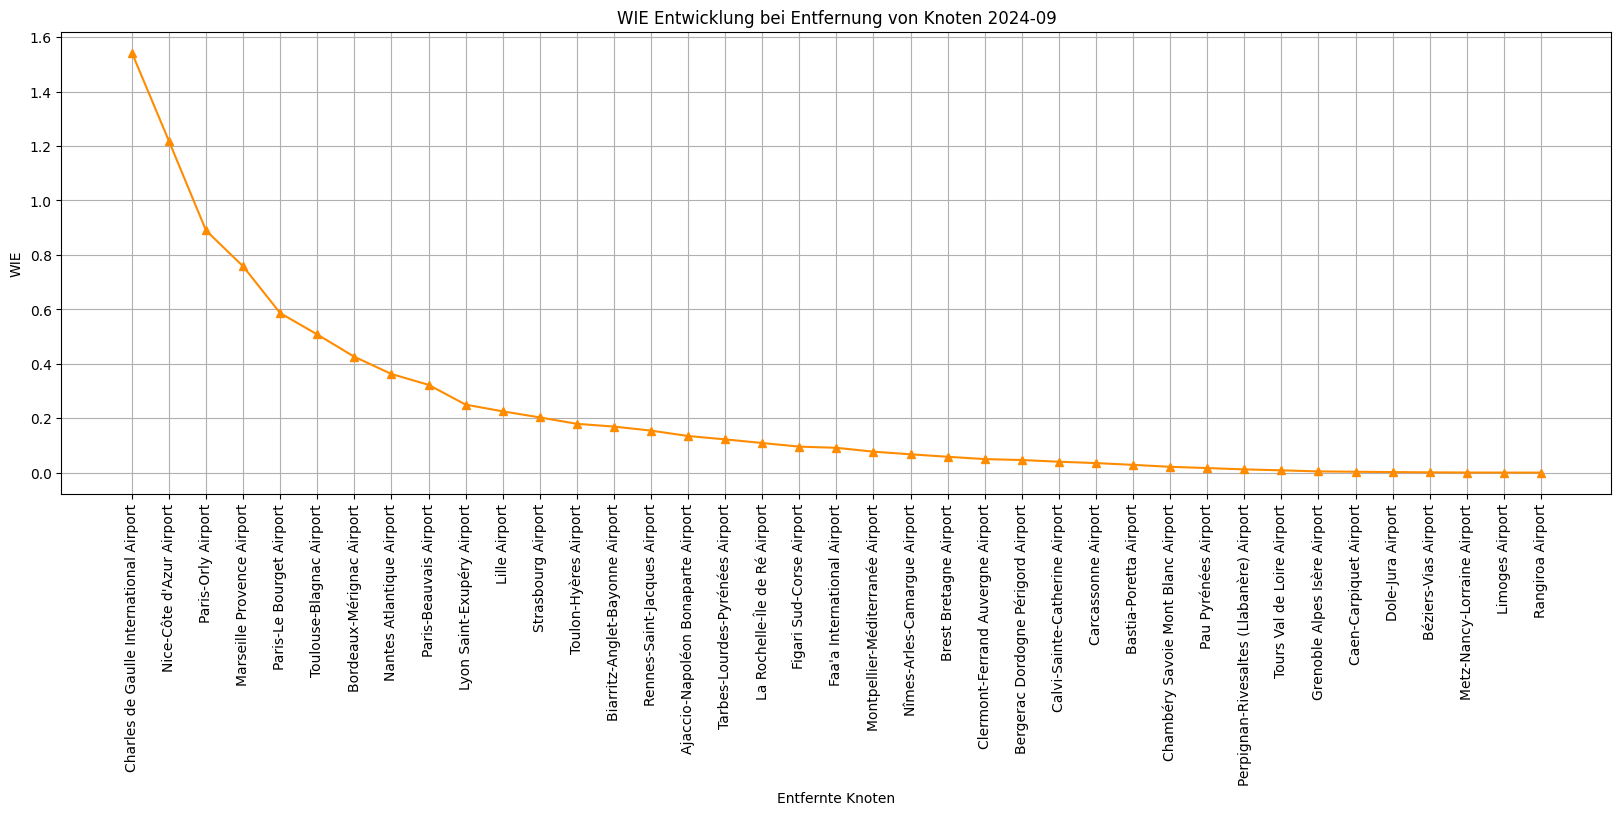

/content/drive/My Drive/2024KomplexeNetze/Daten/2024-10-01_2024-12-01_frankreich.csv
Number of nodes (airports): 948
Number of edges (flight routes): 4537, sum of weights (flights) 42528.0
Found 1032 international airports to check against
WIE_post has become zero.
International robustness for 2024-10: 0.5457777861835835


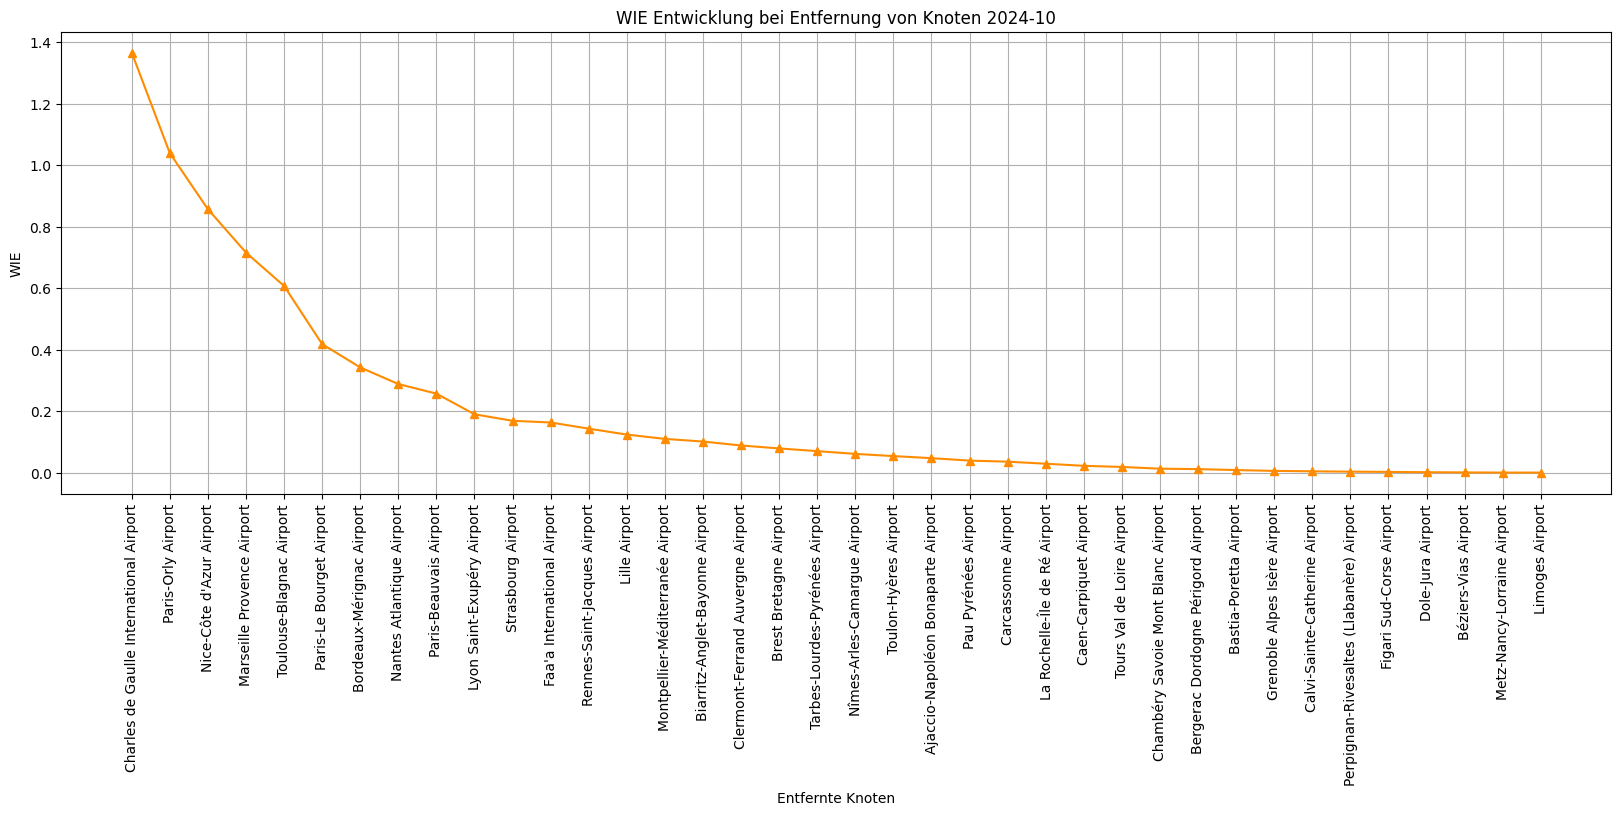

Number of nodes (airports): 766
Number of edges (flight routes): 4262, sum of weights (flights) 42123.0
Found 1032 international airports to check against
WIE_post has become zero.
International robustness for 2024-11: 0.5450198845806611


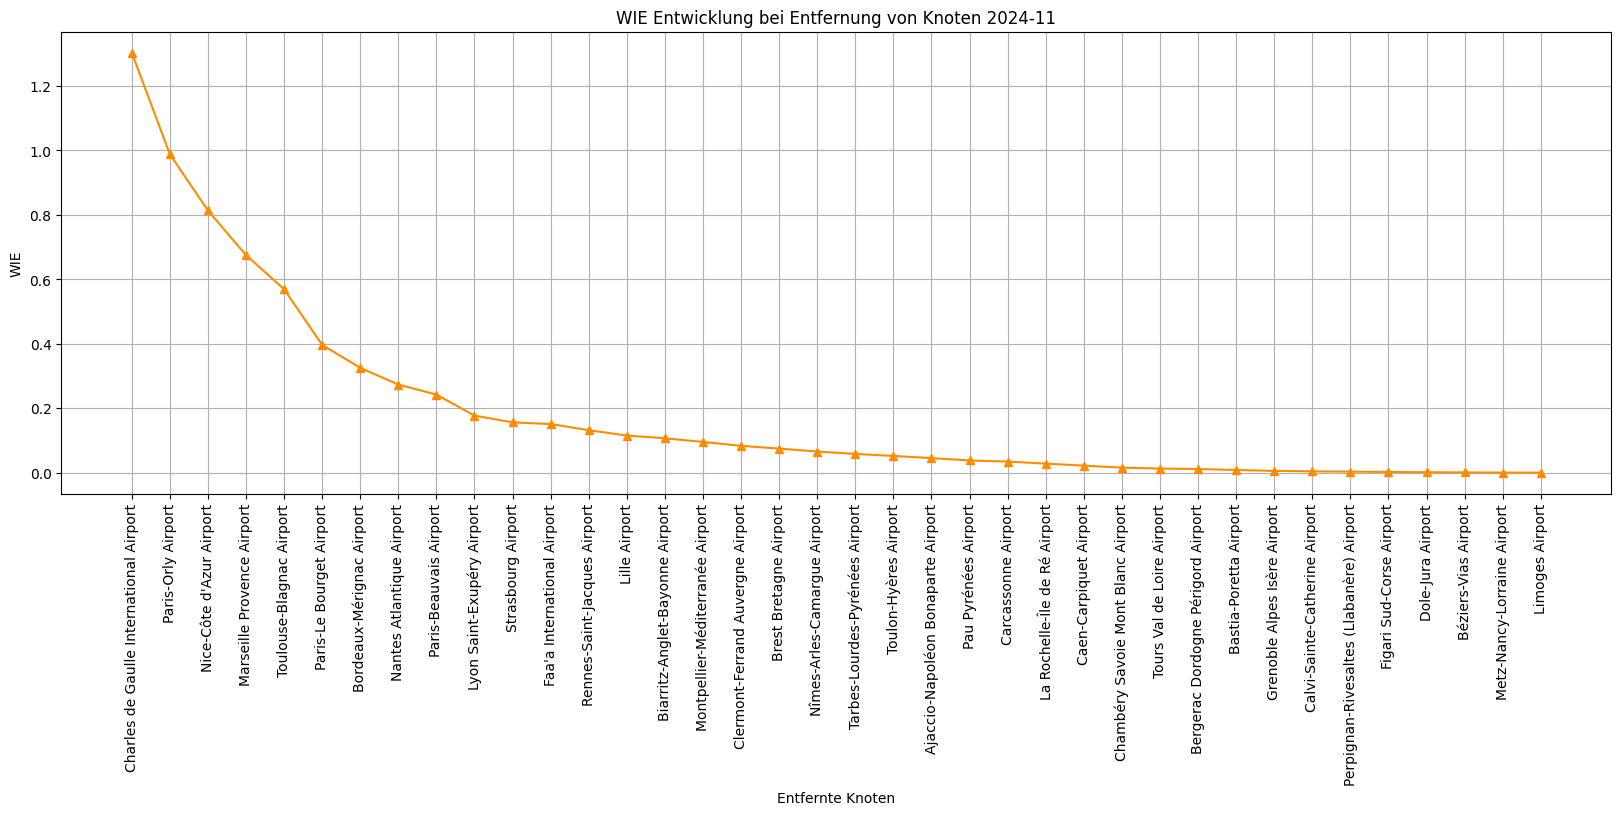

In [14]:
# Get the current date and time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# Initialize lists to store WIE and IR values for each year
wie_2019 = []
wie_2018 = []
wie_2023 = []
wie_2024 = []
ir_2019 = []
ir_2018 = []
ir_2023 = []
ir_2024 = []
ieflight_2019 = []
ieflight_2018 = []
ieflight_2023 = []
ieflight_2024 = []
neroute_2019 = []
neroute_2018 = []
neroute_2023 = []
neroute_2024 = []
months_2019 = []
months_2018 = []
months_2023 = []
months_2024 = []

for csv_file in csv_files:

  flightdata = pd.read_csv(csv_file, parse_dates=["firstseen", "lastseen", "day"])
  print(csv_file)


  #flightdata.head()
  #flightdata.describe()
  #nan_percentage = (flightdata.isna().sum() / len(flightdata)) * 100
  #print(nan_percentage)
  flightdata.dropna(inplace=True)
#  flightdata.describe()

  #departure_counts = flightdata['departure'].value_counts()
  #eddm_count = departure_counts.get('EDDM', 0)
  #eddf_count = departure_counts.get('EDDF', 0)
  #print(f"at the start: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

  flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
  flightdata = flightdata.rename(columns={"municipality": "departure_city"})
  flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
  flightdata = flightdata.rename(columns={"municipality": "arrival_city"})

  # add a column to flightdata dataframe with contains week-and-year
  flightdata['week_and_year'] = flightdata['day'].dt.strftime('%Y-%U')
  #flightdata.tail()

  # add a column to flightdata dataframe with contains month-and-year
  flightdata['month_and_year'] = flightdata['day'].dt.strftime('%Y-%m')
  #flightdata.tail()

  # query dataframe for everything starting/ending at one of the selected airports
  #flightdata = flightdata[flightdata['departure'].isin(icaolist) | flightdata['arrival'].isin(icaolist)]
  flightdata = flightdata[flightdata['departure'].isin(icaolist)]

  # analyse the data by month
  for month_year in flightdata['month_and_year'].unique():
    # Filter the flightdata for the chosen year_month
    filtered_flightdata = flightdata[flightdata['month_and_year'] == month_year]
    #departure_counts = filtered_flightdata['departure'].value_counts()
    #eddm_count = departure_counts.get('EDDM', 0)
    #eddf_count = departure_counts.get('EDDF', 0)
    #print(f"after selecting {month_year}: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

    # Create a directed graph
    #    trafficgraph = nx.DiGraph()
    weightedgraph = nx.DiGraph()

    # Part 1: Add nodes from the flights data
    for index, row in filtered_flightdata.iterrows():
        origin = row['departure']
        destination = row['arrival']

        # Add the origin and destination as nodes if they don't exist (and are not identical)
        if origin != destination:
          if origin not in weightedgraph:
              weightedgraph.add_node(origin)
          if destination not in weightedgraph:
              weightedgraph.add_node(destination)


    print("Number of nodes (airports):", weightedgraph.number_of_nodes())

    # Part 2: Add weighted edges from the flights data

    # Group flights by origin, destination, and day to count weekly connections
    #weekly_connections = flightdata.groupby(['departure', 'arrival', 'week_and_year']).size().reset_index(name='connections')
    #print(weekly_connections.tail())
    #average_connections = weekly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
    #print(average_connections.tail())

    # Group flights by origin, destination, and day to count monthly connections
    monthly_connections = flightdata.groupby(['departure', 'arrival', 'month_and_year']).size().reset_index(name='connections')
    #print(monthly_connections.head())

    # Calculate the average connections for each departure-arrival combination
    #average_connections = monthly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
    #print(average_connections.tail())

    # Add weighted edges based on average connections
    for index, row in monthly_connections.iterrows():
      if row['departure'] != row['arrival']:
        origin = row['departure']
        destination = row['arrival']
        weight = row['connections']

        # Add the edge with the calculated weight
        if origin in weightedgraph and destination in weightedgraph:
            weightedgraph.add_edge(origin, destination, weight=weight)

    nflights= weightedgraph.size(weight="weight")
    nroutes=weightedgraph.number_of_edges()
    print(f"Number of edges (flight routes): {nroutes}, sum of weights (flights) {nflights}" )
    #print(list(weightedgraph.degree(['EDDF','EDDM'], weight="weight")))

    international_list = flightdata[~flightdata['arrival'].isin(icaolist)]['arrival'].unique()
    print (f'Found {len(international_list)} international airports to check against')

    domestic_departure_graph = weightedgraph.copy()
#    domestic_departure_graph = nx.DiGraph()
#    for u, v, data in weightedgraph.edges(data=True):
#      if u in icaolist:
#        domestic_departure_graph.add_edge(u, v, **data) # Keep the edge data/weight
#    print("Number of edges (flights) in domestic graph:", domestic_departure_graph.number_of_edges())


#    ddd = dict(domestic_departure_graph.degree(weight='weight'))
#    nx.draw(domestic_departure_graph.degree, pos=nx.spring_layout(domestic_departure_graph), nodelist=ddd.keys(), node_size=[(1+nv) * 100 for nv in ddd.values()])
#    plt.show()

    # Extract year and month
    year, month = map(int, month_year.split('-'))

    # Let's see what the WIE is
    # While doing that, calculate the ratio of post- and pre- WIEs.
    modified_graph = domestic_departure_graph.copy()
    sum_ratio = 0
    WIE_pre = analyze_graph_WIE(modified_graph.copy())
    if year == 2019:
      wie_2019.append(WIE_pre)
      months_2019.append(f'{month:02}')
    elif year == 2018:
      wie_2018.append(WIE_pre)
      months_2018.append(f'{month:02}')
    elif year == 2023:
      wie_2023.append(WIE_pre)
      months_2023.append(f'{month:02}')
    elif year == 2024:
      wie_2024.append(WIE_pre)
      months_2024.append(f'{month:02}')

    ratio_values = []
    removed_nodes = []
    #ratio_values.append(WIE_pre)
    while True and WIE_pre > 0:
        nodes_in_icaolist = [node for node in modified_graph.nodes if node in icaolist]
        if not nodes_in_icaolist:
            break
        modified_graph, removed_node = remove_highest_degree_node(modified_graph, icaolist)
        WIE_post=analyze_graph_WIE(modified_graph.copy())
        ratio = WIE_post/WIE_pre
        if WIE_post == 0:
            print("WIE_post has become zero.")
        WIE_pre = WIE_post
        sum_ratio += ratio
        ratio_values.append(WIE_post)
        #print(f"removed node: {removed_node}, WIE_pre: {WIE_pre}, WIE_post: {WIE_post}, ratio: {ratio}")
        removed_nodes.append(airports[removed_node].name)
        #removed_nodes.append(removed_node)

    ir = sum_ratio / len(icaolist)
    if year == 2019:
      ir_2019.append(ir)
      ieflight_2019.append(nflights)
      neroute_2019.append(nroutes)
    elif year == 2018:
      ir_2018.append(ir)
      ieflight_2018.append(nflights)
      neroute_2018.append(nroutes)
    elif year == 2023:
      ir_2023.append(ir)
      ieflight_2023.append(nflights)
      neroute_2023.append(nroutes)
    elif year == 2024:
      ir_2024.append(ir)
      ieflight_2024.append(nflights)
      neroute_2024.append(nroutes)
#      ieflight_2024.append(weightedgraph.number_of_edges())
#      neroute_2024.append(domestic_departure_graph.number_of_edges())
    print(f"International robustness for {month_year}: {ir}")


    # Plotting after the loops
    fig = fig = plt.figure(figsize=(20, 6))
    #plt.plot(range(1, len(ratio_values) + 1), ratio_values, marker='o', linestyle='-')
    #plt.xlabel('Loop Iteration')
    #plt.title('WIE Value vs. Loop Iteration')
    plt.plot(removed_nodes, ratio_values, markerToUse,  color=colorToUse)
    plt.xlabel('Entfernte Knoten')
    plt.xticks(rotation=90)
    plt.title(f'WIE Entwicklung bei Entfernung von Knoten {month_year}')
    plt.ylabel('WIE')
    plt.grid(True)
    resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/wieloop_{year}_{month}_{countryname}_{timestamp}.png"
    plt.savefig(resultfilename, bbox_inches=Bbox([[0,-3],fig.get_size_inches()]))
    resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/wieloop_{year}_{month}_{countryname}_{timestamp}.svg"
    plt.savefig(resultfilename, bbox_inches=Bbox([[0,-3],fig.get_size_inches()]))
    plt.show()


    # hack to make up for the fact that I don't include 2024 december data yet, but matplotplib wants same-length-lists
    if year == 2024 and month == 11:
      wie_2024.append(-1)
      ir_2024.append(-1)
      ieflight_2024.append(-1)
      neroute_2024.append(-1)
      months_2024.append(f'12')


-------------------------
Export the results

In [22]:
# hack just now since I broke month_2023 and 2024 by accident
months_2023=months_2019
print(months_2023)
months_2024=months_2023

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


In [23]:
# Create a list to store all dataframes for each year
dfs = []

# Iterate through the years
for year in [2018, 2019, 2023, 2024]:
    # Create a dictionary to hold data for the current year
    year_data = {
        'Month': [],
        'WIE': [],
        'IR': [],
        'ieflight': [],
        'neroute': []
    }

    # Assign the correct month list and data lists for the year
    if year == 2018:
        months = months_2018
        wie = wie_2018
        ir = ir_2018
        ieflight = ieflight_2018
        neroute = neroute_2018
    elif year == 2019:
        months = months_2019
        wie = wie_2019
        ir = ir_2019
        ieflight = ieflight_2019
        neroute = neroute_2019
    elif year == 2023:
        months = months_2023
        wie = wie_2023
        ir = ir_2023
        ieflight = ieflight_2023
        neroute = neroute_2023
    elif year == 2024:
        months = months_2024
        wie = wie_2024
        ir = ir_2024
        ieflight = ieflight_2024
        neroute = neroute_2024
    else:
        continue


    # print the lengths of the different lists
    print(f"months: {len(months)}, wie: {len(wie)}, ir: {len(ir)}, ieflight: {len(ieflight)}, neroute: {len(neroute)}")

    # Populate the year_data dictionary
    year_data['Month'] = months
    year_data['WIE'] = wie
    year_data['IR'] = ir
    year_data['ieflight'] = ieflight
    year_data['neroute'] = neroute

    # Create a dataframe for the current year
    df_year = pd.DataFrame(year_data)
    df_year['Year'] = year  # Add a 'Year' column

    #Append the year's dataframe to the list
    dfs.append(df_year)


# Concatenate all dataframes into a single dataframe
dfresult = pd.concat(dfs, ignore_index=True)

# Define the filename with the timestamp
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/ir_{countryname}_{timestamp}.csv"

# Save the DataFrame to a CSV file in Google Drive
dfresult.to_csv(resultfilename, index=False)
print(f"DataFrame saved to: {resultfilename}")

months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
months: 12, wie: 12, ir: 12, ieflight: 12, neroute: 12
DataFrame saved to: /content/drive/My Drive/2024KomplexeNetze/Ergebnisse/ir_frankreich_20241214_024111.csv


Now make some plots of the reults

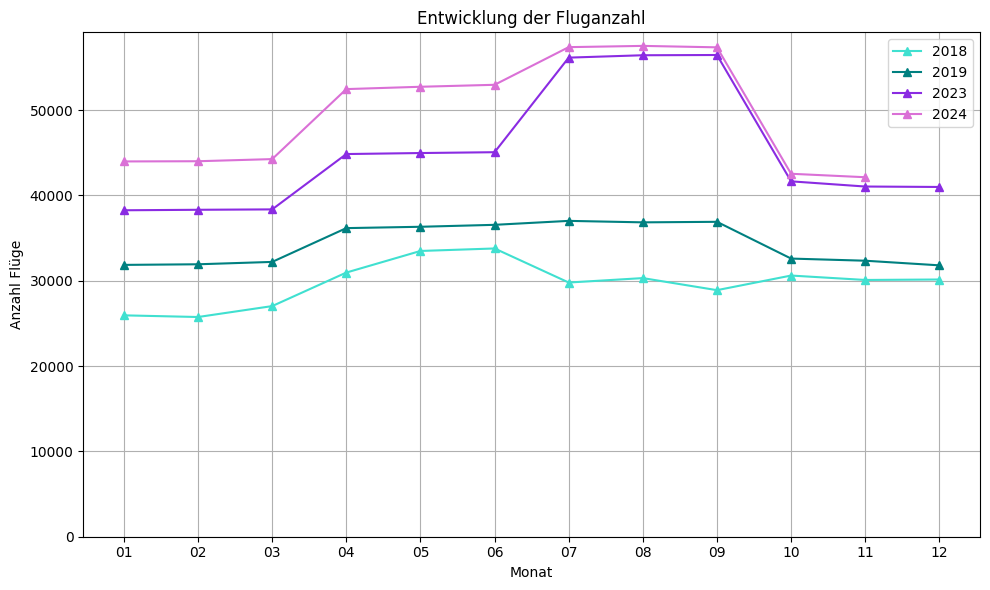

In [24]:
# Sort the data based on months
#sorted_data = sorted(zip(months_2018, ieflight_2018, ieflight_2019, ieflight_2023, ieflight_2024), key=lambda x: x[0])
#months_sorted, ieflight_2018_sorted, ieflight_2019_sorted, ieflight_2023_sorted, ieflight_2024_sorted = zip(*sorted_data)

# Create the plot for number of nodes
#fig = plt.figure(figsize=(10, 6))
#plt.plot(months_sorted, ieflight_2018_sorted, markerToUse, color='turquoise', label='2018')
#plt.plot(months_sorted, ieflight_2019_sorted, markerToUse, color='teal', label='2019')
#plt.plot(months_sorted, ieflight_2023_sorted, markerToUse, color='blueviolet', label='2023')
#plt.plot(months_sorted, ieflight_2024_sorted, markerToUse, color='orchid', label='2024')


fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, ieflight_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, ieflight_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, ieflight_2023, markerToUse, color='blueviolet', label='2023')
# ensure all lists have the same length
plt.plot(months_2024[:-1], ieflight_2024[:-1], markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('Anzahl Flüge')
plt.title('Entwicklung der Fluganzahl')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(bottom=0)

filetitle="ieflight"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

plt.show()


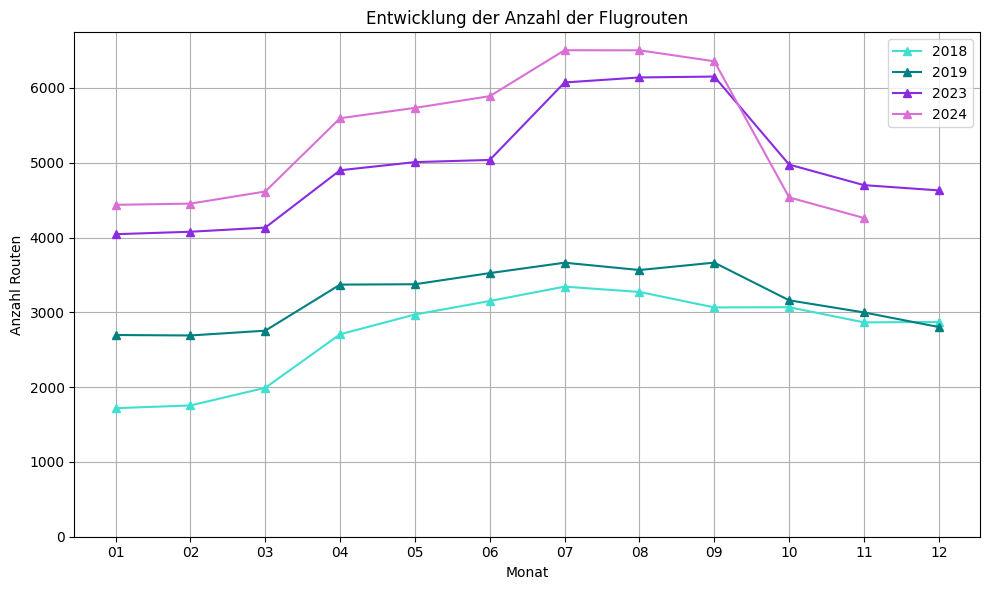

In [27]:
# # Create the plot for number of nodes

fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, neroute_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, neroute_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, neroute_2023, markerToUse, color='blueviolet', label='2023')
# don't plot the make-up point for 2024
plt.plot(months_2024[:-1], neroute_2024[:-1], markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('Anzahl Routen')
plt.title('Entwicklung der Anzahl der Flugrouten')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()

filetitle="neroute"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

plt.show()

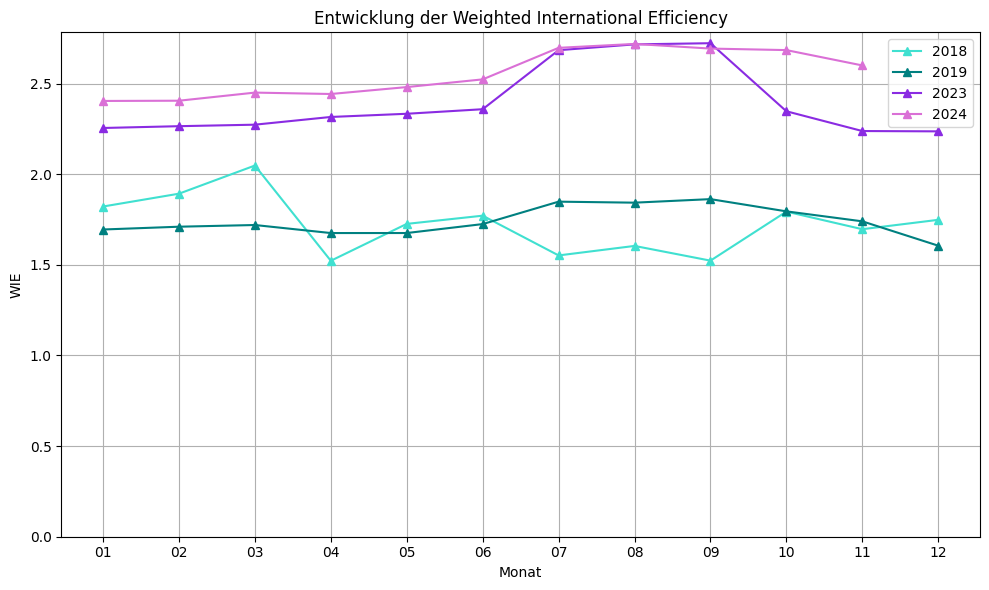

In [28]:
# # Create the plot for WIE
fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, wie_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, wie_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, wie_2023, markerToUse, color='blueviolet', label='2023')
# don't plot the make-up point for 2024
plt.plot(months_2024[:-1], wie_2024[:-1], markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('WIE')
plt.title('Entwicklung der Weighted International Efficiency')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()

filetitle="WIE"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

plt.show()

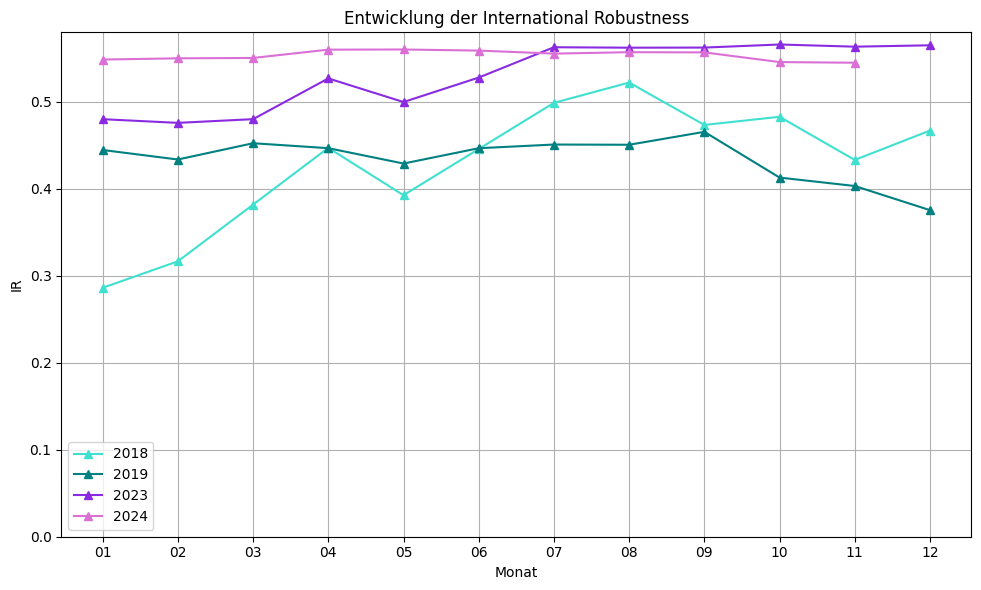

In [29]:
# # Create the plot for ir
fig = plt.figure(figsize=(10, 6))
plt.plot(months_2018, ir_2018, markerToUse, color='turquoise', label='2018')
plt.plot(months_2019, ir_2019, markerToUse, color='teal', label='2019')
plt.plot(months_2023, ir_2023, markerToUse, color='blueviolet', label='2023')
# don't plot the make-up point for 2024
plt.plot(months_2024[:-1], ir_2024[:-1], markerToUse, color='orchid', label='2024')

plt.xlabel('Monat')
plt.ylabel('IR')
plt.title('Entwicklung der International Robustness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(bottom=0)
#plt.ylim(ymin=0)

filetitle="IR"
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/png/{filetitle}_{countryname}_{timestamp}.png"
plt.savefig(resultfilename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))
resultfilename = f"/content/drive/My Drive/2024KomplexeNetze/Ergebnisse/svg/{filetitle}_{countryname}_{timestamp}.svg"
plt.savefig(resultfilename, bbox_inches=Bbox([[0,-2],fig.get_size_inches()]))

plt.show()